# FomulaBEAT

4-1-1からの変更点
- 深さが2のポーランド記法を逆ポーランド記法に変換するタスク
- Embeddingをデコーダーとエンコーダーで同じものを使う
- Linear層を消す


In [1]:
version = '04-1-2'
model_dir = './model/' + version
data_path = 'data/eq03-2.txt'

In [2]:
from pathlib import Path
import math
import time
from collections import Counter
from tqdm import tqdm
import torch
from torch.utils.data import random_split
import torch.nn as nn
from torch import Tensor
from torch.nn import (
    TransformerEncoder, TransformerDecoder,
    TransformerEncoderLayer, TransformerDecoderLayer
)
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive
import torch.nn.functional as F
from torch import Tensor

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchte

パラメータの事前設定

In [3]:
%load_ext autoreload
%autoreload 2
torch.set_printoptions(linewidth=100)

In [4]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_dir_path = Path(model_dir)
if not model_dir_path.exists():
    model_dir_path.mkdir(parents=True)

データの取得

In [5]:
def read_equation_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    src_data, tgt_data = [], []
    for line in lines:
        src, tgt = line.strip().split(' => ')
        src_data.append(src)
        tgt_data.append(tgt)
    return src_data, tgt_data


In [6]:
# ファイルを読み込み、数式データを取得
src_data, tgt_data = read_equation_file(data_path)
print(src_data[:3], tgt_data[:3])


['+ + 3 4 + 1 2', '+ + 8 5 + 4 6', '+ + 4 8 + 9 9'] ['3 4 + 1 2 + +', '8 5 + 4 6 + +', '4 8 + 9 9 + +']


辞書データの作成

In [7]:

SPECIALS = ['<unk>', '<pad>', '<start>', '<end>']

def build_vocab(texts):
    vocab = {}
    idx = 0
    # 数字の語彙定義
    for i in range(10):
        vocab[str(i)] = idx
        idx += 1
    # 特別語の語彙定義
    for sp in SPECIALS:
        vocab[sp] = idx
        idx += 1
    # その他の文字の語彙定義
    for text in texts:
        for char in text:
            if char not in vocab:
                vocab[char] = idx
                idx += 1
    return vocab


def convert_text_to_indexes(text, vocab):
    # <start> と <end> トークンを追加して数値化
    return [vocab['<start>']] + [vocab[char] if char in vocab else vocab['<unk>'] for char in text] + [vocab['<end>']]

# データを処理して Train と Valid に分ける関数
# データを処理して Train と Valid に分ける関数
def data_process_split(src_texts, tgt_texts, vocab_src, vocab_tgt, valid_size=0.2):
    # データを数値化
    data = []
    for (src, tgt) in zip(src_texts, tgt_texts):
        src_tensor = torch.tensor(convert_text_to_indexes(src, vocab_src), dtype=torch.long)
        tgt_tensor = torch.tensor(convert_text_to_indexes(tgt, vocab_tgt), dtype=torch.long)
        data.append((src_tensor, tgt_tensor))
    
    # データのサイズを計算して、訓練データと検証データに分割
    data_size = len(data)
    valid_size = int(valid_size * data_size)
    train_size = data_size - valid_size

    # PyTorchのrandom_splitを使って分割
    train_data, valid_data = random_split(data, [train_size, valid_size])
    
    return train_data, valid_data



In [8]:
# srcとtgtを結合して辞書を構築
vocab_src = vocab_tgt = build_vocab(src_data + tgt_data)

print(vocab_src)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '<unk>': 10, '<pad>': 11, '<start>': 12, '<end>': 13, '+': 14, ' ': 15}


In [9]:
convert_text_to_indexes("+ + 1 5 + 8 5", vocab_src)


[12, 14, 15, 14, 15, 1, 15, 5, 15, 14, 15, 8, 15, 5, 13]

In [10]:

# データを数値化
train_data, valid_data = data_process_split(src_data, tgt_data, vocab_src, vocab_tgt)

# 結果の確認
print('インデックス化された文章')
print(f"Input: {train_data[0][0]}\nOutput: {train_data[0][1]}")

# インデックスから元の文字列に戻す
def convert_indexes_to_text(indexes:list, vocab):
    reverse_vocab = {idx: token for token, idx in vocab.items()}
    return ''.join([reverse_vocab[idx] for idx in indexes if idx in reverse_vocab and reverse_vocab[idx] not in ['<start>', '<end>', '<pad>']])

print('元に戻した文章')
print(f"Input: {convert_indexes_to_text(train_data[0][0].tolist(), vocab_src)}")
print(f"Output: {convert_indexes_to_text(train_data[0][1].tolist(), vocab_tgt)}")


インデックス化された文章
Input: tensor([12, 14, 15, 14, 15,  3, 15,  8, 15, 14, 15,  8, 15,  3, 13])
Output: tensor([12,  3, 15,  8, 15, 14, 15,  8, 15,  3, 15, 14, 15, 14, 13])
元に戻した文章
Input: + + 3 8 + 8 3
Output: 3 8 + 8 3 + +


In [11]:
batch_size = 1024
PAD_IDX = vocab_src['<pad>']
START_IDX = vocab_src['<start>']
END_IDX = vocab_src['<end>']

def generate_batch(data_batch):
    
    batch_src, batch_tgt = [], []
    for src, tgt in data_batch:
        batch_src.append(src)
        batch_tgt.append(tgt)
        
    batch_src = pad_sequence(batch_src, padding_value=PAD_IDX)
    batch_tgt = pad_sequence(batch_tgt, padding_value=PAD_IDX)
    
    return batch_src, batch_tgt

train_iter = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)

In [12]:
len(train_data)

80000

Transoformerの設定

In [13]:
class TokenEmbedding(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=PAD_IDX)
        self.embedding_size = embedding_size
        
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.embedding_size)
    
    
class PositionalEncoding(nn.Module):
    
    def __init__(self, embedding_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('embedding_pos', embedding_pos)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.embedding_pos[: token_embedding.size(0), :])


In [14]:

class TransformerDecoderLayerScratch(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(TransformerDecoderLayerScratch, self).__init__()
        # Self-attention for the decoder
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Multihead attention for attending to encoder outputs (memory)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Layer normalization layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        # Dropout
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Self-attention
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        
        # Attention with the encoder outputs (memory)
        tgt2, _ = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask, key_padding_mask=memory_key_padding_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        
        return tgt


In [15]:

class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        embedding_size: int, vocab_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.token_embedding = TokenEmbedding(vocab_size, embedding_size)
        self.positional_encoding = PositionalEncoding(embedding_size, dropout=dropout)
        
        self.decoder_layer = TransformerDecoderLayerScratch(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        
        self.output = nn.Linear(embedding_size, vocab_size)

    def forward(
        self, src: Tensor, tgt: Tensor,
        mask_src: Tensor, mask_tgt: Tensor,
        padding_mask_src: Tensor, padding_mask_tgt: Tensor,
        memory_key_padding_mask: Tensor
    ):
        embedding_src = self.positional_encoding(self.token_embedding(src))
        # memory = self.transformer_encoder(embedding_src, mask_src, padding_mask_src)
        embedding_tgt = self.positional_encoding(self.token_embedding(tgt))
        outs = self.decoder_layer(
            embedding_tgt, embedding_src, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return self.output(outs)

    def decode(self, tgt: Tensor, memory: Tensor, mask_tgt: Tensor):
        return self.decoder_layer(self.positional_encoding(self.token_embedding(tgt)), memory, mask_tgt)

In [16]:
def create_mask(src, tgt, PAD_IDX):
    
    seq_len_src = src.shape[0]
    seq_len_tgt = tgt.shape[0]

    mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)
    mask_tgt = generate_square_subsequent_mask(seq_len_tgt)

    padding_mask_src = (src == PAD_IDX).transpose(0, 1)
    padding_mask_tgt = (tgt == PAD_IDX).transpose(0, 1)
    
    return mask_src, mask_tgt, padding_mask_src, padding_mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones((seq_len, seq_len), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

学習の定義

In [17]:
def train(model, data, optimizer, criterion, PAD_IDX):
    
    model.train()
    losses = 0
    for src, tgt in tqdm(data):
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )

        optimizer.zero_grad()
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / len(data)

In [18]:

def evaluate(model, data, criterion, PAD_IDX):
    
    model.eval()
    losses = 0
    for src, tgt in data:
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        losses += loss.item()
        
    return losses / len(data)

設定

In [19]:
vocab_size_src = len(vocab_src)
vocab_size_tgt = len(vocab_tgt)
embedding_size = 4
nhead = 1
dim_feedforward = 4
num_encoder_layers = 1
num_decoder_layers = 1
dropout = 0
# vocab_size_src = len(vocab_src)
# vocab_size_tgt = len(vocab_tgt)
# embedding_size = 240
# nhead = 8
# dim_feedforward = 100
# num_encoder_layers = 2
# num_decoder_layers = 2
# dropout = 0.1

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(model.parameters())

モデルの調査

In [20]:
print(model)

Seq2SeqTransformer(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(16, 4, padding_idx=11)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
    (dropout2): Dropout(p=0, inplace=False)
  )
  (output): Linear(in_features=4, out_features=16, bias=True)
)


In [21]:
# モデル内の層の名前とパラメータ情報を表示
LP = list(model.named_parameters())
lp = len(LP)
print(f"{lp} 層")
for p in range(0, lp):
    print(f"\n層名: {LP[p][0]}")
    print(f"形状: {LP[p][1].shape}")
    print(f"値: {LP[p][1]}")


15 層

層名: token_embedding.embedding.weight
形状: torch.Size([16, 4])
値: Parameter containing:
tensor([[-0.4187, -0.2101, -0.4491,  0.2617],
        [ 0.3487,  0.0571, -0.0761, -0.3750],
        [-0.0540, -0.4042, -0.3301, -0.4283],
        [-0.5272,  0.1705,  0.0033,  0.1150],
        [-0.2595, -0.2385, -0.2934, -0.0601],
        [-0.5333, -0.4088, -0.1288,  0.3019],
        [ 0.1934,  0.3401, -0.1480, -0.5133],
        [-0.2749, -0.0585, -0.4330,  0.2547],
        [ 0.0705,  0.5266, -0.3461,  0.3655],
        [ 0.2828,  0.2032, -0.0310, -0.2195],
        [ 0.4200,  0.1659, -0.1896, -0.2597],
        [-0.4565, -0.2794, -0.0050,  0.3105],
        [ 0.3179,  0.4167,  0.4537,  0.4212],
        [ 0.2531,  0.0543,  0.0672, -0.2221],
        [ 0.3570, -0.0405,  0.4551,  0.1201],
        [-0.0553, -0.4539, -0.2784,  0.3488]], device='cuda:0', requires_grad=True)

層名: decoder_layer.self_attn.in_proj_weight
形状: torch.Size([12, 4])
値: Parameter containing:
tensor([[-0.2196,  0.0180, -0.5693,  0.30

## 学習実行

In [22]:
epoch = 100
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, data=train_iter, optimizer=optimizer,
        criterion=criterion, PAD_IDX=PAD_IDX
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, data=valid_iter, criterion=criterion, PAD_IDX=PAD_IDX
    )
    
    print('[{}/{}] train loss: {:.2f}, valid loss: {:.2f}  [{}{:.0f}s] counter: {} {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
        
    if counter > patience:
        break
    
    counter += 1

  0%|          | 0/79 [00:00<?, ?it/s]/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 79/79 [00:01<00:00, 59.28it/s]


[1/100] train loss: 2.62, valid loss: 2.32  [1s] counter: 0 **


100%|██████████| 79/79 [00:01<00:00, 68.51it/s]


[2/100] train loss: 2.11, valid loss: 1.90  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.04it/s]


[3/100] train loss: 1.69, valid loss: 1.47  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.33it/s]


[4/100] train loss: 1.33, valid loss: 1.24  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.22it/s]


[5/100] train loss: 1.15, valid loss: 1.04  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.16it/s]


[6/100] train loss: 0.94, valid loss: 0.86  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.29it/s]


[7/100] train loss: 0.82, valid loss: 0.78  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.13it/s]


[8/100] train loss: 0.76, valid loss: 0.74  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.19it/s]


[9/100] train loss: 0.73, valid loss: 0.72  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.34it/s]


[10/100] train loss: 0.71, valid loss: 0.70  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.00it/s]


[11/100] train loss: 0.70, valid loss: 0.69  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.46it/s]


[12/100] train loss: 0.69, valid loss: 0.69  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.03it/s]


[13/100] train loss: 0.68, valid loss: 0.68  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.54it/s]


[14/100] train loss: 0.68, valid loss: 0.68  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.83it/s]


[15/100] train loss: 0.67, valid loss: 0.67  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 67.61it/s]


[16/100] train loss: 0.67, valid loss: 0.66  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.62it/s]


[17/100] train loss: 0.66, valid loss: 0.65  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.43it/s]


[18/100] train loss: 0.65, valid loss: 0.64  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.44it/s]


[19/100] train loss: 0.64, valid loss: 0.64  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 67.72it/s]


[20/100] train loss: 0.63, valid loss: 0.62  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.23it/s]


[21/100] train loss: 0.62, valid loss: 0.62  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.40it/s]


[22/100] train loss: 0.62, valid loss: 0.61  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.49it/s]


[23/100] train loss: 0.61, valid loss: 0.61  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.71it/s]


[24/100] train loss: 0.60, valid loss: 0.60  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.54it/s]


[25/100] train loss: 0.60, valid loss: 0.59  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.32it/s]


[26/100] train loss: 0.59, valid loss: 0.59  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.55it/s]


[27/100] train loss: 0.59, valid loss: 0.60  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 69.14it/s]


[28/100] train loss: 0.59, valid loss: 0.60  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 67.76it/s]


[29/100] train loss: 0.58, valid loss: 0.58  [1s] counter: 3 **


100%|██████████| 79/79 [00:01<00:00, 69.59it/s]


[30/100] train loss: 0.58, valid loss: 0.58  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.59it/s]


[31/100] train loss: 0.58, valid loss: 0.58  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.19it/s]


[32/100] train loss: 0.58, valid loss: 0.58  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.48it/s]


[33/100] train loss: 0.58, valid loss: 0.58  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.85it/s]


[34/100] train loss: 0.57, valid loss: 0.57  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.50it/s]


[35/100] train loss: 0.57, valid loss: 0.58  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 69.65it/s]


[36/100] train loss: 0.57, valid loss: 0.57  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 69.94it/s]


[37/100] train loss: 0.57, valid loss: 0.57  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.15it/s]


[38/100] train loss: 0.57, valid loss: 0.57  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.51it/s]


[39/100] train loss: 0.57, valid loss: 0.57  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.36it/s]


[40/100] train loss: 0.57, valid loss: 0.57  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 69.34it/s]


[41/100] train loss: 0.57, valid loss: 0.56  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 68.78it/s]


[42/100] train loss: 0.56, valid loss: 0.56  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.63it/s]


[43/100] train loss: 0.57, valid loss: 0.56  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.54it/s]


[44/100] train loss: 0.56, valid loss: 0.56  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.17it/s]


[45/100] train loss: 0.57, valid loss: 0.56  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 69.54it/s]


[46/100] train loss: 0.56, valid loss: 0.56  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 66.95it/s]


[47/100] train loss: 0.56, valid loss: 0.56  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 69.33it/s]


[48/100] train loss: 0.56, valid loss: 0.56  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 69.64it/s]


[49/100] train loss: 0.56, valid loss: 0.56  [1s] counter: 3 


100%|██████████| 79/79 [00:01<00:00, 69.28it/s]


[50/100] train loss: 0.55, valid loss: 0.55  [1s] counter: 4 **


100%|██████████| 79/79 [00:01<00:00, 68.82it/s]


[51/100] train loss: 0.55, valid loss: 0.55  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 69.48it/s]


[52/100] train loss: 0.55, valid loss: 0.55  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 69.55it/s]


[53/100] train loss: 0.55, valid loss: 0.55  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.55it/s]


[54/100] train loss: 0.55, valid loss: 0.56  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 67.71it/s]


[55/100] train loss: 0.54, valid loss: 0.54  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 69.37it/s]


[56/100] train loss: 0.54, valid loss: 0.54  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 69.73it/s]


[57/100] train loss: 0.54, valid loss: 0.54  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 69.48it/s]


[58/100] train loss: 0.54, valid loss: 0.54  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.51it/s]


[59/100] train loss: 0.54, valid loss: 0.53  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.39it/s]


[60/100] train loss: 0.54, valid loss: 0.53  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.23it/s]


[61/100] train loss: 0.53, valid loss: 0.53  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.28it/s]


[62/100] train loss: 0.53, valid loss: 0.53  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 69.46it/s]


[63/100] train loss: 0.53, valid loss: 0.53  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 67.66it/s]


[64/100] train loss: 0.53, valid loss: 0.53  [1s] counter: 3 **


100%|██████████| 79/79 [00:01<00:00, 68.46it/s]


[65/100] train loss: 0.53, valid loss: 0.53  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.46it/s]


[66/100] train loss: 0.52, valid loss: 0.53  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 69.44it/s]


[67/100] train loss: 0.53, valid loss: 0.53  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 69.40it/s]


[68/100] train loss: 0.52, valid loss: 0.52  [1s] counter: 3 **


100%|██████████| 79/79 [00:01<00:00, 68.46it/s]


[69/100] train loss: 0.52, valid loss: 0.52  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.26it/s]


[70/100] train loss: 0.52, valid loss: 0.52  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.01it/s]


[71/100] train loss: 0.52, valid loss: 0.53  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 69.57it/s]


[72/100] train loss: 0.53, valid loss: 0.52  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 69.47it/s]


[73/100] train loss: 0.52, valid loss: 0.52  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.56it/s]


[74/100] train loss: 0.52, valid loss: 0.52  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 68.76it/s]


[75/100] train loss: 0.52, valid loss: 0.51  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 69.39it/s]


[76/100] train loss: 0.52, valid loss: 0.52  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 68.68it/s]


[77/100] train loss: 0.51, valid loss: 0.52  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 68.68it/s]


[78/100] train loss: 0.51, valid loss: 0.51  [1s] counter: 3 **


100%|██████████| 79/79 [00:01<00:00, 68.49it/s]


[79/100] train loss: 0.51, valid loss: 0.52  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 69.70it/s]


[80/100] train loss: 0.52, valid loss: 0.52  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 68.68it/s]


[81/100] train loss: 0.51, valid loss: 0.51  [1s] counter: 3 


100%|██████████| 79/79 [00:01<00:00, 69.91it/s]


[82/100] train loss: 0.51, valid loss: 0.51  [1s] counter: 4 **


100%|██████████| 79/79 [00:01<00:00, 68.39it/s]


[83/100] train loss: 0.51, valid loss: 0.51  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 69.59it/s]


[84/100] train loss: 0.51, valid loss: 0.51  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 69.43it/s]


[85/100] train loss: 0.51, valid loss: 0.51  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.08it/s]


[86/100] train loss: 0.51, valid loss: 0.51  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 68.90it/s]


[87/100] train loss: 0.51, valid loss: 0.51  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 69.51it/s]


[88/100] train loss: 0.50, valid loss: 0.50  [1s] counter: 3 **


100%|██████████| 79/79 [00:01<00:00, 66.88it/s]


[89/100] train loss: 0.51, valid loss: 0.52  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 69.43it/s]


[90/100] train loss: 0.51, valid loss: 0.51  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 69.70it/s]


[91/100] train loss: 0.50, valid loss: 0.50  [1s] counter: 3 


100%|██████████| 79/79 [00:01<00:00, 69.48it/s]


[92/100] train loss: 0.50, valid loss: 0.52  [1s] counter: 4 


100%|██████████| 79/79 [00:01<00:00, 67.96it/s]


[93/100] train loss: 0.51, valid loss: 0.50  [1s] counter: 5 


100%|██████████| 79/79 [00:01<00:00, 69.49it/s]


[94/100] train loss: 0.50, valid loss: 0.52  [1s] counter: 6 


100%|██████████| 79/79 [00:01<00:00, 69.68it/s]


[95/100] train loss: 0.51, valid loss: 0.50  [1s] counter: 7 **


100%|██████████| 79/79 [00:01<00:00, 69.57it/s]


[96/100] train loss: 0.50, valid loss: 0.50  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.59it/s]


[97/100] train loss: 0.50, valid loss: 0.50  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 69.62it/s]


[98/100] train loss: 0.50, valid loss: 0.50  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 69.51it/s]


[99/100] train loss: 0.50, valid loss: 0.50  [1s] counter: 3 **


100%|██████████| 79/79 [00:01<00:00, 69.74it/s]


[100/100] train loss: 0.50, valid loss: 0.51  [1s] counter: 1 


学習したモデルの保存

In [23]:
torch.save(best_model.state_dict(), model_dir_path.joinpath(version + 'translation_transfomer.pth'))

学習したモデルを使って翻訳をする

In [24]:
def translate(
    model, text, vocab_src, vocab_tgt, seq_len_tgt,
    START_IDX, END_IDX
):
    model.eval()
    tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
    num_tokens_src = len(tokens_src)

    # Tensorに変換
    src = torch.LongTensor(tokens_src).reshape(num_tokens_src, 1).to(device)
    mask_src = torch.zeros((num_tokens_src, num_tokens_src), device=device).type(torch.bool)

    # デコード
    predicts = greedy_decode(
        model=model, src=src,
        mask_src=mask_src, seq_len_tgt=seq_len_tgt,
        START_IDX=START_IDX, END_IDX=END_IDX
    ).flatten()

    return convert_indexes_to_text(predicts.tolist(), vocab=vocab_tgt)

def greedy_decode(model, src, mask_src, seq_len_tgt, START_IDX, END_IDX):
    src = src.to(device)
    mask_src = mask_src.to(device)

    # ソースの埋め込みをメモリとして利用
    memory = model.positional_encoding(model.token_embedding(src))
    
    ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)
    
    for i in range(seq_len_tgt - 1):
        memory = memory.to(device)
        mask_tgt = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)
        
        output = model.decode(ys, memory, mask_tgt)
        output = output.transpose(0, 1)
        output = model.output(output[:, -1])
        
        # 最も高いスコアのトークンを取得
        _, next_word = torch.max(output, dim=1)
        next_word = next_word.item()

        # 生成されたトークンを追加
        ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
        if next_word == END_IDX:
            break
    
    return ys


In [25]:
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '+ + 1 5 + 8 5'

# 翻訳を実行
translation = translate(
    model=best_model, text=text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
    seq_len_tgt=seq_len_tgt,
    START_IDX=START_IDX, END_IDX=END_IDX
)

print(f"Input: {text}")
print(f"Output: {translation}")

Input: + + 1 5 + 8 5
Output: 0 8 + 8 0 + +


In [26]:
# 様々な入力を試してみる

text_list = {
'+ + 1 5 + 8 5':'1 5 + 8 5 + +',
'+ + 1 6 + 8 6':'1 6 + 8 6 + +',
'+ + 9 5 + 7 1':'9 5 + 7 1 + +',
'+ + 6 5 + 7 9':'6 5 + 7 9 + +',
'+ + 9 2 + 6 0':'9 2 + 6 0 + +'}
# text_list += { '+ 2 7':'2 7 -', '+ 9 7' : '9 7 -', '+ + 2 7 4' : '2 7 - 4 +', '+ + 6 9 - 7 3' : '6 9 - 7 3 - -', '+ + + + + + + 4 6 3 7 + 6 7 1 9 + + 3 6 2' : '4 6 + 3 + 7 + 6 7 + + 1 + 9 - 3 6 + 2 + + '}

for text, tgt in text_list.items():
    translation = translate(
        model=best_model, text=text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
        seq_len_tgt=seq_len_tgt,
        START_IDX=START_IDX, END_IDX=END_IDX
    )
    print(f"Input: {text}")
    print(f"Output: {translation}")
    print(f"Target: {tgt}")
    print('---')


Input: + + 1 5 + 8 5
Output: 0 8 + 8 0 + +
Target: 1 5 + 8 5 + +
---
Input: + + 1 6 + 8 6
Output: 6 6 + 6 7 + +
Target: 1 6 + 8 6 + +
---
Input: + + 9 5 + 7 1
Output: 6 6 + 6 6 + +
Target: 9 5 + 7 1 + +
---
Input: + + 6 5 + 7 9
Output: 7 6 + 6 6 + +
Target: 6 5 + 7 9 + +
---
Input: + + 9 2 + 6 0
Output: 9 7 + 6 7 + +
Target: 9 2 + 6 0 + +
---


## モデルの動作を分析

In [27]:
import torch

# モデルのロード
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')
loaded_model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()


Seq2SeqTransformer(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(16, 4, padding_idx=11)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
    (dropout2): Dropout(p=0, inplace=False)
  )
  (output): Linear(in_features=4, out_features=16, bias=True)
)

In [28]:

# モデルのパラメータを確認
params = dict(loaded_model.named_parameters())

for k, v in params.items():
    print(k, v.shape)



token_embedding.embedding.weight torch.Size([16, 4])
decoder_layer.self_attn.in_proj_weight torch.Size([12, 4])
decoder_layer.self_attn.in_proj_bias torch.Size([12])
decoder_layer.self_attn.out_proj.weight torch.Size([4, 4])
decoder_layer.self_attn.out_proj.bias torch.Size([4])
decoder_layer.multihead_attn.in_proj_weight torch.Size([12, 4])
decoder_layer.multihead_attn.in_proj_bias torch.Size([12])
decoder_layer.multihead_attn.out_proj.weight torch.Size([4, 4])
decoder_layer.multihead_attn.out_proj.bias torch.Size([4])
decoder_layer.norm1.weight torch.Size([4])
decoder_layer.norm1.bias torch.Size([4])
decoder_layer.norm2.weight torch.Size([4])
decoder_layer.norm2.bias torch.Size([4])
output.weight torch.Size([16, 4])
output.bias torch.Size([16])


In [31]:

# パラメータを取り出す

# 埋め込み行列を取得
embedding_weight = params['token_embedding.embedding.weight'].data

# 線形層の重みとバイアス
output_weight = params['output.weight'].data
output_bias = params['output.bias'].data

# デコーダの自己注意の重みとバイアス
self_attn_in_proj_weight = params['decoder_layer.self_attn.in_proj_weight'].data
self_attn_in_proj_bias = params['decoder_layer.self_attn.in_proj_bias'].data
self_attn_out_proj_weight = params['decoder_layer.self_attn.out_proj.weight'].data
self_attn_out_proj_bias = params['decoder_layer.self_attn.out_proj.bias'].data

# メモリー注意の重みとバイアス
multihead_attn_in_proj_weight = params['decoder_layer.multihead_attn.in_proj_weight'].data
multihead_attn_in_proj_bias = params['decoder_layer.multihead_attn.in_proj_bias'].data
multihead_attn_out_proj_weight = params['decoder_layer.multihead_attn.out_proj.weight'].data
multihead_attn_out_proj_bias = params['decoder_layer.multihead_attn.out_proj.bias'].data

# LayerNormのパラメータ
norm1_weight = params['decoder_layer.norm1.weight'].data
norm1_bias = params['decoder_layer.norm1.bias'].data
norm2_weight = params['decoder_layer.norm2.weight'].data
norm2_bias = params['decoder_layer.norm2.bias'].data


In [32]:

# Positional Encoding
def positional_encoding(tensor: Tensor, maxlen=5000):
    embedding_size = tensor.size(-1)
    den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
    pos = torch.arange(0, maxlen).reshape(maxlen, 1)
    embedding_pos = torch.zeros((maxlen, embedding_size))
    embedding_pos[:, 0::2] = torch.sin(pos * den)
    embedding_pos[:, 1::2] = torch.cos(pos * den)
    embedding_pos = embedding_pos.unsqueeze(-2)
    return tensor + embedding_pos[: tensor.size(0), :].to(tensor.device)

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
# ヒートマップを描画する関数
def visualize_attention(attn_weights, src_tokens, tgt_tokens, title="Attention Weights"):
    """
    attn_weights: Attention weights (2D numpy array)
    src_tokens: Source tokens (list of token strings)
    tgt_tokens: Target tokens (list of token strings)
    title: Title of the plot
    """
    plt.figure(figsize=(5, 5))
    sns.heatmap(attn_weights, cmap="viridis", xticklabels=src_tokens, yticklabels=tgt_tokens)
    plt.xlabel("Source")
    plt.ylabel("Target")
    plt.title(title)
    plt.show()


# インデックスからlistに戻す
def convert_indexes_to_list(indexes:list, vocab):
    reverse_vocab = {idx: token for token, idx in vocab.items()}
    return [reverse_vocab[idx] for idx in indexes if idx in reverse_vocab and reverse_vocab[idx]]


def visualize_scatter(points, title="Scatter Plot"):
    plt.figure(figsize=(10, 10))
    plt.scatter(points[:, 0], points[:, 1])
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title(title)
    plt.show()

## Embeddingを見る

tensor([[-0.1073,  0.4212],
        [-0.1203,  0.3706],
        [-0.0088, -0.0817],
        [-0.1179,  0.3986],
        [-0.0040, -0.0606],
        [-0.0203,  0.0508],
        [-0.0769,  0.1760],
        [-0.0359,  0.0170],
        [-0.0319,  0.1150],
        [-0.1169,  0.3472],
        [ 0.4200,  0.1659],
        [-0.4565, -0.2794],
        [ 0.6764,  0.5097],
        [ 0.5024,  0.4531],
        [ 0.6230,  0.1557],
        [-0.1902, -0.7036]])


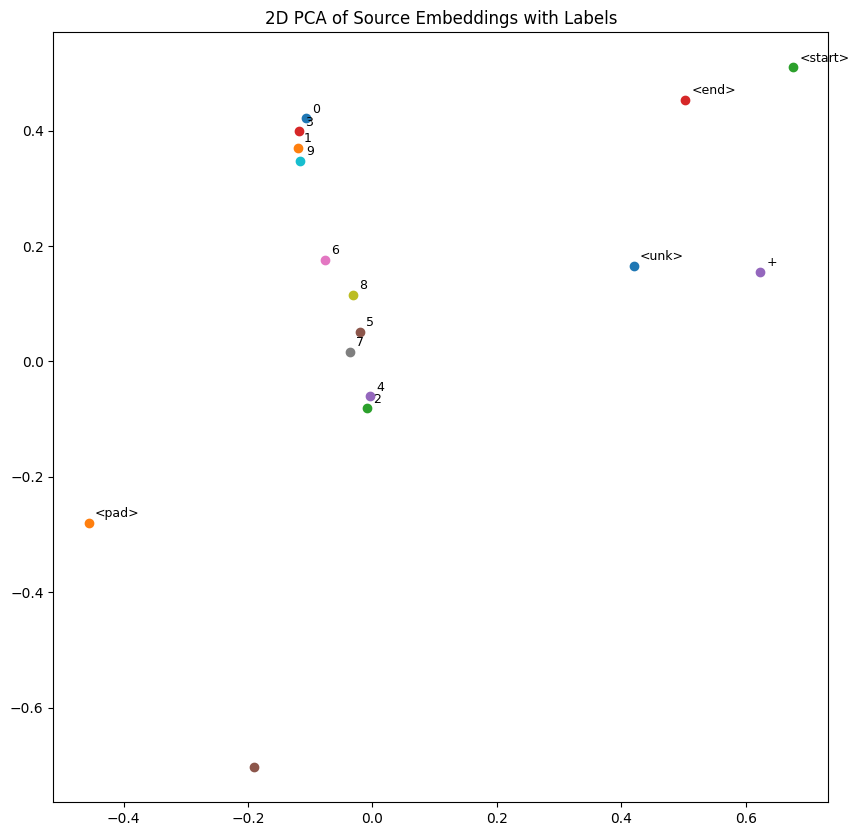

In [34]:
embedding_cpu = embedding_weight.cpu().detach()
print(embedding_cpu[: , :2])

# 逆辞書を作成してインデックスを文字に変換
reverse_vocab_src = {idx: token for token, idx in vocab_src.items()}

# 可視化
plt.figure(figsize=(10, 10))

# 各ポイントを散布図でプロットし、対応するラベルを表示
for i, (x, y) in enumerate(embedding_cpu[:, :2]):  # [:, :2]をスライスし、次にenumerate
    label = reverse_vocab_src[i]  # インデックスを元のトークンに戻す
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, label, fontsize=9)  # 各点の近くにラベルを表示

plt.title("2D PCA of Source Embeddings with Labels")
plt.show()

## Attentionを確認

In [44]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '+ + 1 5 + 8 5'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    self_attn_weights_np = self_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"self_attention: \n{self_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = tgt_tokens_
    print(f"tgt_tokens: {tgt_tokens_}")
    # Self-Attentionの可視化
    # visualize_attention(self_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    multi_attn_weights_np = multi_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"multi_attention: \n{multi_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)
    print(f"After Attention: {tgt}")
    # Memory-Attentionの可視化
    # visualize_attention(multi_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    

    # LayerNorm
    output = tgt.transpose(0, 1)
    output = loaded_model.output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

text: + + 1 5 + 8 5
memory: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 2.0876,  0.8517,  0.6141,  0.7785]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 1.3872, -0.6786,  0.6341,  0.7781]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]],

        [[-1.1995,  1.0248, -0.9498,  1.1930]],

        [[-0.6598, -0.4470,  0.0113,  1.0932]],

        [[ 0.6163,  0.8555, -0.9246,  1.5433]],

        [[ 0.6090, -1.5526,  0.0313,  1.0918]],

        [[ 1.6582, -0.5997,  0.6940,  0.7745]],

        [[-0.9244, -2.2462,  0.0512,  1.0900]],

        [[-1.0638,  0.2344, -0.9554,  1.7495]],

        [[-0.9170, -0.5633,  0.0711,  1.0878]],

        [[ 0.3795,  1.0091, -0.8649,  1.5373]],

        [[ 1.9954,  1.0429,  1.2897, -0.2614]]], device='cuda:0')
memory_size: torch.Size([15, 1, 4])

------------------

iter: 0
ys: tensor([[12]], device='cuda:0')
tgt_embed: tensor([[[1.3527, 2.0195, 1.8225, 1.8424]]], device='cuda:0')
now tgt: 
tgt_embed: tensor([[[1.3527, 2.0195,

text: + + 1 5 + 8 5
memory: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 2.0876,  0.8517,  0.6141,  0.7785]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 1.3872, -0.6786,  0.6341,  0.7781]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]],

        [[-1.1995,  1.0248, -0.9498,  1.1930]],

        [[-0.6598, -0.4470,  0.0113,  1.0932]],

        [[ 0.6163,  0.8555, -0.9246,  1.5433]],

        [[ 0.6090, -1.5526,  0.0313,  1.0918]],

        [[ 1.6582, -0.5997,  0.6940,  0.7745]],

        [[-0.9244, -2.2462,  0.0512,  1.0900]],

        [[-1.0638,  0.2344, -0.9554,  1.7495]],

        [[-0.9170, -0.5633,  0.0711,  1.0878]],

        [[ 0.3795,  1.0091, -0.8649,  1.5373]],

        [[ 1.9954,  1.0429,  1.2897, -0.2614]]], device='cuda:0')
memory_size: torch.Size([15, 1, 4])

------------------

iter: 0
ys: tensor([[12]], device='cuda:0')
tgt_embed: tensor([[[1.3527, 2.0195, 1.8225, 1.8424]]], device='cuda:0')
now tgt: 
tgt_embed: tensor([[[1.3527, 2.0195,

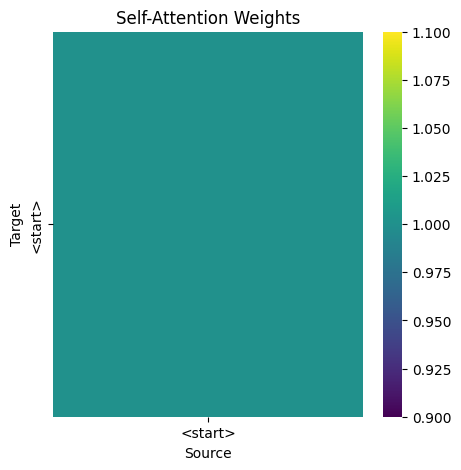

QV.shape: torch.Size([1, 1, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 1, 15])
AV.shape: torch.Size([1, 1, 4])
multi_attention: 
[[0.4513962  0.02296338 0.00239014 0.00782504 0.01087815 0.19234107
  0.04654859 0.02051858 0.003219   0.0068189  0.00733725 0.05320132
  0.05643991 0.03370747 0.08441508]]
After Attention: tensor([[[ 1.3570,  2.7518, -4.3006, -0.9549]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)


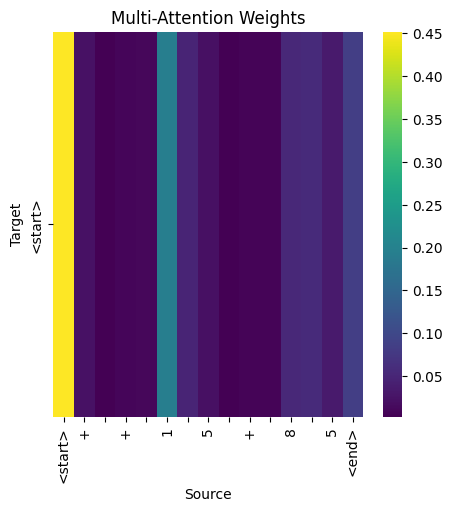

output.shape: torch.Size([1, 16])
output: tensor([[  5.6338,   3.6022,   2.5426,   4.6395,   3.5496,   4.2204,   2.4832,   2.4850,   4.4834,
           3.1016,  -4.2470,  -4.4699,  -4.2003,  -5.4518, -13.2377,  -8.4199]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 0

------------------

iter: 1
ys: tensor([[12],
        [ 0]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]]], device='cuda:0')
now tgt: 0
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]]], device='cuda:0')
SelfAttention Layer
QV.shape: torch.Size([1, 2, 4])
KV.shape: torch.Size([1, 2, 4])
WV.shape: torch.Size([1, 2, 4])
attn_weight.shape: torch.Size([1, 2, 2])
AV.shape: torch.Size([1, 2, 4])
self_attention: 
[[0.961093   0.03890705]
 [0.09062635 0.90937364]]
tgt_tokens: ['<start>', '0']


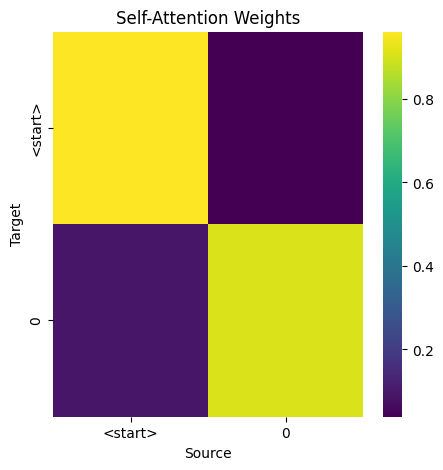

QV.shape: torch.Size([1, 2, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 2, 15])
AV.shape: torch.Size([1, 2, 4])
multi_attention: 
[[3.81707609e-01 2.20805779e-02 3.07650142e-03 8.54041800e-03
  1.47295929e-02 2.23752409e-01 5.52683398e-02 2.35127583e-02
  4.03499743e-03 7.32241943e-03 9.98075679e-03 6.67373762e-02
  6.76302984e-02 3.81916948e-02 7.34341666e-02]
 [5.91111639e-05 2.48832919e-04 5.39788827e-02 2.50167632e-03
  3.32348824e-01 4.15838361e-02 3.54784578e-02 1.06196152e-02
  3.45250256e-02 1.64401624e-03 3.07760775e-01 1.21179916e-01
  4.76057976e-02 1.04137361e-02 5.15195352e-05]]
After Attention: tensor([[[-1.3930,  1.8004, -4.6985,  2.7037]],

        [[-3.6937,  0.9762, -3.1348,  3.9710]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)


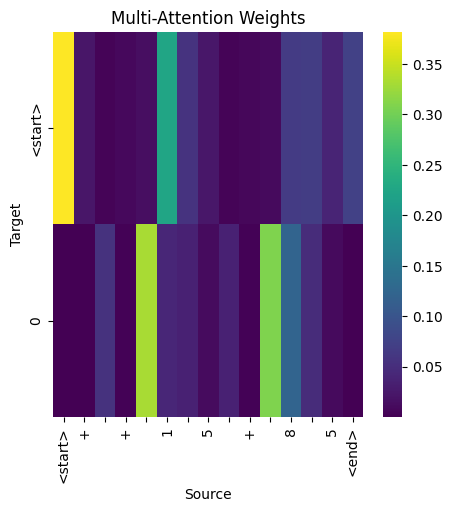

output.shape: torch.Size([1, 16])
output: tensor([[ -3.3507,   2.0495, -11.9077,   1.1551, -13.5856, -14.2249,  -3.8566,  -8.7144, -13.6841,
           1.2441,  -6.3218,  -6.3238,  -5.9372,  -3.1547,  -8.5549,   9.7613]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 15

------------------

iter: 2
ys: tensor([[12],
        [ 0],
        [15]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]]], device='cuda:0')
now tgt: 0 
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]]], device='cuda:0')
SelfAttention Layer
QV.shape: torch.Size([1, 3, 4])
KV.shape: torch.Size([1, 3, 4])
WV.shape: torch.Size([1, 3, 4])
attn_weight.shape: torch.Size([1, 3, 3])
AV.shape: torch.Size([1, 3, 4])
self_attention: 
[[0.50217766 0.0203292  0.4774931 ]
 [0.06932463 0.69

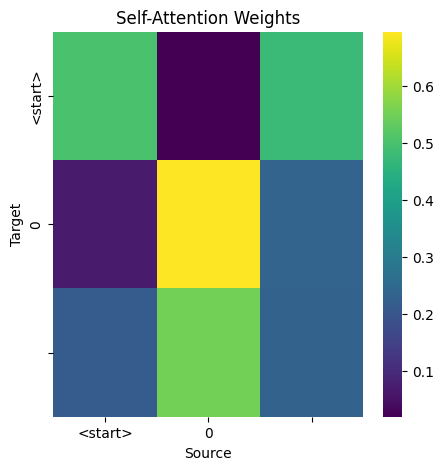

QV.shape: torch.Size([1, 3, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 3, 15])
AV.shape: torch.Size([1, 3, 4])
multi_attention: 
[[1.67818496e-03 1.15634245e-03 2.28692796e-02 3.90223716e-03
  1.94871604e-01 1.74477950e-01 7.35261366e-02 2.01661270e-02
  1.88579597e-02 2.64069298e-03 1.50572047e-01 2.08107501e-01
  1.01094835e-01 2.54313350e-02 6.47773326e-04]
 [3.36989069e-05 1.89626910e-04 5.94702922e-02 2.25420645e-03
  3.44636321e-01 3.16840820e-02 3.02494857e-02 9.26063303e-03
  3.65617611e-02 1.47671718e-03 3.28717738e-01 1.06344223e-01
  4.03713398e-02 8.71651527e-03 3.35160003e-05]
 [7.43092000e-01 2.43203118e-02 3.98410339e-04 3.88583750e-03
  8.97781458e-04 2.64346544e-02 7.88646750e-03 4.98410687e-03
  6.22441992e-04 3.96845350e-03 6.36734709e-04 5.22795599e-03
  8.59970786e-03 8.10596999e-03 1.60939127e-01]]
After Attention: tensor([[[-3.3451,  0.7542, -3.3187,  4.1175]],

        [[-3.7759,  1.0552, -3.0969,  3.9

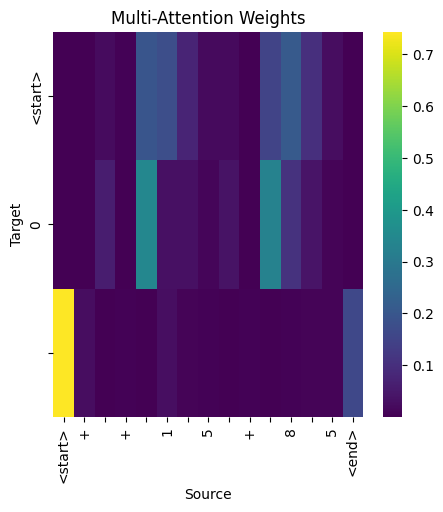

output.shape: torch.Size([1, 16])
output: tensor([[  6.1047,   4.4284,   6.2420,   5.1066,   6.8474,   6.9899,   5.0762,   5.8739,   7.0064,
           4.1653,  -3.6411,  -3.8028,  -3.5991,  -7.3128, -11.7827, -10.7484]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 8

------------------

iter: 3
ys: tensor([[12],
        [ 0],
        [15],
        [ 8]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]]], device='cuda:0')
now tgt: 0 8
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]]], device='cuda:0')
SelfAttention Layer
QV.shape: torch.Size([1, 4, 4])
KV.shape: torch.Size([1, 4, 4])
WV.shape: torch.Size([1, 4, 4])
attn_weight.shape: torch.Size([

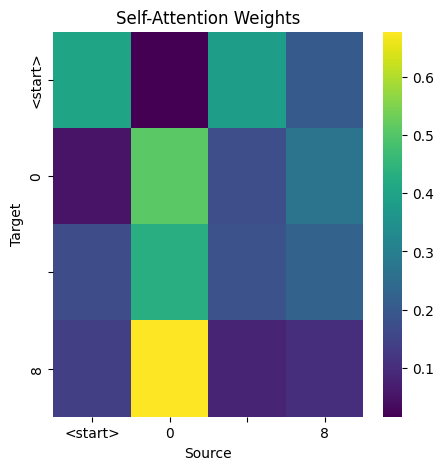

QV.shape: torch.Size([1, 4, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 4, 15])
AV.shape: torch.Size([1, 4, 4])
multi_attention: 
[[1.2203660e-05 7.3496965e-05 4.5093939e-02 1.1432996e-03 3.6913380e-01
  3.0753084e-02 2.5512481e-02 6.5380372e-03 2.6385495e-02 6.9817458e-04
  3.3976865e-01 1.1275917e-01 3.5820507e-02 6.2968833e-03 1.0724655e-05]
 [1.6290283e-05 1.3331376e-04 6.6736035e-02 1.9602275e-03 3.5600802e-01
  2.2043727e-02 2.4349229e-02 7.7024195e-03 3.9009400e-02 1.2800189e-03
  3.5291463e-01 8.8706061e-02 3.2247461e-02 6.8738572e-03 1.9235838e-05]
 [7.4380285e-01 2.5009872e-02 3.6517493e-04 3.8279730e-03 7.4640388e-04
  2.1488650e-02 6.7630755e-03 4.4867895e-03 5.7428220e-04 3.9782836e-03
  5.3665409e-04 4.2457795e-03 7.2738933e-03 7.2090607e-03 1.6969119e-01]
 [3.0375220e-02 1.3873894e-02 3.3141024e-02 1.9748420e-02 1.1570851e-01
  1.7278451e-01 9.7528994e-02 4.2716760e-02 3.2246906e-02 1.6216189e-02
  9.6229099e-02

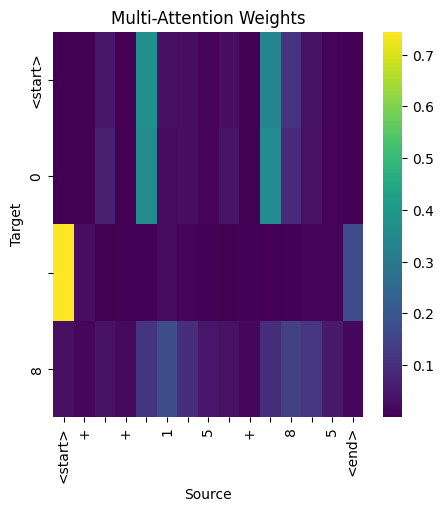

output.shape: torch.Size([1, 16])
output: tensor([[ -4.6756,   2.0868, -12.3694,   0.6950, -14.6716, -15.8007,  -3.6456,  -8.8215, -15.3487,
           1.3170,  -6.2187,  -6.1452,  -5.7780,  -3.5680,  -6.5165,  11.7090]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 15

------------------

iter: 4
ys: tensor([[12],
        [ 0],
        [15],
        [ 8],
        [15]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]]], device='cuda:0')
now tgt: 0 8 
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]]], device='cuda:0')
SelfAttention Layer
QV.shape: tor

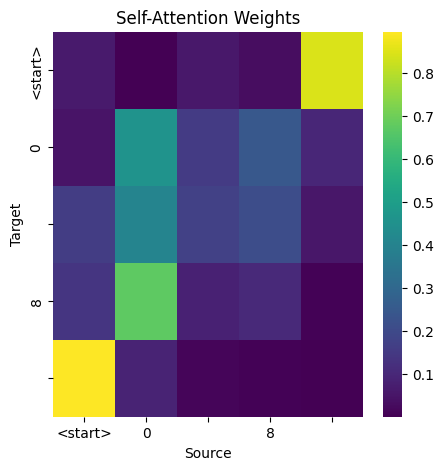

QV.shape: torch.Size([1, 5, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 5, 15])
AV.shape: torch.Size([1, 5, 4])
multi_attention: 
[[9.71805770e-03 9.05892551e-02 1.91090450e-01 1.42162263e-01
  3.33887003e-02 3.69999884e-03 1.50482552e-02 3.62049900e-02
  1.62908927e-01 1.77381009e-01 4.85049784e-02 8.99619702e-03
  1.19647104e-02 2.35492326e-02 4.47929688e-02]
 [1.11308918e-05 1.11780544e-04 7.11888745e-02 1.83494994e-03
  3.59744579e-01 1.79816615e-02 2.15807427e-02 6.98675448e-03
  4.05222066e-02 1.19815290e-03 3.64566833e-01 7.97831863e-02
  2.84230243e-02 6.05159765e-03 1.44855976e-05]
 [7.65964568e-01 2.21127309e-02 2.12905754e-04 2.83339457e-03
  3.92381218e-04 1.35562019e-02 4.25188197e-03 3.00598913e-03
  3.47188557e-04 3.02726193e-03 2.82046472e-04 2.43312190e-03
  4.49539023e-03 4.87580569e-03 1.72209188e-01]
 [3.06496061e-02 1.40110832e-02 3.32397446e-02 1.98907163e-02
  1.15470044e-01 1.72359124e-01 9.75311473e-02

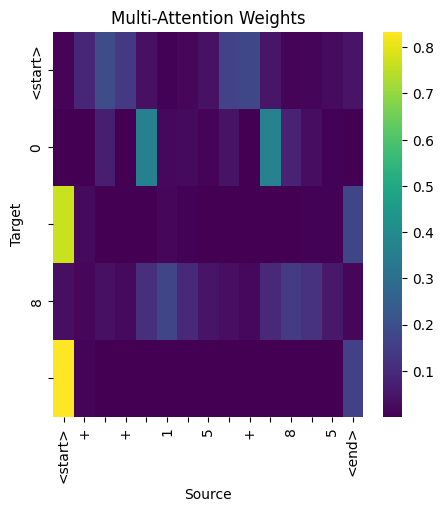

output.shape: torch.Size([1, 16])
output: tensor([[-0.5916, -4.0192,  1.2973, -2.9681,  3.2773,  3.6199, -2.8403,  0.5337,  3.4901, -6.6013,
          2.9230,  3.1639,  3.1772,  4.1598, 16.5698,  2.7223]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 14

------------------

iter: 5
ys: tensor([[12],
        [ 0],
        [15],
        [ 8],
        [15],
        [14]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]],

        [[ 0.2872,  0.5951,  0.6541,  0.7773]]], device='cuda:0')
now tgt: 0 8 +
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]],

  

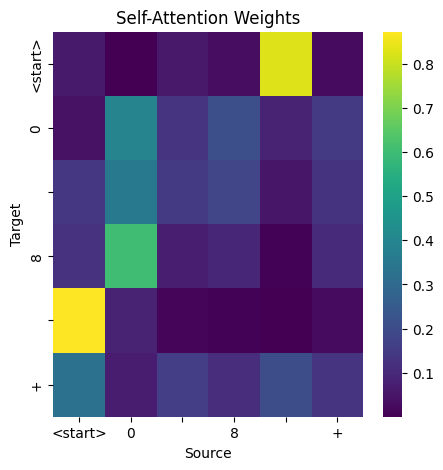

QV.shape: torch.Size([1, 6, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 6, 15])
AV.shape: torch.Size([1, 6, 4])
multi_attention: 
[[9.38162301e-03 8.87443870e-02 1.93575919e-01 1.41296923e-01
  3.40255685e-02 3.70703079e-03 1.51072126e-02 3.62040140e-02
  1.64527833e-01 1.75967619e-01 4.94537950e-02 9.09114070e-03
  1.20243486e-02 2.35187896e-02 4.33737859e-02]
 [1.52029179e-05 1.29371285e-04 6.76572546e-02 1.94097753e-03
  3.56722713e-01 2.12052483e-02 2.38124002e-02 7.57117243e-03
  3.93540263e-02 1.26777112e-03 3.55171919e-01 8.69191363e-02
  3.14969756e-02 6.71746861e-03 1.82989825e-05]
 [7.86533058e-01 1.87809858e-02 1.22582671e-04 2.02992163e-03
  2.15049848e-04 9.26075410e-03 2.78906687e-03 2.04841536e-03
  2.07271878e-04 2.21059006e-03 1.53093526e-04 1.49309123e-03
  2.92008487e-03 3.38627398e-03 1.67849675e-01]
 [4.19060700e-02 1.66562349e-02 3.03515680e-02 2.10676845e-02
  1.03021190e-01 1.79804325e-01 9.84799191e-02

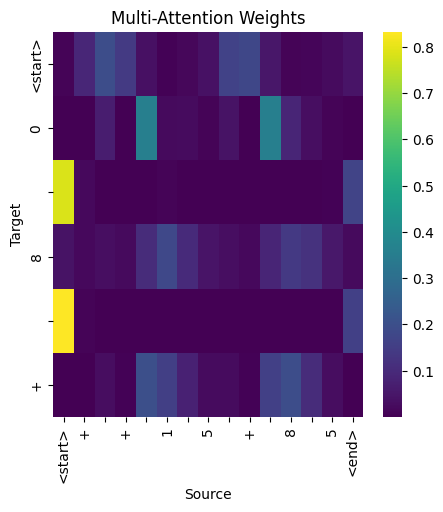

output.shape: torch.Size([1, 16])
output: tensor([[ -3.9400,   2.4814, -11.6728,   1.2025, -13.8637, -14.8920,  -3.1587,  -8.2547, -14.4291,
           1.8127,  -6.4486,  -6.4094,  -6.0348,  -4.0568,  -8.1390,  10.3301]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 15

------------------

iter: 6
ys: tensor([[12],
        [ 0],
        [15],
        [ 8],
        [15],
        [14],
        [15]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]],

        [[ 0.2872,  0.5951,  0.6541,  0.7773]],

        [[-0.6598, -0.4470,  0.0113,  1.0932]]], device='cuda:0')
now tgt: 0 8 + 
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -

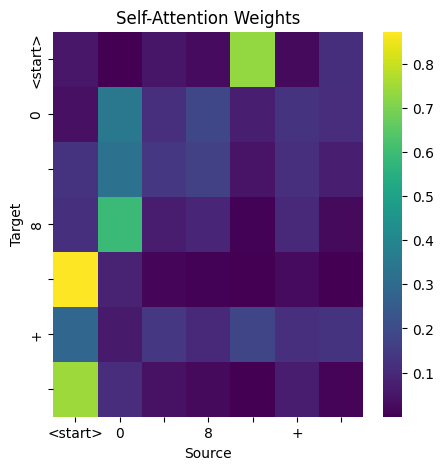

QV.shape: torch.Size([1, 7, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 7, 15])
AV.shape: torch.Size([1, 7, 4])
multi_attention: 
[[8.48762691e-03 8.36985931e-02 2.00524181e-01 1.38784304e-01
  3.58205736e-02 3.71855940e-03 1.52479252e-02 3.61472517e-02
  1.68986589e-01 1.71938762e-01 5.21387942e-02 9.34371166e-03
  1.21716307e-02 2.33958811e-02 3.95957045e-02]
 [1.28147640e-05 1.19372082e-04 6.95632845e-02 1.88164553e-03
  3.58499885e-01 1.93841998e-02 2.25696508e-02 7.24555226e-03
  3.99857871e-02 1.22872647e-03 3.60389501e-01 8.29736143e-02
  2.97850221e-02 6.34485809e-03 1.60941909e-05]
 [7.97645628e-01 1.66144241e-02 7.56174268e-05 1.53872033e-03
  1.21858400e-04 6.17997861e-03 1.84785423e-03 1.43165130e-03
  1.31970723e-04 1.71511516e-03 8.66468763e-05 9.15248529e-04
  1.90730800e-03 2.38859560e-03 1.67399317e-01]
 [4.36052568e-02 1.71894003e-02 3.03118546e-02 2.14471053e-02
  1.01665735e-01 1.79280788e-01 9.84635353e-02

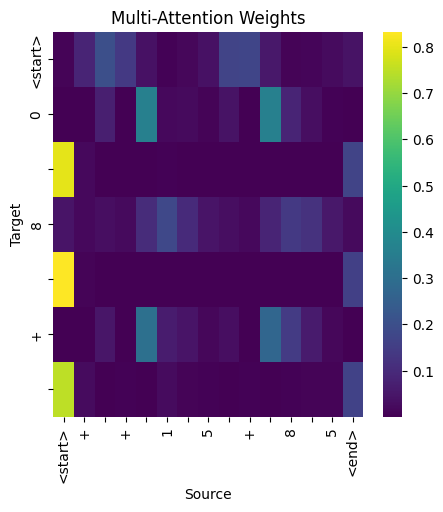

output.shape: torch.Size([1, 16])
output: tensor([[  6.0991,   4.3993,   6.1267,   5.0933,   6.7507,   6.9142,   4.9895,   5.7653,   6.9392,
           4.1277,  -3.6594,  -3.8236,  -3.6176,  -7.2467, -11.8382, -10.6870]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 8

------------------

iter: 7
ys: tensor([[12],
        [ 0],
        [15],
        [ 8],
        [15],
        [14],
        [15],
        [ 8]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]],

        [[ 0.2872,  0.5951,  0.6541,  0.7773]],

        [[-0.6598, -0.4470,  0.0113,  1.0932]],

        [[ 0.5932,  0.9839, -0.9952,  1.7531]]], device='cuda:0')
now tgt: 0 8 + 8
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

      

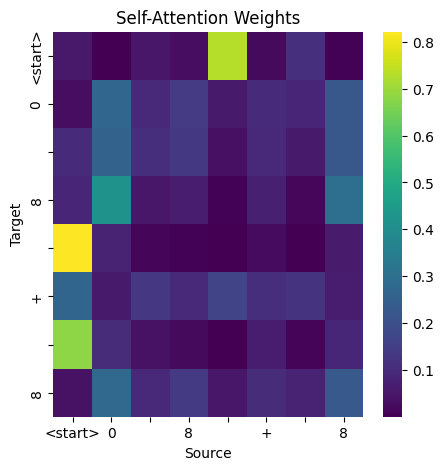

QV.shape: torch.Size([1, 8, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 8, 15])
AV.shape: torch.Size([1, 8, 4])
multi_attention: 
[[8.22454970e-03 8.21907595e-02 2.02665344e-01 1.38002768e-01
  3.63630913e-02 3.71685508e-03 1.52773522e-02 3.61033678e-02
  1.70339659e-01 1.70710400e-01 5.29582351e-02 9.41128470e-03
  1.22051556e-02 2.33384185e-02 3.84927988e-02]
 [1.60512100e-05 1.32294881e-04 6.68546706e-02 1.95354689e-03
  3.56205463e-01 2.18907390e-02 2.42431145e-02 7.67231779e-03
  3.90398018e-02 1.27549167e-03 3.53354245e-01 8.83990675e-02
  3.21038477e-02 6.84029190e-03 1.90124483e-05]
 [7.69820750e-01 2.15078145e-02 1.97149260e-04 2.69520190e-03
  3.64244916e-04 1.30578093e-02 4.04701941e-03 2.86349235e-03
  3.23110056e-04 2.88299238e-03 2.61050969e-04 2.30463059e-03
  4.27840929e-03 4.66452958e-03 1.70731857e-01]
 [3.14210095e-02 1.44890947e-02 3.37519683e-02 2.04343572e-02
  1.14955895e-01 1.70315549e-01 9.74783078e-02

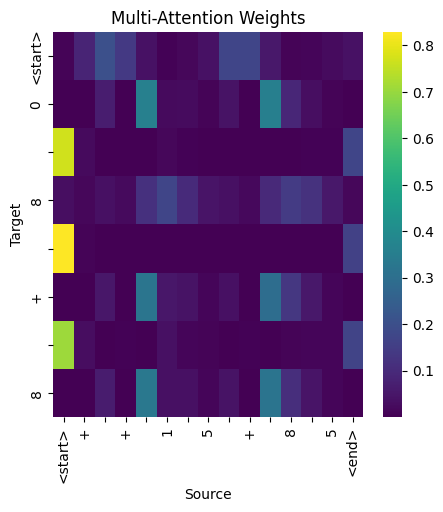

output.shape: torch.Size([1, 16])
output: tensor([[ -3.4212,   1.8422, -12.1780,   1.0055, -13.7691, -14.3450,  -4.1630,  -8.9968, -13.7878,
           0.9777,  -6.2383,  -6.2408,  -5.8529,  -2.8096,  -8.2279,  10.0241]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 15

------------------

iter: 8
ys: tensor([[12],
        [ 0],
        [15],
        [ 8],
        [15],
        [14],
        [15],
        [ 8],
        [15]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]],

        [[ 0.2872,  0.5951,  0.6541,  0.7773]],

        [[-0.6598, -0.4470,  0.0113,  1.0932]],

        [[ 0.5932,  0.9839, -0.9952,  1.7531]],

        [[ 0.6090, -1.5526,  0.0313,  1.0918]]], device='cuda:0')
now tgt: 0 8 + 8 
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1

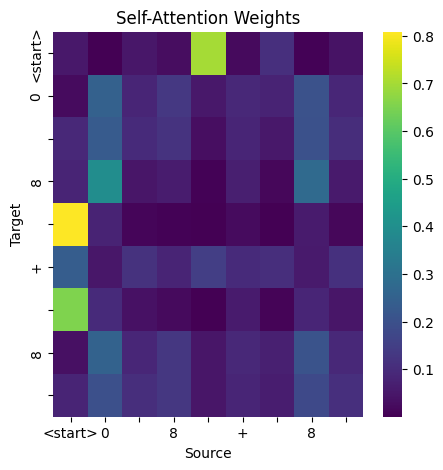

QV.shape: torch.Size([1, 9, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 9, 15])
AV.shape: torch.Size([1, 9, 4])
multi_attention: 
[[6.80302130e-03 7.36090988e-02 2.15260595e-01 1.33131087e-01
  3.96169163e-02 3.69091751e-03 1.53978486e-02 3.57229076e-02
  1.78106338e-01 1.63223431e-01 5.78986108e-02 9.78224166e-03
  1.23604853e-02 2.29194723e-02 3.24770249e-02]
 [1.47922801e-05 1.27958541e-04 6.80822730e-02 1.93523197e-03
  3.56960237e-01 2.08606701e-02 2.35952307e-02 7.52097229e-03
  3.95227112e-02 1.26432092e-03 3.56089503e-01 8.61617476e-02
  3.11901551e-02 6.65620947e-03 1.79535709e-05]
 [7.75004625e-01 2.06448529e-02 1.60289841e-04 2.41271663e-03
  2.80489068e-04 1.06684286e-02 3.33542516e-03 2.43532495e-03
  2.66354880e-04 2.61429278e-03 2.01523013e-04 1.82094832e-03
  3.49611230e-03 3.97097180e-03 1.72687620e-01]
 [3.19630764e-02 1.49410954e-02 3.43983620e-02 2.09954567e-02
  1.14764661e-01 1.67877108e-01 9.73652080e-02

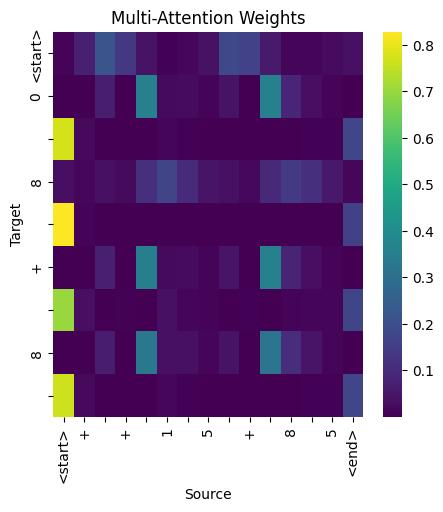

output.shape: torch.Size([1, 16])
output: tensor([[  5.3342,   3.8960,   2.6832,   4.7131,   3.3905,   3.8407,   2.9145,   2.7588,   4.0616,
           3.4864,  -4.3638,  -4.5660,  -4.3018,  -6.0267, -13.1827,  -8.1613]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 0

------------------

iter: 9
ys: tensor([[12],
        [ 0],
        [15],
        [ 8],
        [15],
        [14],
        [15],
        [ 8],
        [15],
        [ 0]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]],

        [[ 0.2872,  0.5951,  0.6541,  0.7773]],

        [[-0.6598, -0.4470,  0.0113,  1.0932]],

        [[ 0.5932,  0.9839, -0.9952,  1.7531]],

        [[ 0.6090, -1.5526,  0.0313,  1.0918]],

        [[ 0.1976, -0.0687, -1.0700,  1.7832]]], device='cuda:0')
now tg

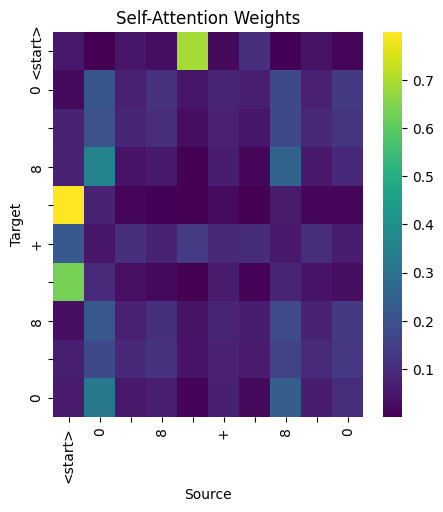

QV.shape: torch.Size([1, 10, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 10, 15])
AV.shape: torch.Size([1, 10, 4])
multi_attention: 
[[6.15477981e-03 6.93663433e-02 2.21707508e-01 1.30404398e-01
  4.13738824e-02 3.67537513e-03 1.54442005e-02 3.54776420e-02
  1.81951135e-01 1.59125283e-01 6.05685189e-02 9.97320469e-03
  1.24297189e-02 2.26762220e-02 2.96717174e-02]
 [1.27759931e-05 1.19390497e-04 6.96992055e-02 1.88370550e-03
  3.58470559e-01 1.93205159e-02 2.25364696e-02 7.24206073e-03
  4.00527604e-02 1.23035372e-03 3.60533118e-01 8.28112662e-02
  2.97335051e-02 6.33817073e-03 1.60778345e-05]
 [7.66838551e-01 2.19698306e-02 1.90253559e-04 2.69767456e-03
  3.31084710e-04 1.16014201e-02 3.72427166e-03 2.71451124e-03
  3.12643679e-04 2.91545782e-03 2.39437024e-04 2.05547828e-03
  3.90445348e-03 4.38444084e-03 1.76120520e-01]
 [2.87588499e-02 1.44713521e-02 3.64771932e-02 2.11987980e-02
  1.19606242e-01 1.61656410e-01 9.66250151e

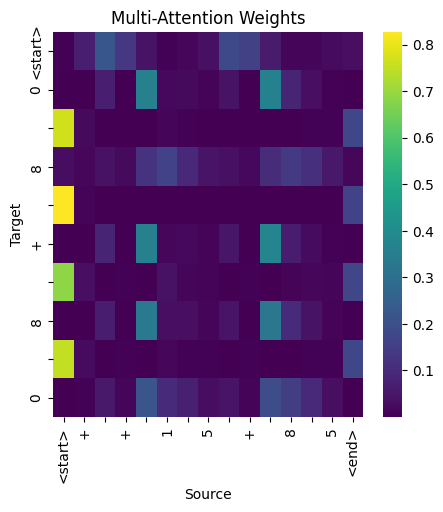

output.shape: torch.Size([1, 16])
output: tensor([[ -4.2597,   1.9562, -12.4056,   0.7716, -14.4414, -15.3603,  -3.9150,  -8.9816, -14.8653,
           1.1405,  -6.2223,  -6.1762,  -5.8005,  -3.2210,  -7.0819,  11.2044]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 15

------------------

iter: 10
ys: tensor([[12],
        [ 0],
        [15],
        [ 8],
        [15],
        [14],
        [15],
        [ 8],
        [15],
        [ 0],
        [15]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]],

        [[ 0.2872,  0.5951,  0.6541,  0.7773]],

        [[-0.6598, -0.4470,  0.0113,  1.0932]],

        [[ 0.5932,  0.9839, -0.9952,  1.7531]],

        [[ 0.6090, -1.5526,  0.0313,  1.0918]],

        [[ 0.1976, -0.0687, -1.0700,  1.7832]],

       

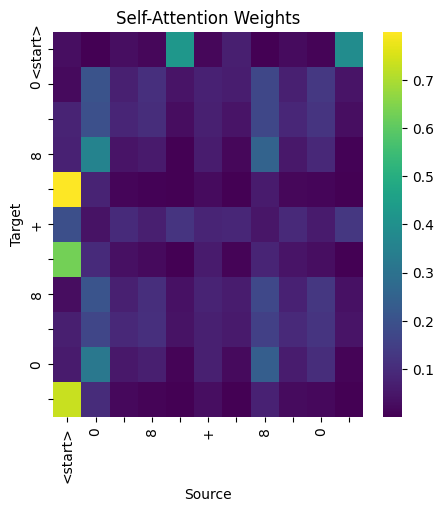

QV.shape: torch.Size([1, 11, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 11, 15])
AV.shape: torch.Size([1, 11, 4])
multi_attention: 
[[8.05621035e-03 8.15346688e-02 2.03925267e-01 1.37855813e-01
  3.64405736e-02 3.66889453e-03 1.51826832e-02 3.59016247e-02
  1.71120077e-01 1.70556292e-01 5.31549826e-02 9.34685208e-03
  1.21249789e-02 2.31627636e-02 3.79682742e-02]
 [1.08811573e-05 1.11017856e-04 7.16983080e-02 1.83462608e-03
  3.59777302e-01 1.76934134e-02 2.13982128e-02 6.95067178e-03
  4.07415666e-02 1.19859271e-03 3.65342975e-01 7.90644810e-02
  2.81588230e-02 6.00489834e-03 1.42845120e-05]
 [7.74718881e-01 2.05387529e-02 1.42777979e-04 2.29658419e-03
  2.34602339e-04 9.02707037e-03 2.89828586e-03 2.18783459e-03
  2.39128189e-04 2.51946854e-03 1.69730367e-04 1.52188924e-03
  3.01002781e-03 3.54934367e-03 1.76945582e-01]
 [2.89193206e-02 1.45633770e-02 3.65532488e-02 2.12987810e-02
  1.19452767e-01 1.61371261e-01 9.66201350e

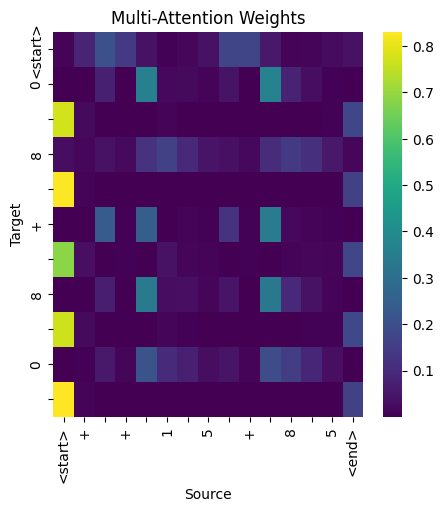

output.shape: torch.Size([1, 16])
output: tensor([[-1.0083, -4.1102,  0.5564, -3.1373,  2.4255,  2.7220, -3.1896, -0.0533,  2.6106, -6.7121,
          2.8158,  3.0651,  3.0853,  4.3097, 16.7488,  3.5989]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 14

------------------

iter: 11
ys: tensor([[12],
        [ 0],
        [15],
        [ 8],
        [15],
        [14],
        [15],
        [ 8],
        [15],
        [ 0],
        [15],
        [14]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]],

        [[ 0.2872,  0.5951,  0.6541,  0.7773]],

        [[-0.6598, -0.4470,  0.0113,  1.0932]],

        [[ 0.5932,  0.9839, -0.9952,  1.7531]],

        [[ 0.6090, -1.5526,  0.0313,  1.0918]],

        [[ 0.1976, -0.0687, -1.0700,  1.7832]],

        [

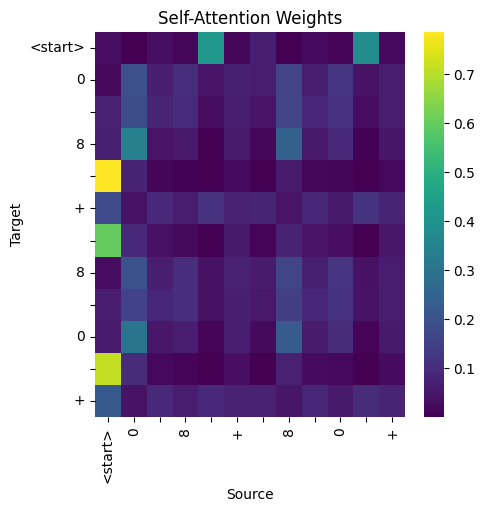

QV.shape: torch.Size([1, 12, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 12, 15])
AV.shape: torch.Size([1, 12, 4])
multi_attention: 
[[7.89691415e-03 8.05644318e-02 2.05288321e-01 1.37314096e-01
  3.68118621e-02 3.67202167e-03 1.52107151e-02 3.58869247e-02
  1.71974719e-01 1.69703409e-01 5.37091792e-02 9.39913653e-03
  1.21547850e-02 2.31377315e-02 3.72757278e-02]
 [1.22248412e-05 1.17168755e-04 7.03230500e-02 1.87244872e-03
  3.58808517e-01 1.88361593e-02 2.22103838e-02 7.16264406e-03
  4.02846225e-02 1.22329290e-03 3.61911446e-01 8.16998854e-02
  2.92777643e-02 6.24483032e-03 1.55785656e-05]
 [7.84559488e-01 1.87703371e-02 1.05874467e-04 1.91527221e-03
  1.69517196e-04 7.34715816e-03 2.30699196e-03 1.77698594e-03
  1.80814110e-04 2.12263502e-03 1.21993202e-04 1.16899854e-03
  2.38356297e-03 2.91277142e-03 1.74157575e-01]
 [3.35972086e-02 1.58308614e-02 3.50777805e-02 2.19231397e-02
  1.13425396e-01 1.65029034e-01 9.72770527e

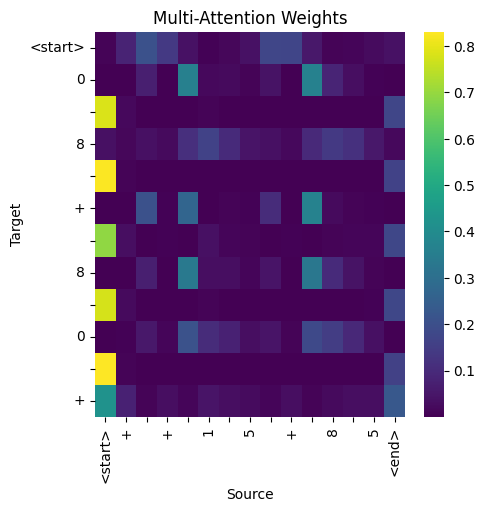

output.shape: torch.Size([1, 16])
output: tensor([[ -4.0573,   1.8860, -12.4132,   0.8035, -14.3164, -15.1326,  -4.0464,  -9.0526, -14.6174,
           1.0460,  -6.2149,  -6.1817,  -5.8023,  -3.0442,  -7.3287,  10.9568]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 15

------------------

iter: 12
ys: tensor([[12],
        [ 0],
        [15],
        [ 8],
        [15],
        [14],
        [15],
        [ 8],
        [15],
        [ 0],
        [15],
        [14],
        [15]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]],

        [[ 0.2872,  0.5951,  0.6541,  0.7773]],

        [[-0.6598, -0.4470,  0.0113,  1.0932]],

        [[ 0.5932,  0.9839, -0.9952,  1.7531]],

        [[ 0.6090, -1.5526,  0.0313,  1.0918]],

        [[ 0.1976, -0.0687, 

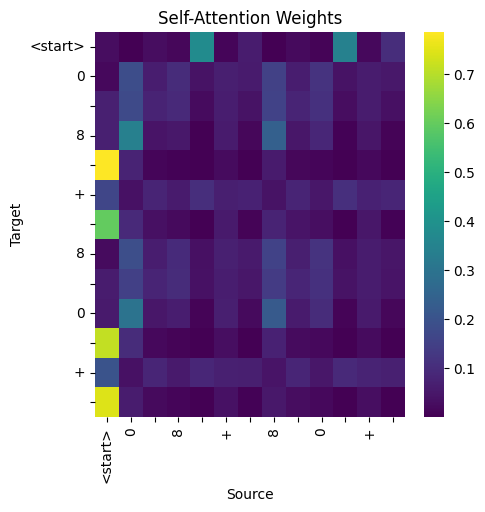

QV.shape: torch.Size([1, 13, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 13, 15])
AV.shape: torch.Size([1, 13, 4])
multi_attention: 
[[8.13129265e-03 8.18220973e-02 2.03362957e-01 1.37914568e-01
  3.64115424e-02 3.69130494e-03 1.52274184e-02 3.59958299e-02
  1.70772433e-01 1.70612589e-01 5.30737154e-02 9.37797315e-03
  1.21629676e-02 2.32443996e-02 3.81988958e-02]
 [1.11085874e-05 1.12052883e-04 7.14334548e-02 1.84072892e-03
  3.59626293e-01 1.78973544e-02 2.15428472e-02 6.98754890e-03
  4.06499021e-02 1.20252301e-03 3.64730537e-01 7.95452446e-02
  2.83590220e-02 6.04695734e-03 1.45027743e-05]
 [7.90579557e-01 1.74975581e-02 8.05296222e-05 1.63625227e-03
  1.23002916e-04 5.85158588e-03 1.82873069e-03 1.45124365e-03
  1.40012999e-04 1.83715869e-03 8.84451583e-05 8.87212052e-04
  1.87450065e-03 2.39163078e-03 1.73732534e-01]
 [3.42116728e-02 1.60554405e-02 3.50546204e-02 2.20974647e-02
  1.12781852e-01 1.64913282e-01 9.73037854e

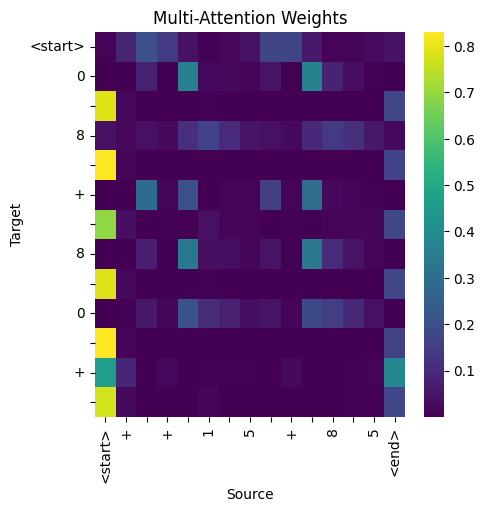

output.shape: torch.Size([1, 16])
output: tensor([[ 0.6299, -4.5865,  1.5176, -2.8952,  4.3552,  5.3205, -3.6135,  0.2974,  5.2946, -7.3559,
          3.1843,  3.3555,  3.3822,  5.3871, 15.7510,  1.1676]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 14

------------------

iter: 13
ys: tensor([[12],
        [ 0],
        [15],
        [ 8],
        [15],
        [14],
        [15],
        [ 8],
        [15],
        [ 0],
        [15],
        [14],
        [15],
        [14]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]],

        [[ 0.2872,  0.5951,  0.6541,  0.7773]],

        [[-0.6598, -0.4470,  0.0113,  1.0932]],

        [[ 0.5932,  0.9839, -0.9952,  1.7531]],

        [[ 0.6090, -1.5526,  0.0313,  1.0918]],

        [[ 0.1976, -0.0687, -1

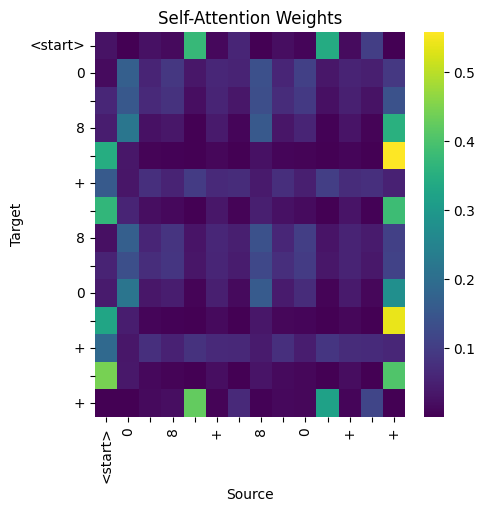

QV.shape: torch.Size([1, 14, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 14, 15])
AV.shape: torch.Size([1, 14, 4])
multi_attention: 
[[8.08422547e-03 8.15458149e-02 2.03756735e-01 1.37766719e-01
  3.65130268e-02 3.69116967e-03 1.52331162e-02 3.59879285e-02
  1.71019837e-01 1.70380920e-01 5.32267690e-02 9.39078908e-03
  1.21694235e-02 2.32341383e-02 3.79993878e-02]
 [1.81176965e-05 1.41322351e-04 6.60792366e-02 2.01555085e-03
  3.54444623e-01 2.30954178e-02 2.50983890e-02 7.92678632e-03
  3.88982482e-02 1.31798873e-03 3.49844962e-01 9.07314122e-02
  3.32478210e-02 7.11921789e-03 2.09745067e-05]
 [7.85676241e-01 1.89453922e-02 1.27762643e-04 2.07607704e-03
  2.26449469e-04 9.63441562e-03 2.89759692e-03 2.11541448e-03
  2.15439664e-04 2.25526746e-03 1.61144038e-04 1.56384532e-03
  3.03865154e-03 3.49603267e-03 1.67570278e-01]
 [6.82303458e-02 1.99096333e-02 2.33246721e-02 2.06336845e-02
  8.20142031e-02 2.00558767e-01 9.83147547e

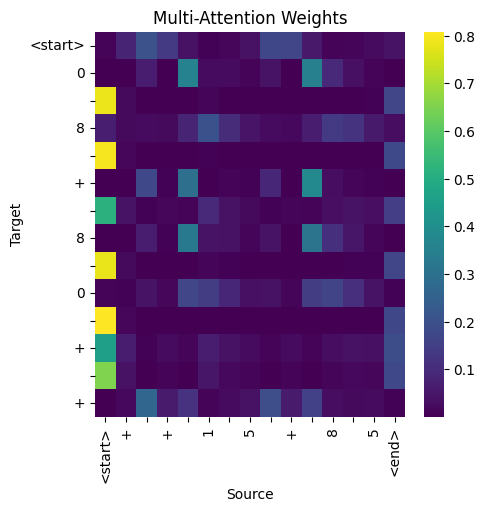

output.shape: torch.Size([1, 16])
output: tensor([[  2.8030,  -6.4619,  -8.9447,  -2.5182,  -3.5361,   0.2332, -11.6836,  -9.9150,   1.2252,
          -9.8385,   0.2851,   0.0437,   0.3487,  11.1571,   3.4062,   2.9094]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 13

------------------

Input: + + 1 5 + 8 5
Decoded sequence: 0 8 + 8 0 + +


In [45]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '+ + 1 5 + 8 5'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    self_attn_weights_np = self_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"self_attention: \n{self_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = tgt_tokens_
    print(f"tgt_tokens: {tgt_tokens_}")
    # Self-Attentionの可視化
    visualize_attention(self_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    multi_attn_weights_np = multi_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"multi_attention: \n{multi_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)
    print(f"After Attention: {tgt}")
    # Memory-Attentionの可視化
    visualize_attention(multi_attn_weights_np, src_tokens_, tgt_tokens_, title="Multi-Attention Weights")

    # LayerNorm
    output = tgt.transpose(0, 1)
    output = loaded_model.output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

## TGTのベクトル移動を観察

tensor([[-0.1073,  0.4212],
        [-0.1203,  0.3706],
        [-0.0088, -0.0817],
        [-0.1179,  0.3986],
        [-0.0040, -0.0606],
        [-0.0203,  0.0508],
        [-0.0769,  0.1760],
        [-0.0359,  0.0170],
        [-0.0319,  0.1150],
        [-0.1169,  0.3472],
        [ 0.4200,  0.1659],
        [-0.4565, -0.2794],
        [ 0.6764,  0.5097],
        [ 0.5024,  0.4531],
        [ 0.6230,  0.1557],
        [-0.1902, -0.7036]])


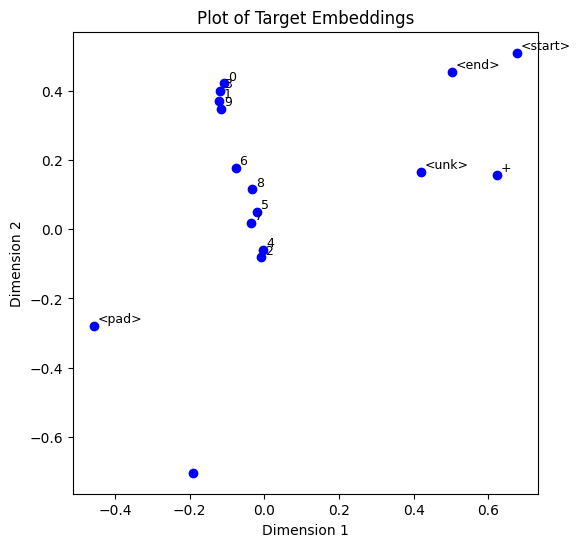

In [38]:
import numpy as np
embedding_cpu_01dim = embedding_weight.cpu().detach()[: , :2]
print(embedding_cpu_01dim)

reverse_vocab_src = {idx: token for token, idx in vocab_src.items()}
reverse_vocab_tgt = {idx: token for token, idx in vocab_tgt.items()}

def plot_embedding_tgt_2d(ys=None, tgt_embed=None, src=None, title="Target Embeddings"):
    plt.figure(figsize=(6, 6))

    # 事前Embedding
    for i, (x, y) in enumerate(embedding_cpu_01dim):
        label = reverse_vocab_src[i]
        plt.scatter(x, y, color='blue')
        plt.text(x + 0.01, y + 0.01, label, fontsize=9) 

    if tgt_embed is not None:
        tgt_embed = tgt_embed.detach().cpu().numpy()
        print(tgt_embed)
        print(tgt_embed.shape)
        if len(tgt_embed.shape) > 2:
            if tgt_embed.shape[0] == 1:
                tgt_embed = np.squeeze(tgt_embed, axis=0)
            elif tgt_embed.shape[1] == 1:
                tgt_embed = np.squeeze(tgt_embed, axis=1)
        tgt_embed_2d = tgt_embed[:, :2]
        print(tgt_embed_2d)
        for i, (x, y) in enumerate(tgt_embed_2d):
            if src is not None:
                label = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)[i] + f"({i})"
            else:
                label = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)[i] + f"({i})"
            plt.scatter(x, y, color='green', s=100, marker='x')
            plt.text(x + 0.01, y + 0.01, str(i)+label, fontsize=9)

    plt.title(f"Plot of {title}")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()


plot_embedding_tgt_2d()

text: + + 1 5 + 8 5
memory: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 2.0876,  0.8517,  0.6141,  0.7785]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 1.3872, -0.6786,  0.6341,  0.7781]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]],

        [[-1.1995,  1.0248, -0.9498,  1.1930]],

        [[-0.6598, -0.4470,  0.0113,  1.0932]],

        [[ 0.6163,  0.8555, -0.9246,  1.5433]],

        [[ 0.6090, -1.5526,  0.0313,  1.0918]],

        [[ 1.6582, -0.5997,  0.6940,  0.7745]],

        [[-0.9244, -2.2462,  0.0512,  1.0900]],

        [[-1.0638,  0.2344, -0.9554,  1.7495]],

        [[-0.9170, -0.5633,  0.0711,  1.0878]],

        [[ 0.3795,  1.0091, -0.8649,  1.5373]],

        [[ 1.9954,  1.0429,  1.2897, -0.2614]]], device='cuda:0')
memory_size: torch.Size([15, 1, 4])

------------------

iter: 0
ys: tensor([[12]], device='cuda:0')
tgt_embed: tensor([[[1.3527, 2.0195, 1.8225, 1.8424]]], device='cuda:0')
now tgt: 
tgt_embed: tensor([[[1.3527, 2.0195,

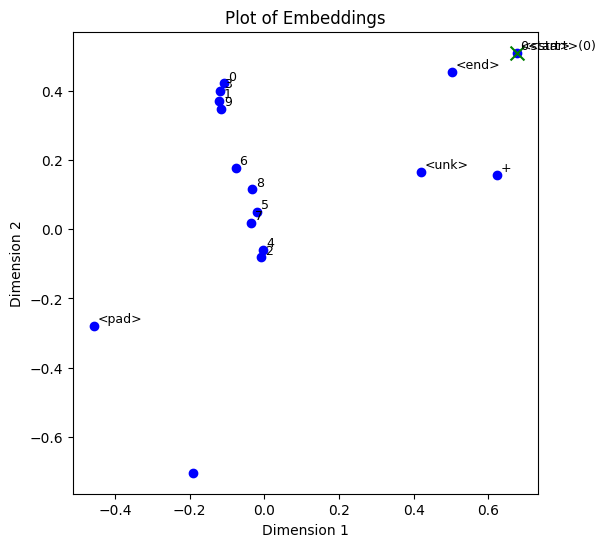

[[[1.3527172 2.0194998 1.8224976 1.8423921]]]
(1, 1, 4)
[[1.3527172 2.0194998]]


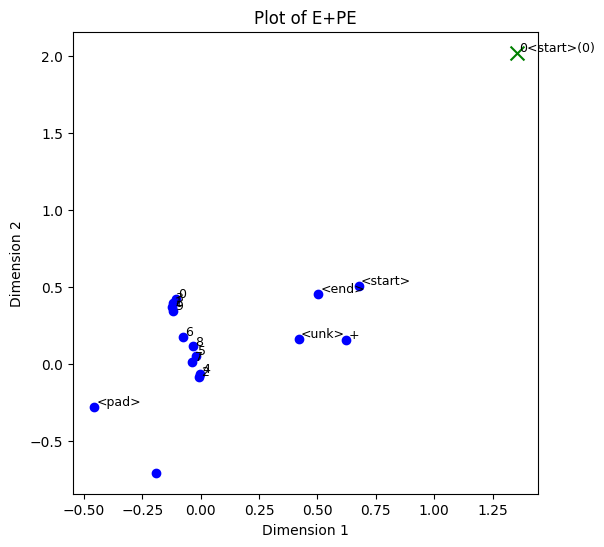

SelfAttention Layer
QV.shape: torch.Size([1, 1, 4])
KV.shape: torch.Size([1, 1, 4])
WV.shape: torch.Size([1, 1, 4])
attn_weight.shape: torch.Size([1, 1, 1])
AV.shape: torch.Size([1, 1, 4])
[[[ 2.239362   -1.1989362  -1.025545    0.31683794]]]
(1, 1, 4)
[[ 2.239362  -1.1989362]]


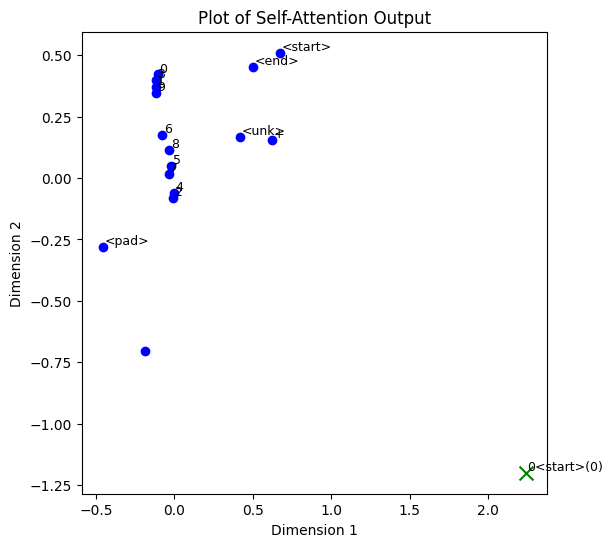

[[[ 1.0636609  -1.2244405  -0.9174212   0.34197605]]]
(1, 1, 4)
[[ 1.0636609 -1.2244405]]


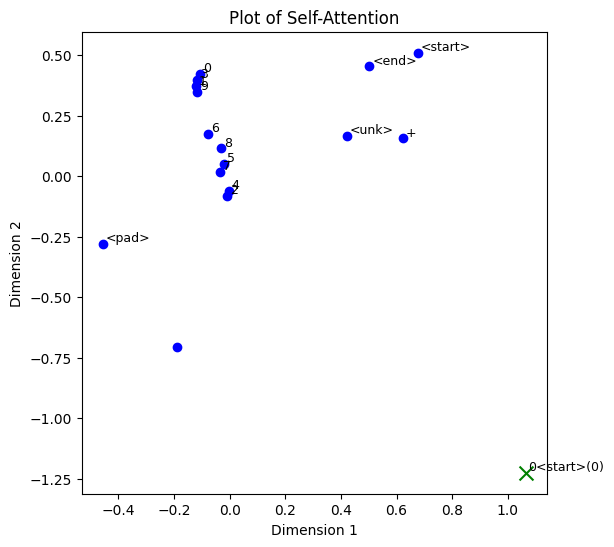

QV.shape: torch.Size([1, 1, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 1, 15])
AV.shape: torch.Size([1, 1, 4])
[[[-2.2273748   0.15993978 -0.490368   -1.6260974 ]]]
(1, 1, 4)
[[-2.2273748   0.15993978]]


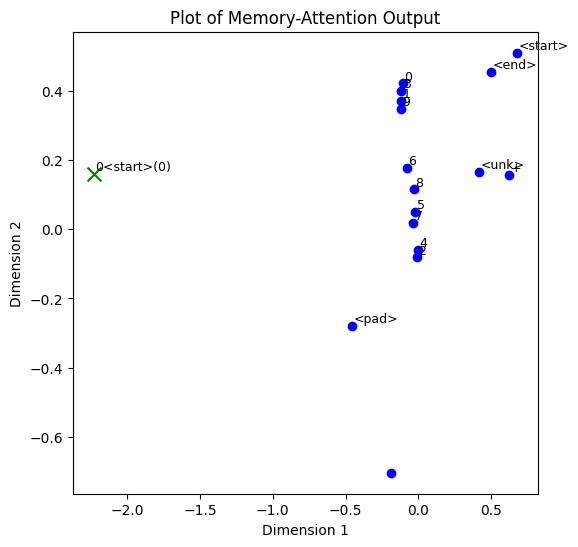

[[[ 1.357044    2.7517788  -4.3005767  -0.95494676]]]
(1, 1, 4)
[[1.357044  2.7517788]]


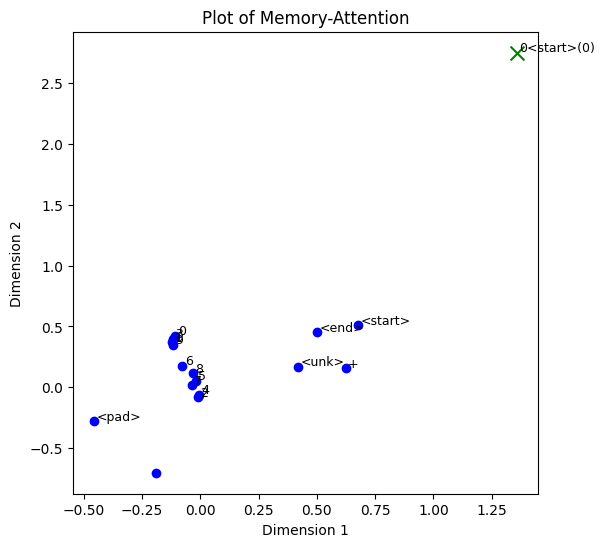

output.shape: torch.Size([1, 16])
output: tensor([[  5.6338,   3.6022,   2.5426,   4.6395,   3.5496,   4.2204,   2.4832,   2.4850,   4.4834,
           3.1016,  -4.2470,  -4.4699,  -4.2003,  -5.4518, -13.2377,  -8.4199]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 0

------------------

iter: 1
ys: tensor([[12],
        [ 0]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]]], device='cuda:0')
now tgt: 0
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]]], device='cuda:0')
[[[ 0.6763586   0.5097499   0.9112488   0.42119604]]

 [[-0.10726029  0.42120725 -0.57995427  0.39363354]]]
(2, 1, 4)
[[ 0.6763586   0.5097499 ]
 [-0.10726029  0.42120725]]


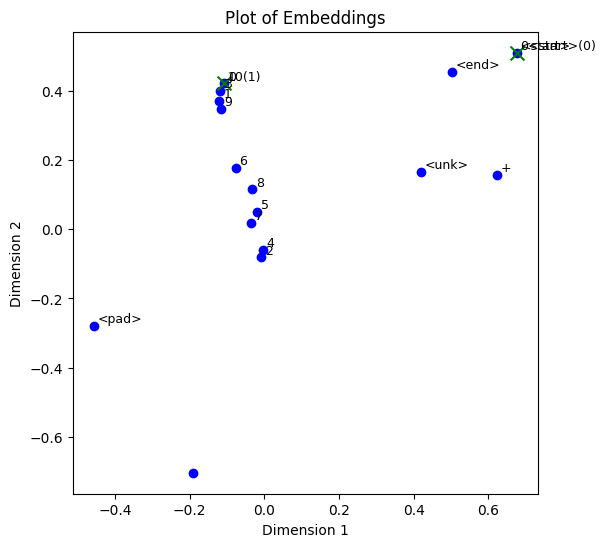

[[[ 1.3527172  2.0194998  1.8224976  1.8423921]]

 [[ 0.6269504  1.3827169 -1.1499087  1.7872171]]]
(2, 1, 4)
[[1.3527172 2.0194998]
 [0.6269504 1.3827169]]


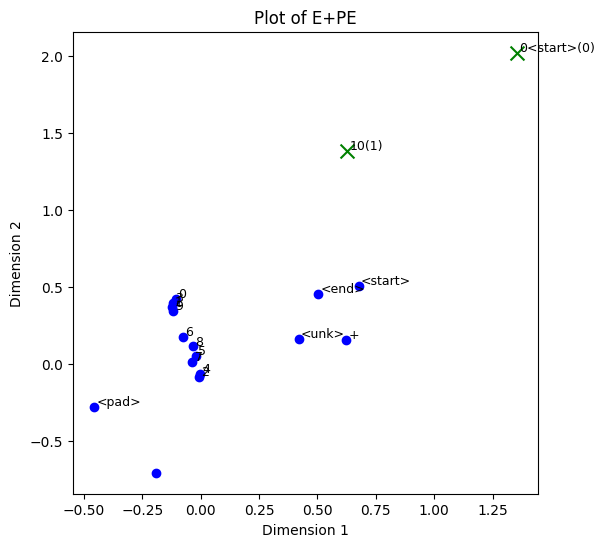

SelfAttention Layer
QV.shape: torch.Size([1, 2, 4])
KV.shape: torch.Size([1, 2, 4])
WV.shape: torch.Size([1, 2, 4])
attn_weight.shape: torch.Size([1, 2, 2])
AV.shape: torch.Size([1, 2, 4])
[[[ 2.15479    -1.1534603  -1.0821832   0.31085593]]

 [[ 0.26266068 -0.13602594 -2.349353    0.17702116]]]
(2, 1, 4)
[[ 2.15479    -1.1534603 ]
 [ 0.26266068 -0.13602594]]


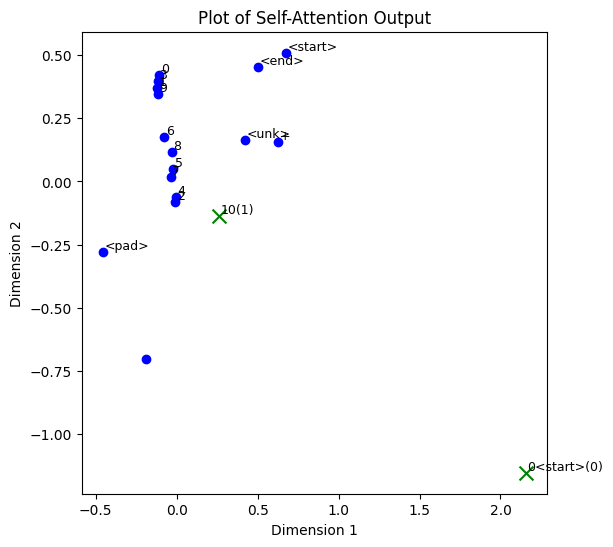

[[[ 1.0535611  -1.1746491  -0.97098607  0.36843517]]

 [[ 0.17144875  0.509263   -1.7469426   0.95955026]]]
(2, 1, 4)
[[ 1.0535611  -1.1746491 ]
 [ 0.17144875  0.509263  ]]


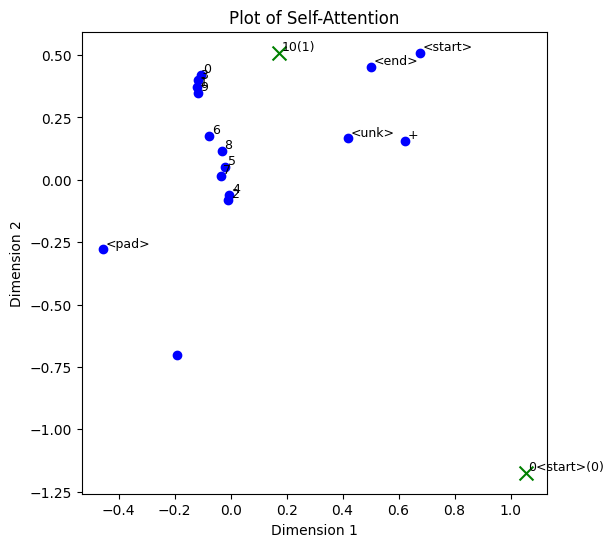

QV.shape: torch.Size([1, 2, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 2, 15])
AV.shape: torch.Size([1, 2, 4])
[[[-2.1768615   0.2607094  -0.3718645  -1.282943  ]]

 [[-1.6419615   0.46257955  0.22606412  1.2819862 ]]]
(2, 1, 4)
[[-2.1768615   0.2607094 ]
 [-1.6419615   0.46257955]]


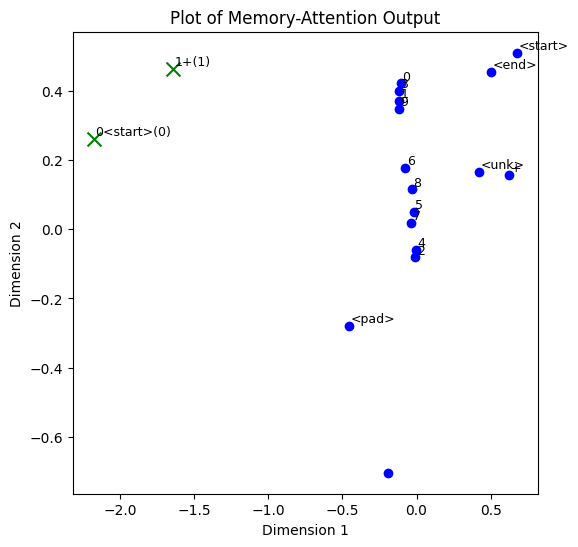

[[[-1.3929857  1.8003583 -4.6984806  2.703742 ]]

 [[-3.6936884  0.9762197 -3.1347604  3.9710484]]]
(2, 1, 4)
[[-1.3929857  1.8003583]
 [-3.6936884  0.9762197]]


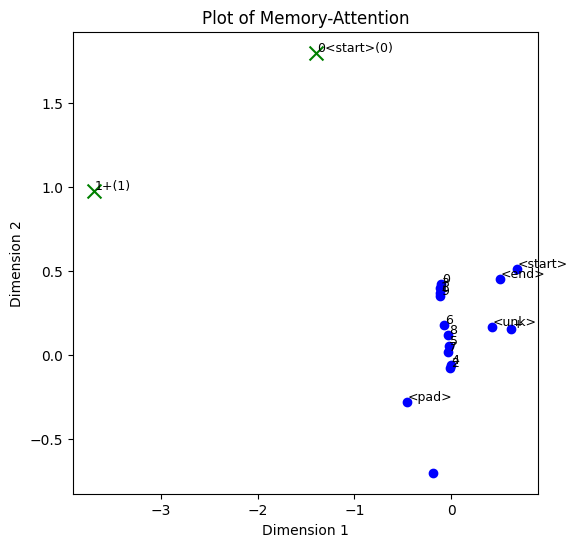

output.shape: torch.Size([1, 16])
output: tensor([[ -3.3507,   2.0495, -11.9077,   1.1551, -13.5856, -14.2249,  -3.8566,  -8.7144, -13.6841,
           1.2441,  -6.3218,  -6.3238,  -5.9372,  -3.1547,  -8.5549,   9.7613]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 15

------------------

iter: 2
ys: tensor([[12],
        [ 0],
        [15]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]]], device='cuda:0')
now tgt: 0 
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]]], device='cuda:0')
[[[ 0.6763586   0.5097499   0.9112488   0.42119604]]

 [[-0.10726029  0.42120725 -0.57995427  0.39363354]]

 [[-0.19019595 -0.70357054 -0.02431593  0.04751269]]]
(3, 1, 4)
[[ 0.6763586   0.5097499 ]
 [-0.10726029  0.42120725]
 [-0.19019595 -0.70357054]]


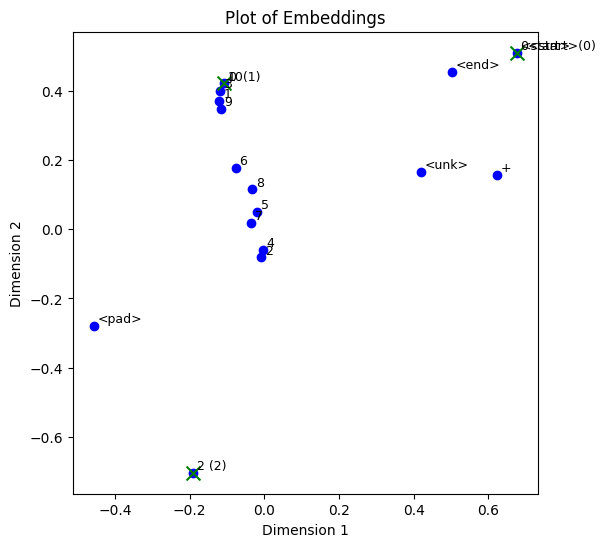

[[[ 1.3527172  2.0194998  1.8224976  1.8423921]]

 [[ 0.6269504  1.3827169 -1.1499087  1.7872171]]

 [[ 0.5289055 -1.823288  -0.0286332  1.0948254]]]
(3, 1, 4)
[[ 1.3527172  2.0194998]
 [ 0.6269504  1.3827169]
 [ 0.5289055 -1.823288 ]]


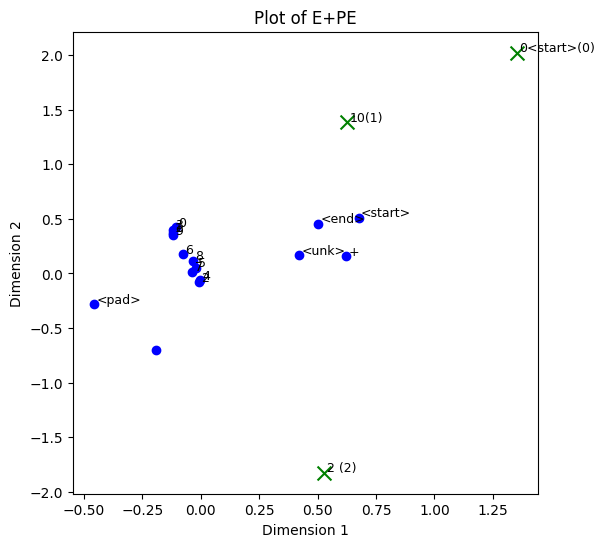

SelfAttention Layer
QV.shape: torch.Size([1, 3, 4])
KV.shape: torch.Size([1, 3, 4])
WV.shape: torch.Size([1, 3, 4])
attn_weight.shape: torch.Size([1, 3, 3])
AV.shape: torch.Size([1, 3, 4])
[[[ 0.8563918  -0.32583073 -0.78544354  0.08928573]]

 [[ 0.06825835  0.03223367 -1.9054325   0.09940922]]

 [[ 0.3842066  -0.13802609 -1.6971582   0.12212607]]]
(3, 1, 4)
[[ 0.8563918  -0.32583073]
 [ 0.06825835  0.03223367]
 [ 0.3842066  -0.13802609]]


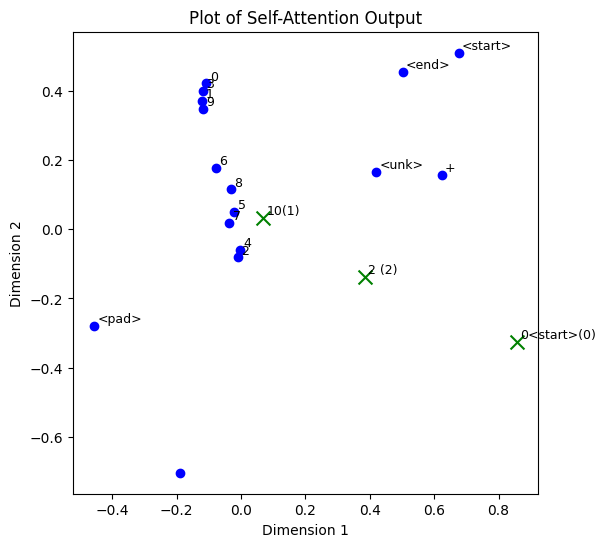

[[[ 0.77003366 -0.19396503 -1.6087792   0.5775704 ]]

 [[ 0.0888019   0.6259447  -1.7332376   0.96121764]]

 [[ 0.586377   -1.4581498  -0.9245998   1.2330242 ]]]
(3, 1, 4)
[[ 0.77003366 -0.19396503]
 [ 0.0888019   0.6259447 ]
 [ 0.586377   -1.4581498 ]]


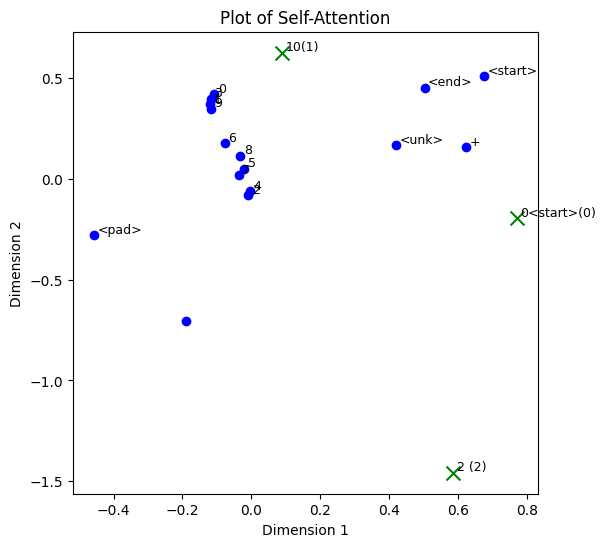

QV.shape: torch.Size([1, 3, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 3, 15])
AV.shape: torch.Size([1, 3, 4])
[[[-1.8596352   0.68043494  0.28590432  1.0162158 ]]

 [[-1.6129164   0.43643105  0.2185053   1.3101959 ]]

 [[-2.3717778  -0.32468218 -1.024965   -3.1337163 ]]]
(3, 1, 4)
[[-1.8596352   0.68043494]
 [-1.6129164   0.43643105]
 [-2.3717778  -0.32468218]]


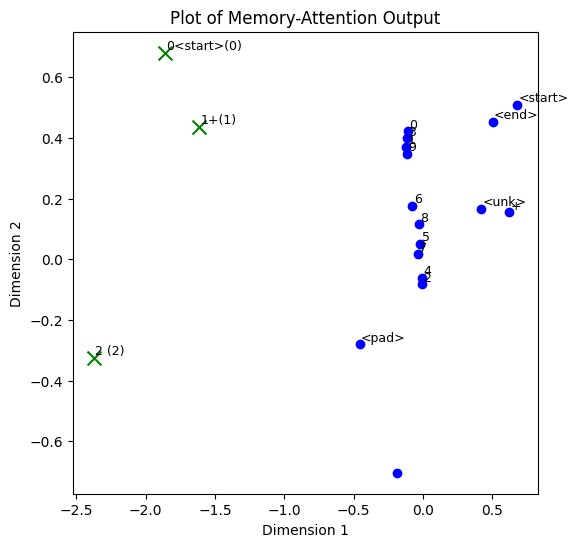

[[[-3.3451483   0.75417674 -3.3186662   4.1175265 ]]

 [[-3.7758532   1.0552248  -3.0968742   3.9118478 ]]

 [[ 2.8714824   2.01654    -4.088385   -1.5494391 ]]]
(3, 1, 4)
[[-3.3451483   0.75417674]
 [-3.7758532   1.0552248 ]
 [ 2.8714824   2.01654   ]]


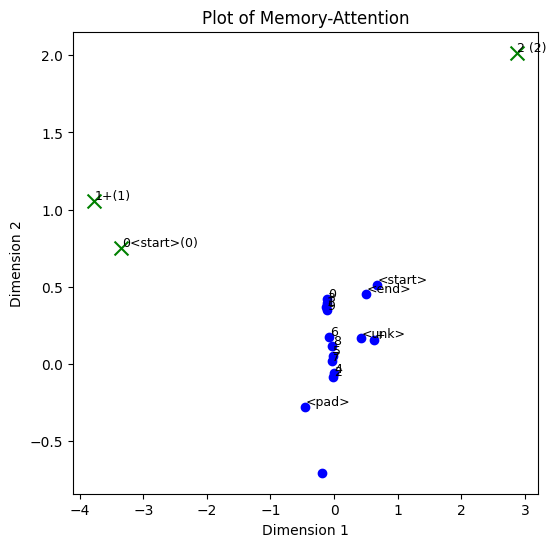

output.shape: torch.Size([1, 16])
output: tensor([[  6.1047,   4.4284,   6.2420,   5.1066,   6.8474,   6.9899,   5.0762,   5.8739,   7.0064,
           4.1653,  -3.6411,  -3.8028,  -3.5991,  -7.3128, -11.7827, -10.7484]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 8

------------------

iter: 3
ys: tensor([[12],
        [ 0],
        [15],
        [ 8]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]]], device='cuda:0')
now tgt: 0 8
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]]], device='cuda:0')
[[[ 0.6763586   0.5097499   0.9112488   0.42119604]]

 [[-0.10726029  0.42120725 -0.57995427  0.39363354]]

 [[-0.19019595 -0.70357054 -0.02431593 

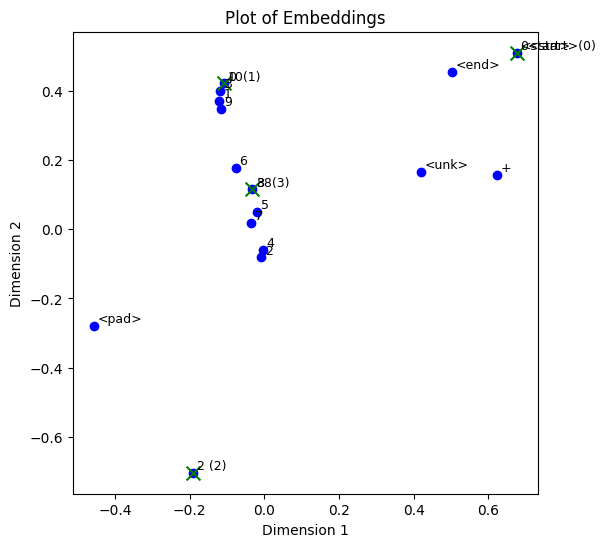

[[[ 1.3527172   2.0194998   1.8224976   1.8423921 ]]

 [[ 0.6269504   1.3827169  -1.1499087   1.7872171 ]]

 [[ 0.5289055  -1.823288   -0.0286332   1.0948254 ]]

 [[ 0.07733025 -0.7600116  -1.0351462   1.7550772 ]]]
(4, 1, 4)
[[ 1.3527172   2.0194998 ]
 [ 0.6269504   1.3827169 ]
 [ 0.5289055  -1.823288  ]
 [ 0.07733025 -0.7600116 ]]


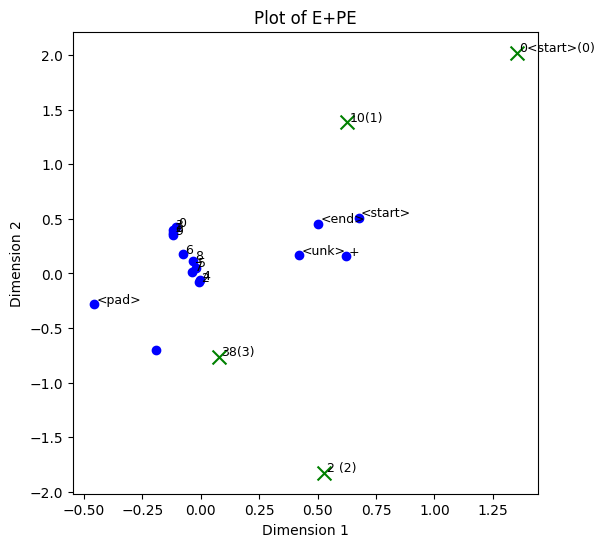

SelfAttention Layer
QV.shape: torch.Size([1, 4, 4])
KV.shape: torch.Size([1, 4, 4])
WV.shape: torch.Size([1, 4, 4])
attn_weight.shape: torch.Size([1, 4, 4])
AV.shape: torch.Size([1, 4, 4])
[[[ 0.5009904  -0.12694651 -0.8256607   0.01231838]]

 [[-0.19699419  0.20300207 -1.6580305  -0.0066948 ]]

 [[ 0.09540338  0.04054922 -1.5393932   0.02960419]]

 [[ 0.21275556 -0.06974205 -1.9613801   0.11120594]]]
(4, 1, 4)
[[ 0.5009904  -0.12694651]
 [-0.19699419  0.20300207]
 [ 0.09540338  0.04054922]
 [ 0.21275556 -0.06974205]]


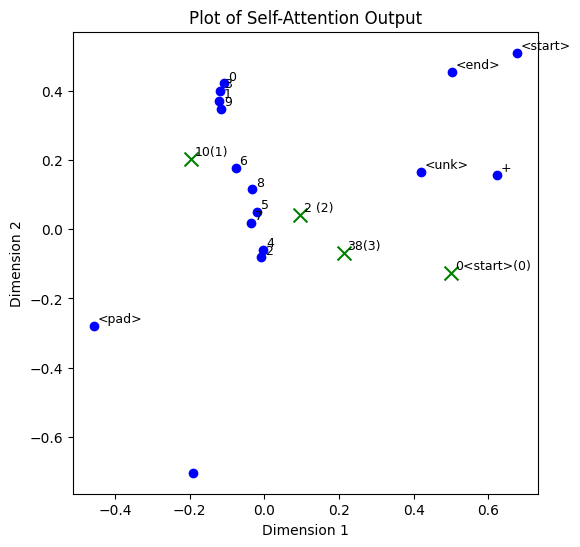

[[[ 0.32064164  0.67384964 -1.7750401   0.63259935]]

 [[-0.01497852  0.77765024 -1.7039355   0.9462493 ]]

 [[ 0.5128905  -1.4529222  -0.9146883   1.3228357 ]]

 [[ 0.21287532 -0.4132533  -1.489535    1.438728  ]]]
(4, 1, 4)
[[ 0.32064164  0.67384964]
 [-0.01497852  0.77765024]
 [ 0.5128905  -1.4529222 ]
 [ 0.21287532 -0.4132533 ]]


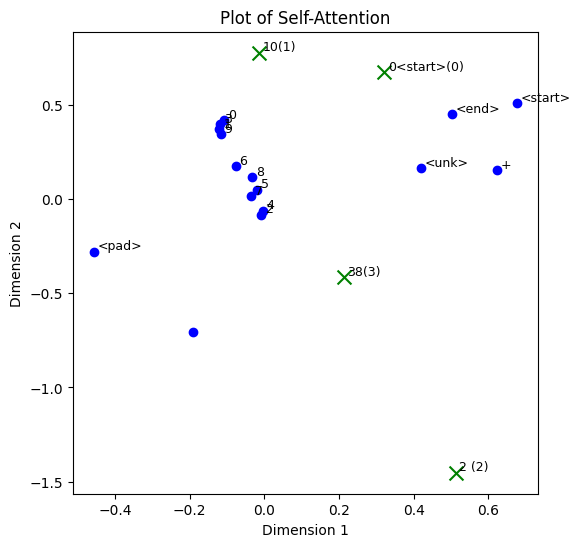

QV.shape: torch.Size([1, 4, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 4, 15])
AV.shape: torch.Size([1, 4, 4])
[[[-1.6316572   0.4412912   0.2406056   1.357334  ]]

 [[-1.5792087   0.40712488  0.20937216  1.3398421 ]]

 [[-2.351538   -0.34239632 -1.0384606  -3.1663969 ]]

 [[-1.7851899   0.59776646  0.12728289  0.5649298 ]]]
(4, 1, 4)
[[-1.6316572   0.4412912 ]
 [-1.5792087   0.40712488]
 [-2.351538   -0.34239632]
 [-1.7851899   0.59776646]]


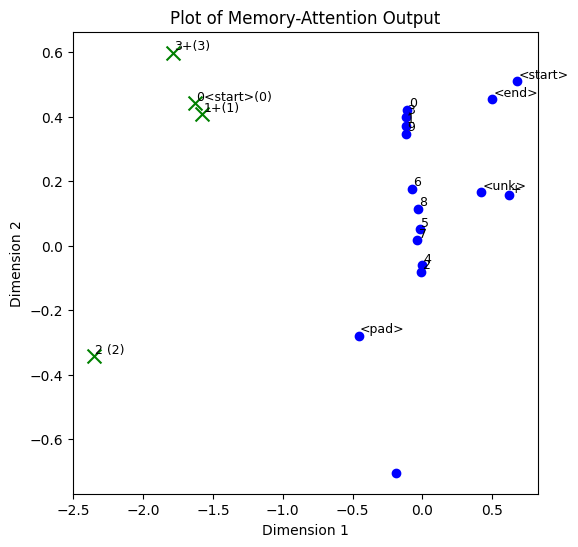

[[[-3.5531821   1.2801312  -3.351343    3.7254846 ]]

 [[-3.892119    1.1708845  -3.0397248   3.820331  ]]

 [[ 0.70412993  2.2173567  -5.0426188   0.8832874 ]]

 [[-3.7652996   0.2122588  -2.6820202   4.450535  ]]]
(4, 1, 4)
[[-3.5531821   1.2801312 ]
 [-3.892119    1.1708845 ]
 [ 0.70412993  2.2173567 ]
 [-3.7652996   0.2122588 ]]


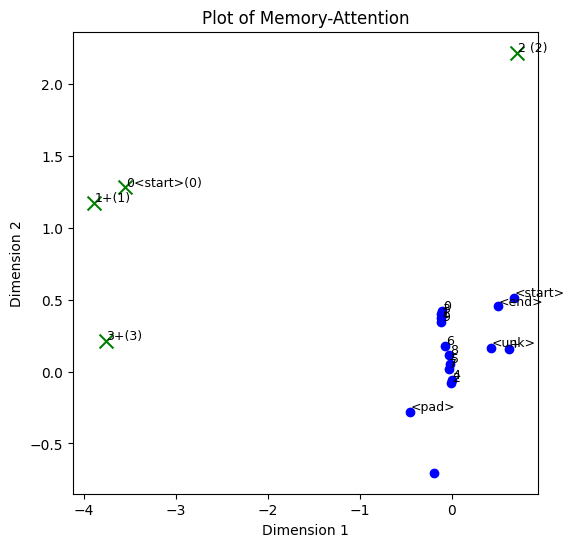

output.shape: torch.Size([1, 16])
output: tensor([[ -4.6756,   2.0868, -12.3694,   0.6950, -14.6716, -15.8007,  -3.6456,  -8.8215, -15.3487,
           1.3170,  -6.2187,  -6.1452,  -5.7780,  -3.5680,  -6.5165,  11.7090]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 15

------------------

iter: 4
ys: tensor([[12],
        [ 0],
        [15],
        [ 8],
        [15]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]]], device='cuda:0')
now tgt: 0 8 
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]]], device='cuda:0')
[[[ 0.6763586   0.5097499   0.911

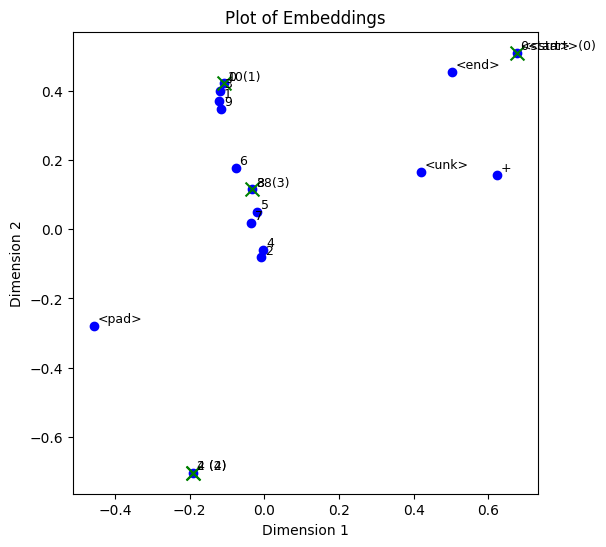

[[[ 1.3527172   2.0194998   1.8224976   1.8423921 ]]

 [[ 0.6269504   1.3827169  -1.1499087   1.7872171 ]]

 [[ 0.5289055  -1.823288   -0.0286332   1.0948254 ]]

 [[ 0.07733025 -0.7600116  -1.0351462   1.7550772 ]]

 [[-1.1371944  -2.0607848  -0.00864253  1.0942255 ]]]
(5, 1, 4)
[[ 1.3527172   2.0194998 ]
 [ 0.6269504   1.3827169 ]
 [ 0.5289055  -1.823288  ]
 [ 0.07733025 -0.7600116 ]
 [-1.1371944  -2.0607848 ]]


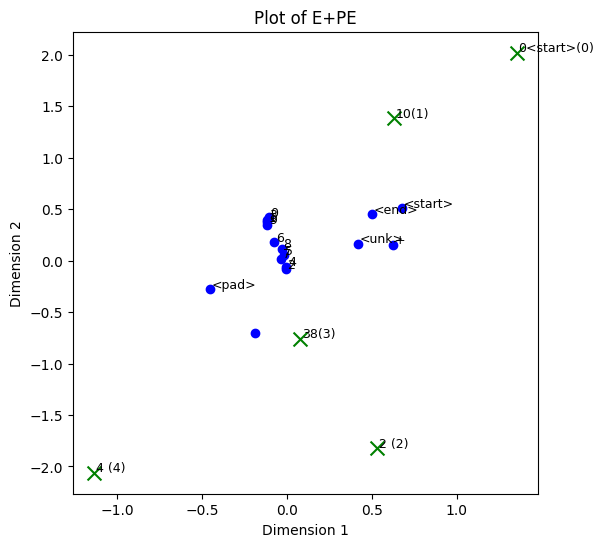

SelfAttention Layer
QV.shape: torch.Size([1, 5, 4])
KV.shape: torch.Size([1, 5, 4])
WV.shape: torch.Size([1, 5, 4])
attn_weight.shape: torch.Size([1, 5, 5])
AV.shape: torch.Size([1, 5, 4])
[[[-0.8759273   0.8233644   1.2565451  -0.63785243]]

 [[-0.28601032  0.27899227 -1.3423975  -0.0785069 ]]

 [[ 0.02835543  0.09299891 -1.3651143  -0.01352349]]

 [[ 0.20465827 -0.06329587 -1.939625    0.10596044]]

 [[ 1.9990369  -1.0653633  -1.1433127   0.29410163]]]
(5, 1, 4)
[[-0.8759273   0.8233644 ]
 [-0.28601032  0.27899227]
 [ 0.02835543  0.09299891]
 [ 0.20465827 -0.06329587]
 [ 1.9990369  -1.0653633 ]]


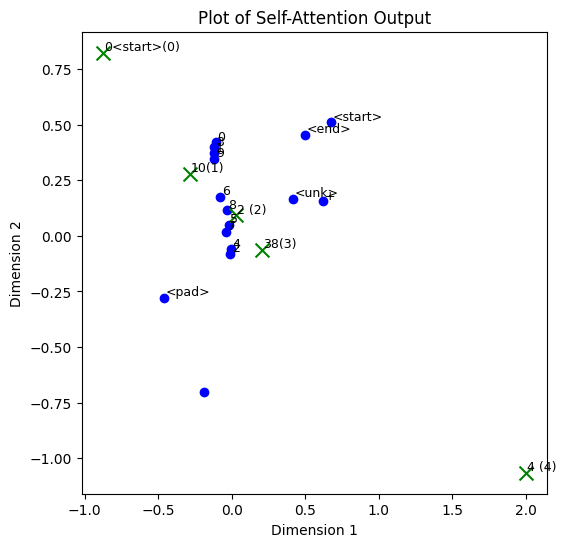

[[[-1.078593    0.9419492   1.1527599  -0.6437629 ]]

 [[-0.07442607  0.8608376  -1.6805164   0.93403786]]

 [[ 0.49169338 -1.5151514  -0.8508855   1.3411849 ]]

 [[ 0.20964022 -0.41309965 -1.488161    1.4417764 ]]

 [[ 0.49170142 -1.9428117  -0.34718588  1.192218  ]]]
(5, 1, 4)
[[-1.078593    0.9419492 ]
 [-0.07442607  0.8608376 ]
 [ 0.49169338 -1.5151514 ]
 [ 0.20964022 -0.41309965]
 [ 0.49170142 -1.9428117 ]]


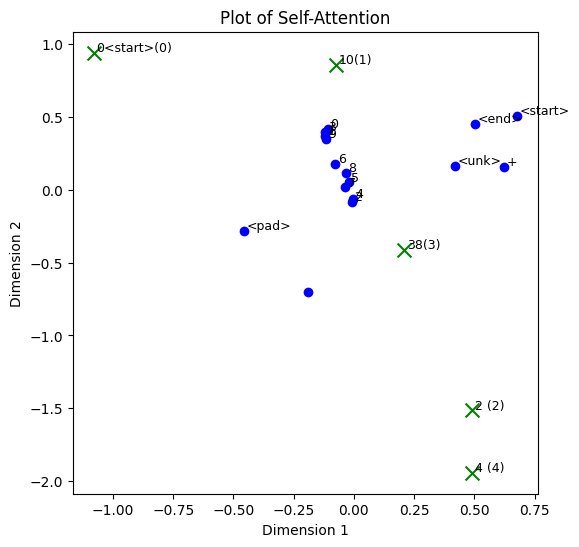

QV.shape: torch.Size([1, 5, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 5, 15])
AV.shape: torch.Size([1, 5, 4])
[[[-0.9215665   0.02707688 -0.5197386  -0.31801242]]

 [[-1.5620508   0.39295238  0.2040964   1.3520929 ]]

 [[-2.376897   -0.36767036 -1.0675994  -3.257353  ]]

 [[-1.7842113   0.5965639   0.12577924  0.5615962 ]]

 [[-2.5123942  -0.39748085 -1.1198348  -3.4453797 ]]]
(5, 1, 4)
[[-0.9215665   0.02707688]
 [-1.5620508   0.39295238]
 [-2.376897   -0.36767036]
 [-1.7842113   0.5965639 ]
 [-2.5123942  -0.39748085]]


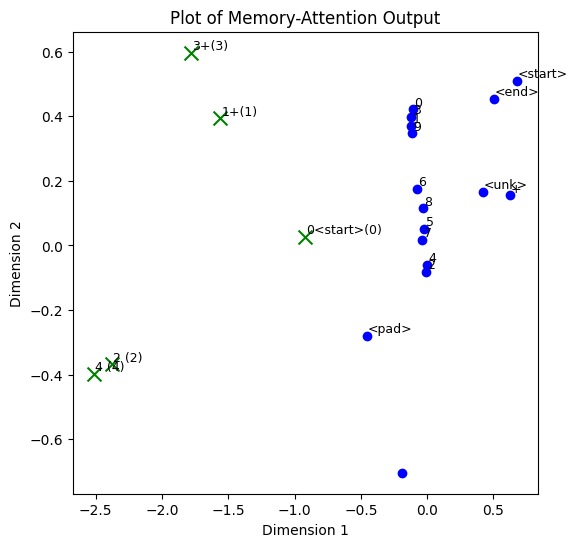

[[[-5.1932406   2.261054    2.013794   -1.2224191 ]]

 [[-3.9644527   1.2380421  -2.9994774   3.764267  ]]

 [[ 2.7242017   2.1705008  -3.3429732  -2.3214638 ]]

 [[-3.7675776   0.21187799 -2.6797602   4.450617  ]]

 [[-0.42842108 -2.7549305   4.3768907  -1.6901114 ]]]
(5, 1, 4)
[[-5.1932406   2.261054  ]
 [-3.9644527   1.2380421 ]
 [ 2.7242017   2.1705008 ]
 [-3.7675776   0.21187799]
 [-0.42842108 -2.7549305 ]]


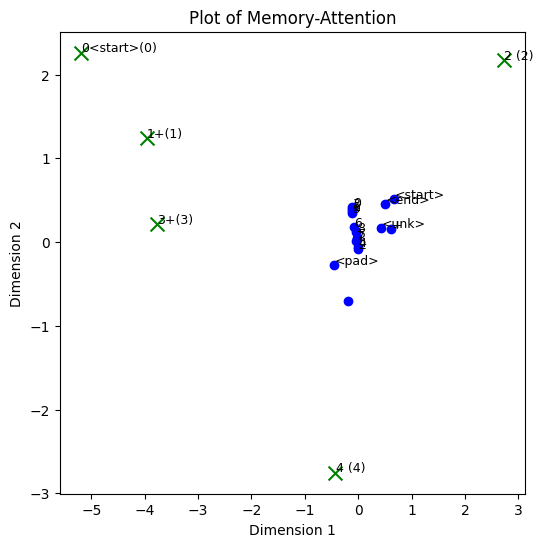

output.shape: torch.Size([1, 16])
output: tensor([[-0.5916, -4.0192,  1.2973, -2.9681,  3.2773,  3.6199, -2.8403,  0.5337,  3.4901, -6.6013,
          2.9230,  3.1639,  3.1772,  4.1598, 16.5698,  2.7223]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 14

------------------

iter: 5
ys: tensor([[12],
        [ 0],
        [15],
        [ 8],
        [15],
        [14]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]],

        [[ 0.2872,  0.5951,  0.6541,  0.7773]]], device='cuda:0')
now tgt: 0 8 +
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]],

  

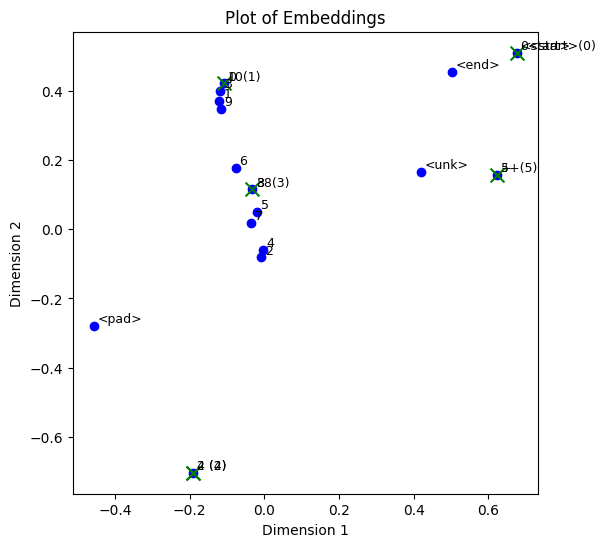

[[[ 1.3527172   2.0194998   1.8224976   1.8423921 ]]

 [[ 0.6269504   1.3827169  -1.1499087   1.7872171 ]]

 [[ 0.5289055  -1.823288   -0.0286332   1.0948254 ]]

 [[ 0.07733025 -0.7600116  -1.0351462   1.7550772 ]]

 [[-1.1371944  -2.0607848  -0.00864253  1.0942255 ]]

 [[ 0.28716075  0.5950839   0.654073    0.7772598 ]]]
(6, 1, 4)
[[ 1.3527172   2.0194998 ]
 [ 0.6269504   1.3827169 ]
 [ 0.5289055  -1.823288  ]
 [ 0.07733025 -0.7600116 ]
 [-1.1371944  -2.0607848 ]
 [ 0.28716075  0.5950839 ]]


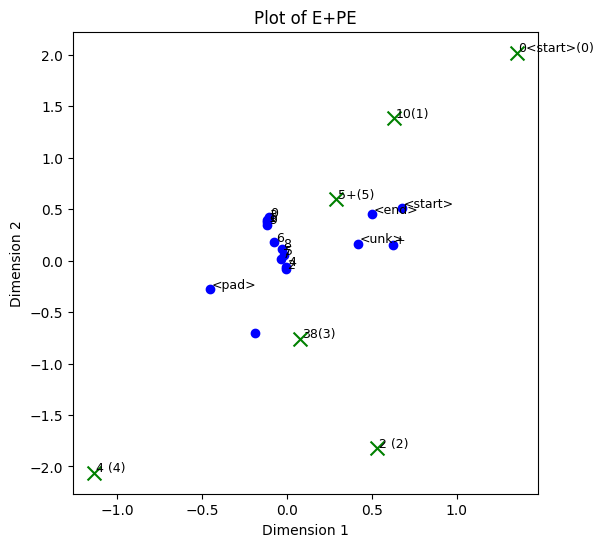

SelfAttention Layer
QV.shape: torch.Size([1, 6, 4])
KV.shape: torch.Size([1, 6, 4])
WV.shape: torch.Size([1, 6, 4])
attn_weight.shape: torch.Size([1, 6, 6])
AV.shape: torch.Size([1, 6, 4])
[[[-0.8343625   0.7967849   1.2131293  -0.61927557]]

 [[-0.12769979  0.20176274 -1.222974   -0.0502225 ]]

 [[ 0.12863773  0.04823163 -1.2563877   0.00327098]]

 [[ 0.26760018 -0.08340797 -1.7925782   0.10724258]]

 [[ 1.9690655  -1.0449237  -1.1272893   0.28965008]]

 [[ 0.42052037 -0.05731681 -0.41911    -0.08135171]]]
(6, 1, 4)
[[-0.8343625   0.7967849 ]
 [-0.12769979  0.20176274]
 [ 0.12863773  0.04823163]
 [ 0.26760018 -0.08340797]
 [ 1.9690655  -1.0449237 ]
 [ 0.42052037 -0.05731681]]


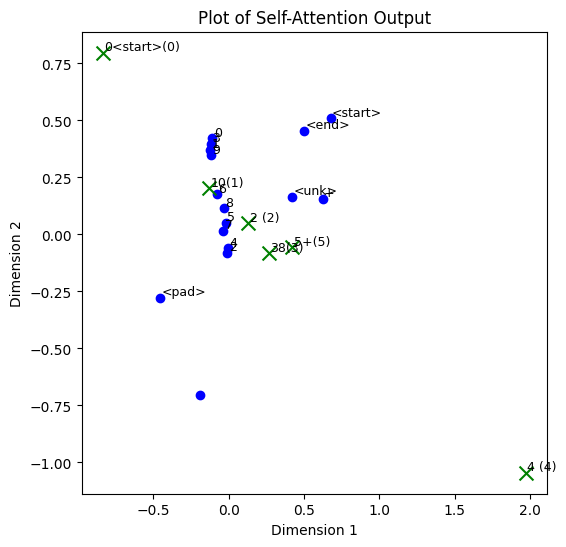

[[[-1.0786452   0.94786054  1.1483697  -0.64429605]]

 [[-0.02734205  0.7934339  -1.6994064   0.94538754]]

 [[ 0.5184338  -1.5886152  -0.7858325   1.2997767 ]]

 [[ 0.22424081 -0.46974403 -1.4676924   1.4491956 ]]

 [[ 0.48383155 -1.9451271  -0.34141323  1.1994612 ]]

 [[ 0.5607903  -0.1657697  -1.6608949   0.9049604 ]]]
(6, 1, 4)
[[-1.0786452   0.94786054]
 [-0.02734205  0.7934339 ]
 [ 0.5184338  -1.5886152 ]
 [ 0.22424081 -0.46974403]
 [ 0.48383155 -1.9451271 ]
 [ 0.5607903  -0.1657697 ]]


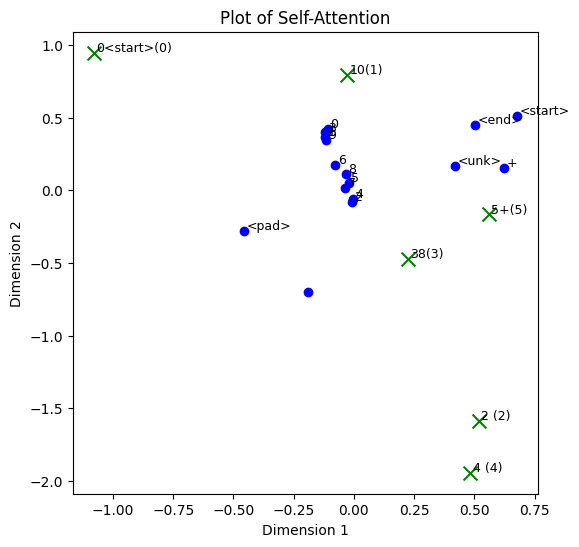

QV.shape: torch.Size([1, 6, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 6, 15])
AV.shape: torch.Size([1, 6, 4])
[[[-0.9250296   0.03097506 -0.5151572  -0.30186763]]

 [[-1.5757264   0.40427238  0.20824179  1.3421433 ]]

 [[-2.4162993  -0.37850755 -1.0853772  -3.3191094 ]]

 [[-1.7918718   0.5859289   0.10094492  0.46142358]]

 [[-2.510464   -0.39796495 -1.1198245  -3.4450529 ]]

 [[-1.8262025   0.6503751   0.26343548  1.0042665 ]]]
(6, 1, 4)
[[-0.9250296   0.03097506]
 [-1.5757264   0.40427238]
 [-2.4162993  -0.37850755]
 [-1.7918718   0.5859289 ]
 [-2.510464   -0.39796495]
 [-1.8262025   0.6503751 ]]


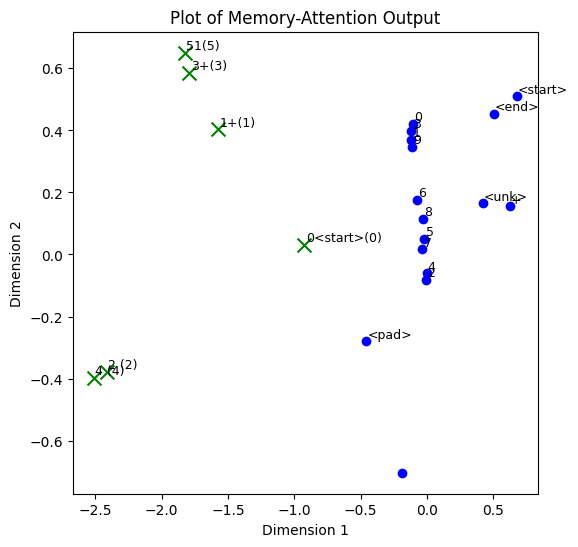

[[[-5.2115655   2.2655566   1.9973203  -1.1969104 ]]

 [[-3.9066575   1.1827852  -3.0312827   3.8105173 ]]

 [[ 2.0119956  -1.6268934   3.0353966  -3.624631  ]]

 [[-3.749756    0.18092856 -2.675904    4.467346  ]]

 [[-0.50018054 -2.771562    4.391817   -1.6282037 ]]

 [[-3.4688368   0.5751577  -3.1370745   4.2430468 ]]]
(6, 1, 4)
[[-5.2115655   2.2655566 ]
 [-3.9066575   1.1827852 ]
 [ 2.0119956  -1.6268934 ]
 [-3.749756    0.18092856]
 [-0.50018054 -2.771562  ]
 [-3.4688368   0.5751577 ]]


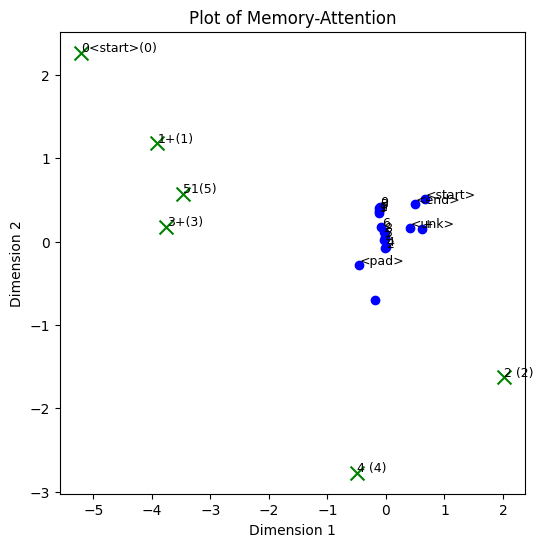

output.shape: torch.Size([1, 16])
output: tensor([[ -3.9400,   2.4814, -11.6728,   1.2025, -13.8637, -14.8920,  -3.1587,  -8.2547, -14.4291,
           1.8127,  -6.4486,  -6.4094,  -6.0348,  -4.0568,  -8.1390,  10.3301]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 15

------------------

iter: 6
ys: tensor([[12],
        [ 0],
        [15],
        [ 8],
        [15],
        [14],
        [15]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]],

        [[ 0.2872,  0.5951,  0.6541,  0.7773]],

        [[-0.6598, -0.4470,  0.0113,  1.0932]]], device='cuda:0')
now tgt: 0 8 + 
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -

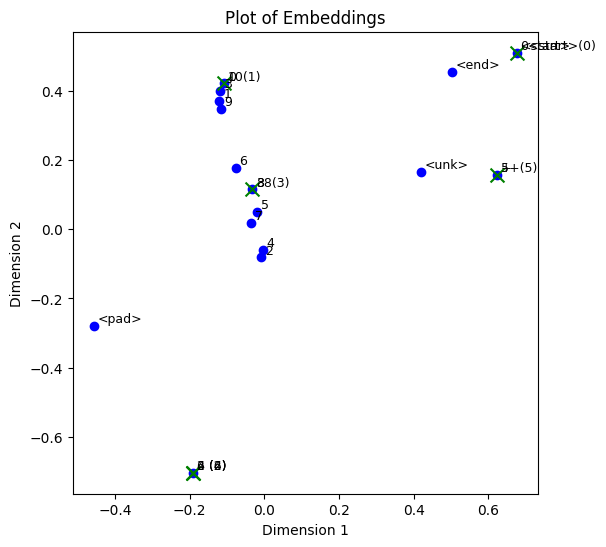

[[[ 1.3527172   2.0194998   1.8224976   1.8423921 ]]

 [[ 0.6269504   1.3827169  -1.1499087   1.7872171 ]]

 [[ 0.5289055  -1.823288   -0.0286332   1.0948254 ]]

 [[ 0.07733025 -0.7600116  -1.0351462   1.7550772 ]]

 [[-1.1371944  -2.0607848  -0.00864253  1.0942255 ]]

 [[ 0.28716075  0.5950839   0.654073    0.7772598 ]]

 [[-0.6598074  -0.44697082  0.01133214  1.093226  ]]]
(7, 1, 4)
[[ 1.3527172   2.0194998 ]
 [ 0.6269504   1.3827169 ]
 [ 0.5289055  -1.823288  ]
 [ 0.07733025 -0.7600116 ]
 [-1.1371944  -2.0607848 ]
 [ 0.28716075  0.5950839 ]
 [-0.6598074  -0.44697082]]


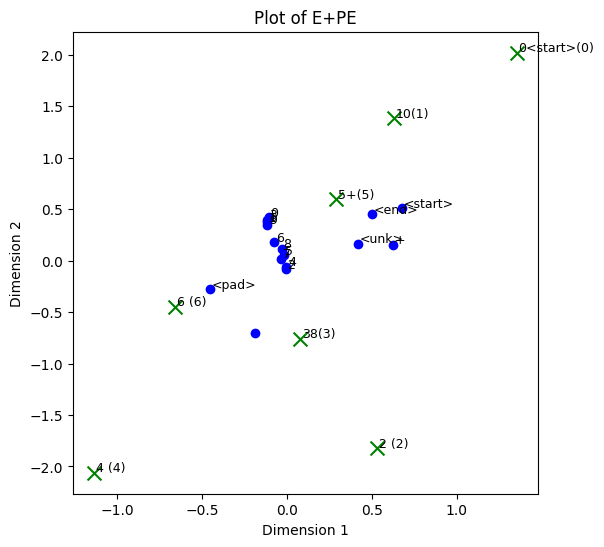

SelfAttention Layer
QV.shape: torch.Size([1, 7, 4])
KV.shape: torch.Size([1, 7, 4])
WV.shape: torch.Size([1, 7, 4])
attn_weight.shape: torch.Size([1, 7, 7])
AV.shape: torch.Size([1, 7, 4])
[[[-0.77368045  0.7545935   1.1336405  -0.5928998 ]]

 [[-0.14714634  0.22683115 -1.0292896  -0.08784166]]

 [[ 0.09733547  0.07573327 -1.1276369  -0.02515027]]

 [[ 0.2550131  -0.07213828 -1.7415876   0.09630437]]

 [[ 1.9665995  -1.0433258  -1.125505    0.28891444]]

 [[ 0.32817572  0.00453834 -0.29962233 -0.12052941]]

 [[ 1.6822059  -0.8692688  -1.1079772   0.2437431 ]]]
(7, 1, 4)
[[-0.77368045  0.7545935 ]
 [-0.14714634  0.22683115]
 [ 0.09733547  0.07573327]
 [ 0.2550131  -0.07213828]
 [ 1.9665995  -1.0433258 ]
 [ 0.32817572  0.00453834]
 [ 1.6822059  -0.8692688 ]]


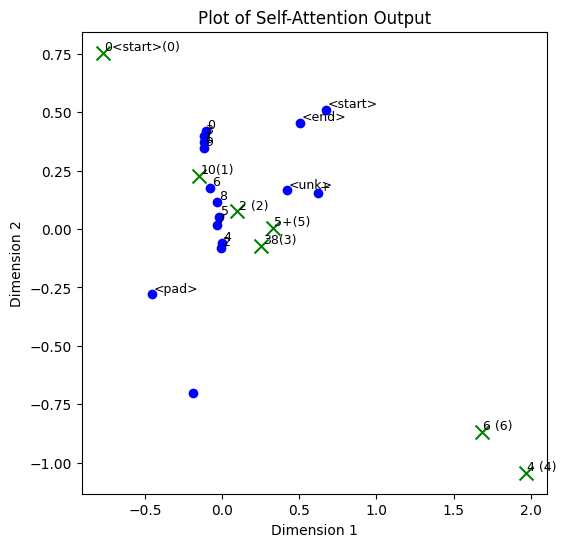

[[[-1.0797061   0.96451366  1.1353766  -0.6438481 ]]

 [[-0.05299651  0.8302219  -1.6894928   0.9395422 ]]

 [[ 0.50702447 -1.6434345  -0.7258233   1.3016542 ]]

 [[ 0.21869417 -0.47346324 -1.4633987   1.4558886 ]]

 [[ 0.4832106  -1.9454892  -0.34068277  1.1999042 ]]

 [[ 0.28597066  0.32546073 -1.7478322   0.95777774]]

 [[ 0.56432956 -1.4689955  -0.91116804  1.2599612 ]]]
(7, 1, 4)
[[-1.0797061   0.96451366]
 [-0.05299651  0.8302219 ]
 [ 0.50702447 -1.6434345 ]
 [ 0.21869417 -0.47346324]
 [ 0.4832106  -1.9454892 ]
 [ 0.28597066  0.32546073]
 [ 0.56432956 -1.4689955 ]]


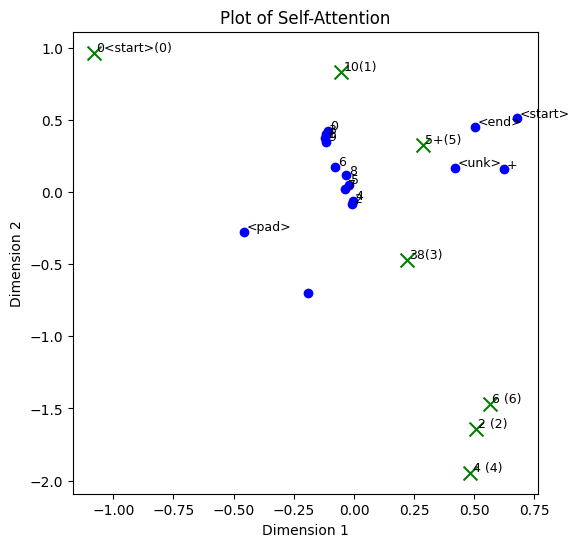

QV.shape: torch.Size([1, 7, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 7, 15])
AV.shape: torch.Size([1, 7, 4])
[[[-0.934477    0.04157157 -0.5025241  -0.25742525]]

 [[-1.5681778   0.39798516  0.20598647  1.3477778 ]]

 [[-2.4338276  -0.38738614 -1.0968349  -3.357205  ]]

 [[-1.7903688   0.58198893  0.09535082  0.44537076]]

 [[-2.510348   -0.3980015  -1.1198286  -3.4450512 ]]

 [[-1.6902218   0.50871754  0.23681432  1.224036  ]]

 [[-2.372704   -0.3356192  -1.0359064  -3.1650348 ]]]
(7, 1, 4)
[[-0.934477    0.04157157]
 [-1.5681778   0.39798516]
 [-2.4338276  -0.38738614]
 [-1.7903688   0.58198893]
 [-2.510348   -0.3980015 ]
 [-1.6902218   0.50871754]
 [-2.372704   -0.3356192 ]]


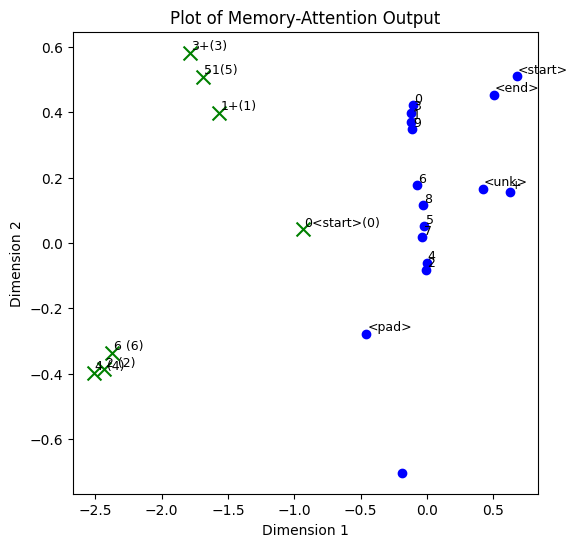

[[[-5.263668    2.2777452   1.9495238  -1.122772  ]]

 [[-3.9378266   1.2126787  -3.0143502   3.7856815 ]]

 [[ 0.77977645 -2.3516788   3.9399798  -2.6922655 ]]

 [[-3.7526438   0.17848459 -2.6717844   4.4684434 ]]

 [[-0.5058922  -2.7727334   4.392975   -1.6234157 ]]

 [[-3.59882     0.8571159  -3.1634004   4.0561714 ]]

 [[ 2.8229103   2.0451005  -4.0965447  -1.5346504 ]]]
(7, 1, 4)
[[-5.263668    2.2777452 ]
 [-3.9378266   1.2126787 ]
 [ 0.77977645 -2.3516788 ]
 [-3.7526438   0.17848459]
 [-0.5058922  -2.7727334 ]
 [-3.59882     0.8571159 ]
 [ 2.8229103   2.0451005 ]]


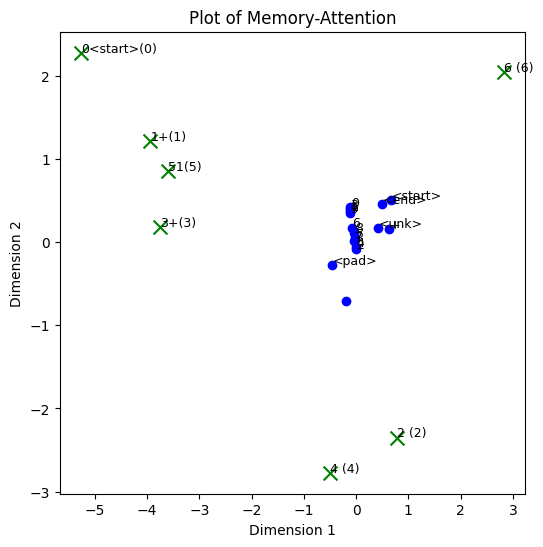

output.shape: torch.Size([1, 16])
output: tensor([[  6.0991,   4.3993,   6.1267,   5.0933,   6.7507,   6.9142,   4.9895,   5.7653,   6.9392,
           4.1277,  -3.6594,  -3.8236,  -3.6176,  -7.2467, -11.8382, -10.6870]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 8

------------------

iter: 7
ys: tensor([[12],
        [ 0],
        [15],
        [ 8],
        [15],
        [14],
        [15],
        [ 8]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]],

        [[ 0.2872,  0.5951,  0.6541,  0.7773]],

        [[-0.6598, -0.4470,  0.0113,  1.0932]],

        [[ 0.5932,  0.9839, -0.9952,  1.7531]]], device='cuda:0')
now tgt: 0 8 + 8
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

      

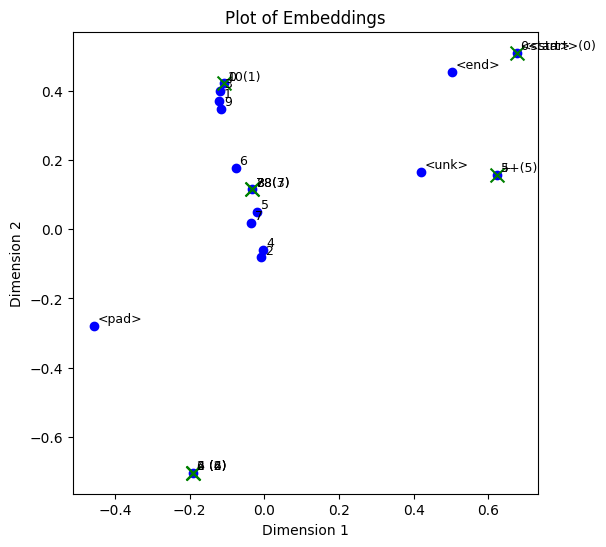

[[[ 1.3527172   2.0194998   1.8224976   1.8423921 ]]

 [[ 0.6269504   1.3827169  -1.1499087   1.7872171 ]]

 [[ 0.5289055  -1.823288   -0.0286332   1.0948254 ]]

 [[ 0.07733025 -0.7600116  -1.0351462   1.7550772 ]]

 [[-1.1371944  -2.0607848  -0.00864253  1.0942255 ]]

 [[ 0.28716075  0.5950839   0.654073    0.7772598 ]]

 [[-0.6598074  -0.44697082  0.01133214  1.093226  ]]

 [[ 0.59319687  0.98388314 -0.99519885  1.7530782 ]]]
(8, 1, 4)
[[ 1.3527172   2.0194998 ]
 [ 0.6269504   1.3827169 ]
 [ 0.5289055  -1.823288  ]
 [ 0.07733025 -0.7600116 ]
 [-1.1371944  -2.0607848 ]
 [ 0.28716075  0.5950839 ]
 [-0.6598074  -0.44697082]
 [ 0.59319687  0.98388314]]


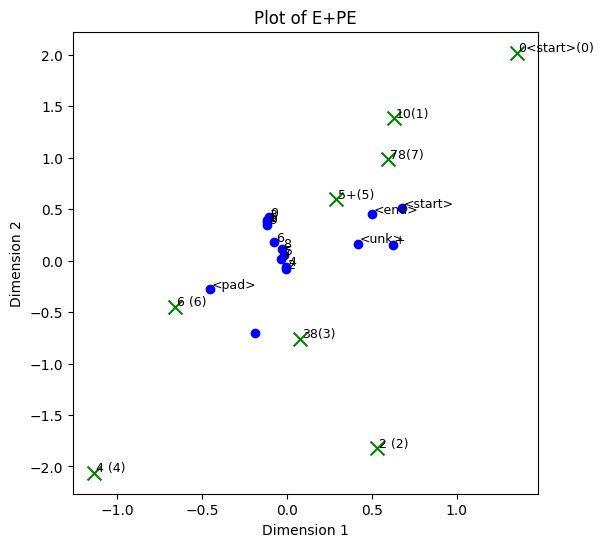

SelfAttention Layer
QV.shape: torch.Size([1, 8, 4])
KV.shape: torch.Size([1, 8, 4])
WV.shape: torch.Size([1, 8, 4])
attn_weight.shape: torch.Size([1, 8, 8])
AV.shape: torch.Size([1, 8, 4])
[[[-0.7709203   0.7520118   1.1215547  -0.59036535]]

 [[-0.11810999  0.18664451 -1.2862227  -0.04547169]]

 [[ 0.07184792  0.06936844 -1.3612671   0.00304331]]

 [[ 0.17526865 -0.03721663 -1.8694928   0.09786844]]

 [[ 1.8514501  -0.9800345  -1.1866143   0.27804485]]

 [[ 0.30605638  0.00726402 -0.41991246 -0.10630412]]

 [[ 1.5345924  -0.7896749  -1.2009466   0.23140097]]

 [[-0.08313241  0.1633171  -1.3239121  -0.03211339]]]
(8, 1, 4)
[[-0.7709203   0.7520118 ]
 [-0.11810999  0.18664451]
 [ 0.07184792  0.06936844]
 [ 0.17526865 -0.03721663]
 [ 1.8514501  -0.9800345 ]
 [ 0.30605638  0.00726402]
 [ 1.5345924  -0.7896749 ]
 [-0.08313241  0.1633171 ]]


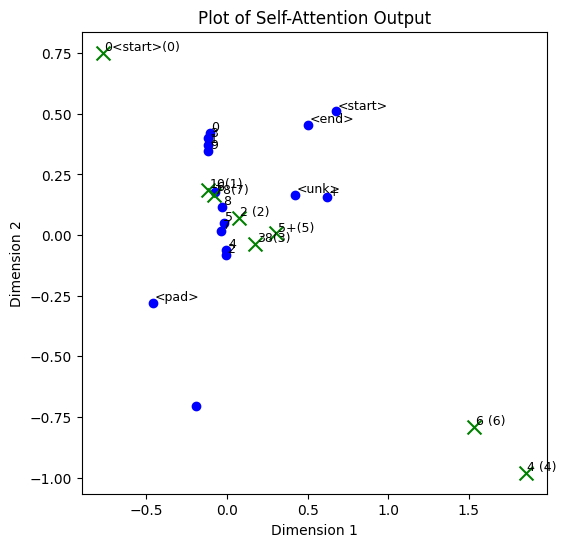

[[[-1.080844    0.9697348   1.1308236  -0.6420635 ]]

 [[-0.01666646  0.7805603  -1.7033541   0.9455109 ]]

 [[ 0.5032268  -1.5273739  -0.8424056   1.3266361 ]]

 [[ 0.1959089  -0.41034254 -1.483199    1.4537809 ]]

 [[ 0.46005946 -1.9218878  -0.36786464  1.2404546 ]]

 [[ 0.21208271  0.43534353 -1.748146    0.9674366 ]]

 [[ 0.51521134 -1.3769176  -0.98236805  1.3233653 ]]

 [[ 0.02944704  0.5796005  -1.706515    1.0584807 ]]]
(8, 1, 4)
[[-1.080844    0.9697348 ]
 [-0.01666646  0.7805603 ]
 [ 0.5032268  -1.5273739 ]
 [ 0.1959089  -0.41034254]
 [ 0.46005946 -1.9218878 ]
 [ 0.21208271  0.43534353]
 [ 0.51521134 -1.3769176 ]
 [ 0.02944704  0.5796005 ]]


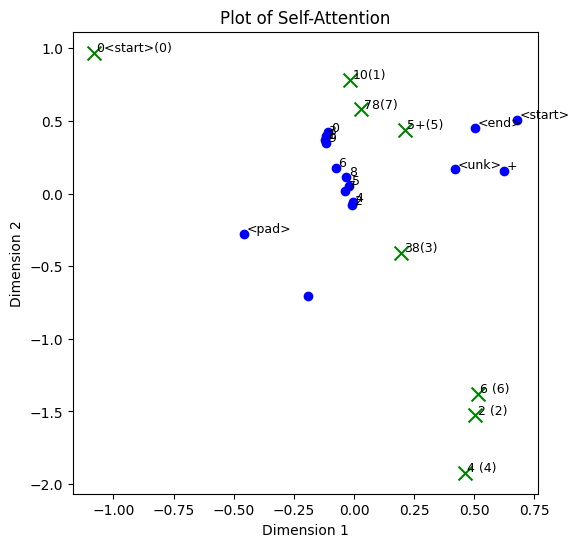

QV.shape: torch.Size([1, 8, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 8, 15])
AV.shape: torch.Size([1, 8, 4])
[[[-0.93722796  0.04467787 -0.4987599  -0.24409841]]

 [[-1.5786399   0.40662587  0.20923495  1.3403876 ]]

 [[-2.3857477  -0.36852652 -1.0701228  -3.2669504 ]]

 [[-1.7798849   0.5918811   0.12038311  0.55123514]]

 [[-2.4980054  -0.39972425 -1.1189005  -3.4397542 ]]

 [[-1.6600447   0.47992766  0.22967866  1.2593069 ]]

 [[-2.3077354  -0.3022762  -0.99058896 -3.0170333 ]]

 [[-1.6117259   0.44076192  0.21020296  1.2814187 ]]]
(8, 1, 4)
[[-0.93722796  0.04467787]
 [-1.5786399   0.40662587]
 [-2.3857477  -0.36852652]
 [-1.7798849   0.5918811 ]
 [-2.4980054  -0.39972425]
 [-1.6600447   0.47992766]
 [-2.3077354  -0.3022762 ]
 [-1.6117259   0.44076192]]


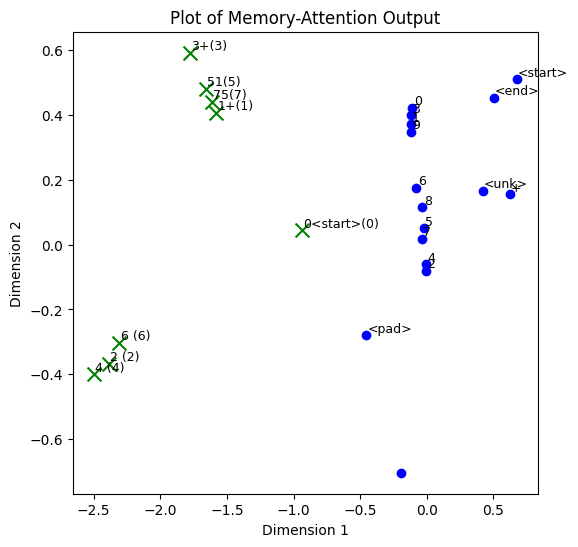

[[[-5.281393    2.2813952   1.9333388  -1.0970645 ]]

 [[-3.8941727   1.1733788  -3.0388134   3.8183017 ]]

 [[ 3.5910792   0.9249669  -0.9416166  -3.9299047 ]]

 [[-3.777452    0.21164368 -2.6708462   4.4502277 ]]

 [[-0.7120307  -2.8317862   4.42615    -1.423563  ]]

 [[-3.6581535   0.9230465  -3.142594    4.0097585 ]]

 [[-0.6586584   1.7967952  -4.9555793   2.3656769 ]]

 [[-3.835639    0.9744812  -3.0151458   3.97184   ]]]
(8, 1, 4)
[[-5.281393    2.2813952 ]
 [-3.8941727   1.1733788 ]
 [ 3.5910792   0.9249669 ]
 [-3.777452    0.21164368]
 [-0.7120307  -2.8317862 ]
 [-3.6581535   0.9230465 ]
 [-0.6586584   1.7967952 ]
 [-3.835639    0.9744812 ]]


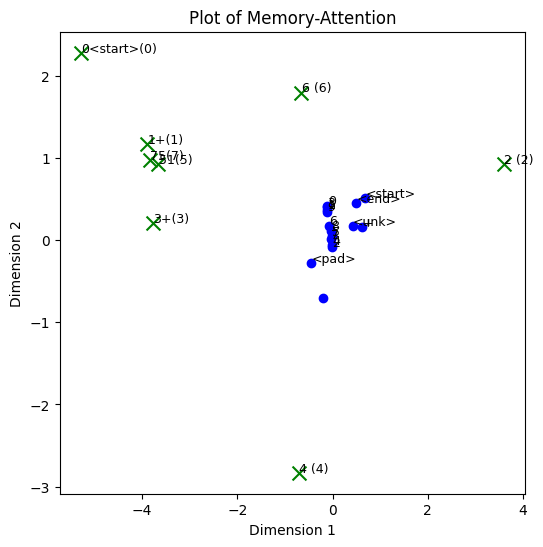

output.shape: torch.Size([1, 16])
output: tensor([[ -3.4212,   1.8422, -12.1780,   1.0055, -13.7691, -14.3450,  -4.1630,  -8.9968, -13.7878,
           0.9777,  -6.2383,  -6.2408,  -5.8529,  -2.8096,  -8.2279,  10.0241]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 15

------------------

iter: 8
ys: tensor([[12],
        [ 0],
        [15],
        [ 8],
        [15],
        [14],
        [15],
        [ 8],
        [15]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]],

        [[ 0.2872,  0.5951,  0.6541,  0.7773]],

        [[-0.6598, -0.4470,  0.0113,  1.0932]],

        [[ 0.5932,  0.9839, -0.9952,  1.7531]],

        [[ 0.6090, -1.5526,  0.0313,  1.0918]]], device='cuda:0')
now tgt: 0 8 + 8 
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1

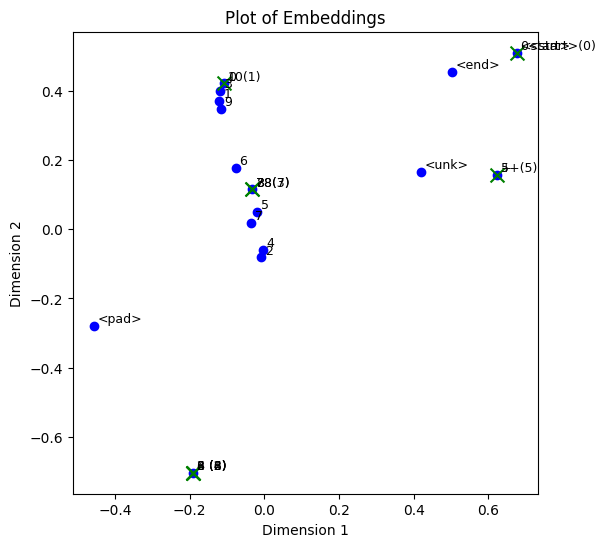

[[[ 1.3527172   2.0194998   1.8224976   1.8423921 ]]

 [[ 0.6269504   1.3827169  -1.1499087   1.7872171 ]]

 [[ 0.5289055  -1.823288   -0.0286332   1.0948254 ]]

 [[ 0.07733025 -0.7600116  -1.0351462   1.7550772 ]]

 [[-1.1371944  -2.0607848  -0.00864253  1.0942255 ]]

 [[ 0.28716075  0.5950839   0.654073    0.7772598 ]]

 [[-0.6598074  -0.44697082  0.01133214  1.093226  ]]

 [[ 0.59319687  0.98388314 -0.99519885  1.7530782 ]]

 [[ 0.60896635 -1.5526412   0.03128283  1.091827  ]]]
(9, 1, 4)
[[ 1.3527172   2.0194998 ]
 [ 0.6269504   1.3827169 ]
 [ 0.5289055  -1.823288  ]
 [ 0.07733025 -0.7600116 ]
 [-1.1371944  -2.0607848 ]
 [ 0.28716075  0.5950839 ]
 [-0.6598074  -0.44697082]
 [ 0.59319687  0.98388314]
 [ 0.60896635 -1.5526412 ]]


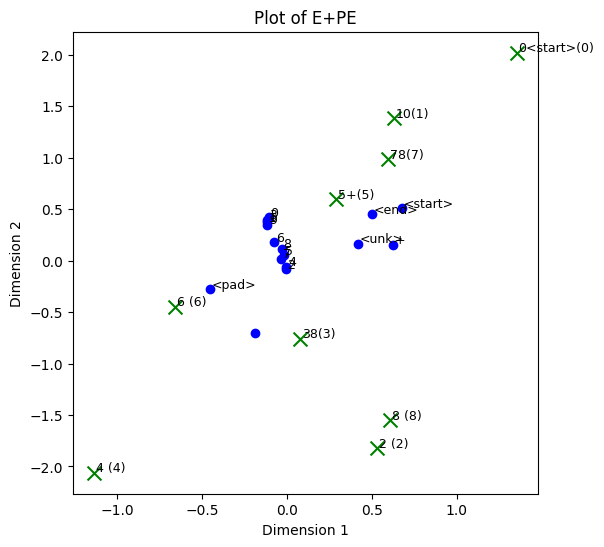

SelfAttention Layer
QV.shape: torch.Size([1, 9, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 9, 9])
AV.shape: torch.Size([1, 9, 4])
[[[-0.756347    0.7410666   1.0550606  -0.5711942 ]]

 [[-0.14177376  0.21086891 -1.2273058  -0.04962779]]

 [[ 0.02414677  0.11028755 -1.283293   -0.00688781]]

 [[ 0.14289999 -0.00843312 -1.7972785   0.08695813]]

 [[ 1.8160728  -0.95720685 -1.17738     0.27218452]]

 [[ 0.22748965  0.05907065 -0.44021028 -0.10490358]]

 [[ 1.4487827  -0.7336776  -1.1742293   0.21692607]]

 [[-0.11076837  0.19049656 -1.2595041  -0.03760968]]

 [[-0.03158411  0.15553842 -1.1427902  -0.03841651]]]
(9, 1, 4)
[[-0.756347    0.7410666 ]
 [-0.14177376  0.21086891]
 [ 0.02414677  0.11028755]
 [ 0.14289999 -0.00843312]
 [ 1.8160728  -0.95720685]
 [ 0.22748965  0.05907065]
 [ 1.4487827  -0.7336776 ]
 [-0.11076837  0.19049656]
 [-0.03158411  0.15553842]]


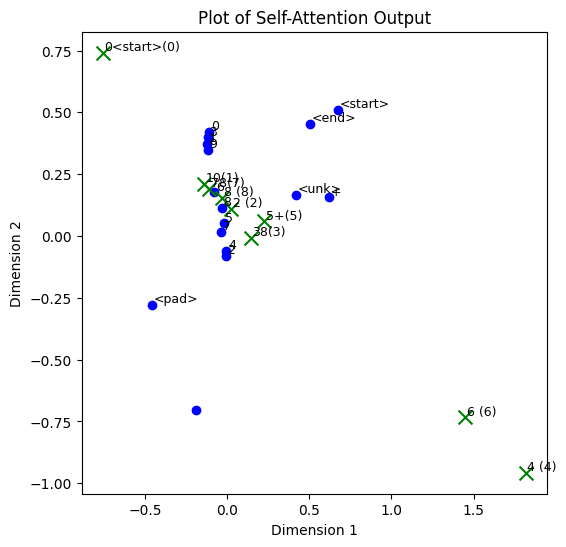

[[[-1.089003    1.0007048   1.1024625  -0.62807083]]

 [[-0.03293414  0.8000397  -1.697281    0.9453833 ]]

 [[ 0.48292056 -1.547705   -0.81671304  1.3466611 ]]

 [[ 0.18073213 -0.40563083 -1.4782876   1.4661903 ]]

 [[ 0.4508846  -1.9217045  -0.36481714  1.2502005 ]]

 [[-0.08682935  0.8225948  -1.6737419   0.97804946]]

 [[ 0.48266995 -1.3566818  -0.9909049   1.3608967 ]]

 [[ 0.01041669  0.601392   -1.7010902   1.0609417 ]]

 [[ 0.4837864  -1.5098988  -0.85355264  1.350626  ]]]
(9, 1, 4)
[[-1.089003    1.0007048 ]
 [-0.03293414  0.8000397 ]
 [ 0.48292056 -1.547705  ]
 [ 0.18073213 -0.40563083]
 [ 0.4508846  -1.9217045 ]
 [-0.08682935  0.8225948 ]
 [ 0.48266995 -1.3566818 ]
 [ 0.01041669  0.601392  ]
 [ 0.4837864  -1.5098988 ]]


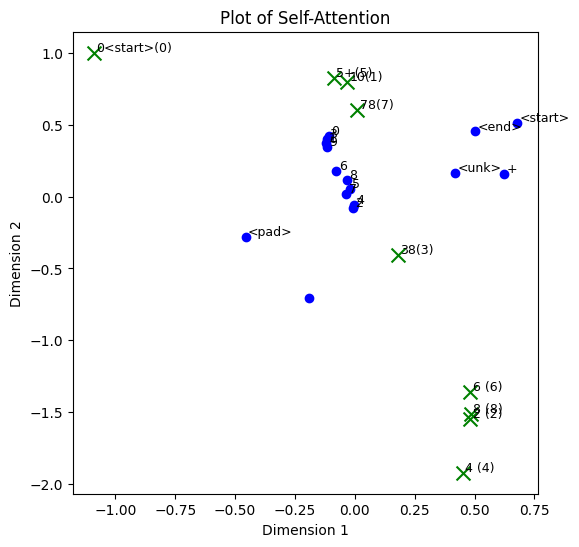

QV.shape: torch.Size([1, 9, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 9, 15])
AV.shape: torch.Size([1, 9, 4])
[[[-0.95296603  0.06228535 -0.47695282 -0.16726302]]

 [[-1.5742267   0.40307236  0.20771739  1.3429974 ]]

 [[-2.388918   -0.3766539  -1.0783334  -3.291793  ]]

 [[-1.7749237   0.5870176   0.11515974  0.54268664]]

 [[-2.4950354  -0.40034175 -1.1188058  -3.4389558 ]]

 [[-1.5644966   0.39724964  0.20149982  1.3385857 ]]

 [[-2.2877407  -0.30169386 -0.9863027  -2.9985335 ]]

 [[-1.6058668   0.43585974  0.20825562  1.2855558 ]]

 [[-2.3722198  -0.36787283 -1.0668858  -3.254082  ]]]
(9, 1, 4)
[[-0.95296603  0.06228535]
 [-1.5742267   0.40307236]
 [-2.388918   -0.3766539 ]
 [-1.7749237   0.5870176 ]
 [-2.4950354  -0.40034175]
 [-1.5644966   0.39724964]
 [-2.2877407  -0.30169386]
 [-1.6058668   0.43585974]
 [-2.3722198  -0.36787283]]


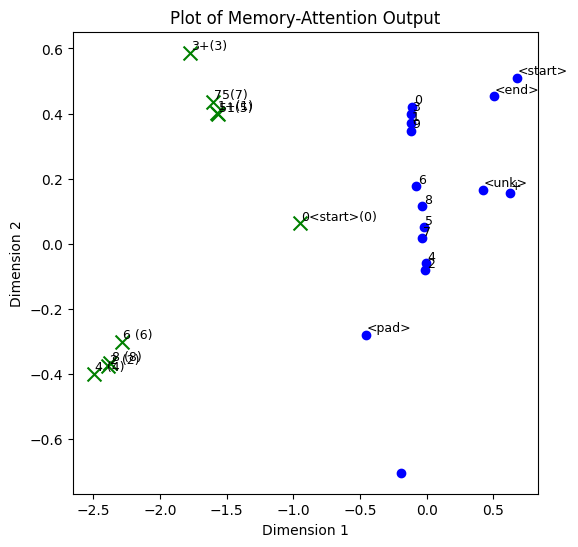

[[[-5.3842087   2.3012533   1.8343298  -0.94154096]]

 [[-3.9132245   1.1875906  -3.0272517   3.8065143 ]]

 [[ 1.6637836  -1.2904165   3.0634332  -3.749805  ]]

 [[-3.7885554   0.21253203 -2.6615236   4.449172  ]]

 [[-0.7983503  -2.8485694   4.43816    -1.3469862 ]]

 [[-3.9728184   1.1872197  -2.9754698   3.8049374 ]]

 [[-1.3262038   1.5924767  -4.7179084   2.9022179 ]]

 [[-3.855451    0.9883378  -3.0037498   3.96122   ]]

 [[ 1.4961296   2.5560668  -4.3551874  -0.79436326]]]
(9, 1, 4)
[[-5.3842087   2.3012533 ]
 [-3.9132245   1.1875906 ]
 [ 1.6637836  -1.2904165 ]
 [-3.7885554   0.21253203]
 [-0.7983503  -2.8485694 ]
 [-3.9728184   1.1872197 ]
 [-1.3262038   1.5924767 ]
 [-3.855451    0.9883378 ]
 [ 1.4961296   2.5560668 ]]


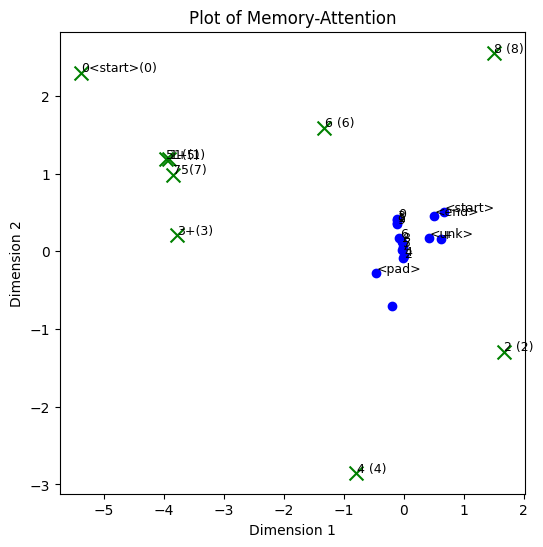

output.shape: torch.Size([1, 16])
output: tensor([[  5.3342,   3.8960,   2.6832,   4.7131,   3.3905,   3.8407,   2.9145,   2.7588,   4.0616,
           3.4864,  -4.3638,  -4.5660,  -4.3018,  -6.0267, -13.1827,  -8.1613]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 0

------------------

iter: 9
ys: tensor([[12],
        [ 0],
        [15],
        [ 8],
        [15],
        [14],
        [15],
        [ 8],
        [15],
        [ 0]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]],

        [[ 0.2872,  0.5951,  0.6541,  0.7773]],

        [[-0.6598, -0.4470,  0.0113,  1.0932]],

        [[ 0.5932,  0.9839, -0.9952,  1.7531]],

        [[ 0.6090, -1.5526,  0.0313,  1.0918]],

        [[ 0.1976, -0.0687, -1.0700,  1.7832]]], device='cuda:0')
now tg

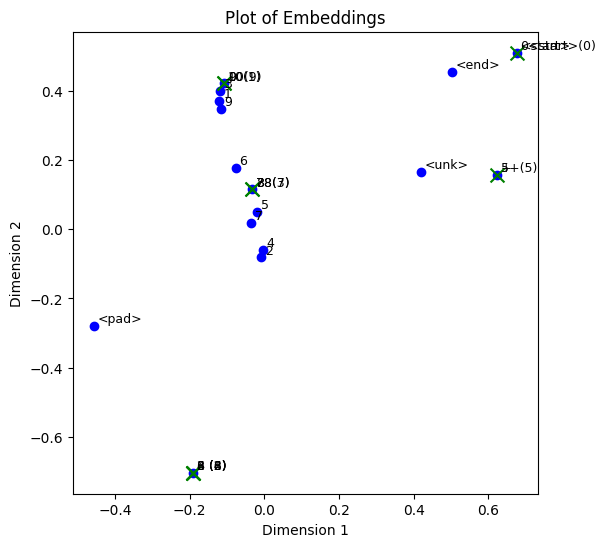

[[[ 1.3527172   2.0194998   1.8224976   1.8423921 ]]

 [[ 0.6269504   1.3827169  -1.1499087   1.7872171 ]]

 [[ 0.5289055  -1.823288   -0.0286332   1.0948254 ]]

 [[ 0.07733025 -0.7600116  -1.0351462   1.7550772 ]]

 [[-1.1371944  -2.0607848  -0.00864253  1.0942255 ]]

 [[ 0.28716075  0.5950839   0.654073    0.7772598 ]]

 [[-0.6598074  -0.44697082  0.01133214  1.093226  ]]

 [[ 0.59319687  0.98388314 -0.99519885  1.7530782 ]]

 [[ 0.60896635 -1.5526412   0.03128283  1.091827  ]]

 [[ 0.1975979  -0.06871575 -1.07003     1.7832198 ]]]
(10, 1, 4)
[[ 1.3527172   2.0194998 ]
 [ 0.6269504   1.3827169 ]
 [ 0.5289055  -1.823288  ]
 [ 0.07733025 -0.7600116 ]
 [-1.1371944  -2.0607848 ]
 [ 0.28716075  0.5950839 ]
 [-0.6598074  -0.44697082]
 [ 0.59319687  0.98388314]
 [ 0.60896635 -1.5526412 ]
 [ 0.1975979  -0.06871575]]


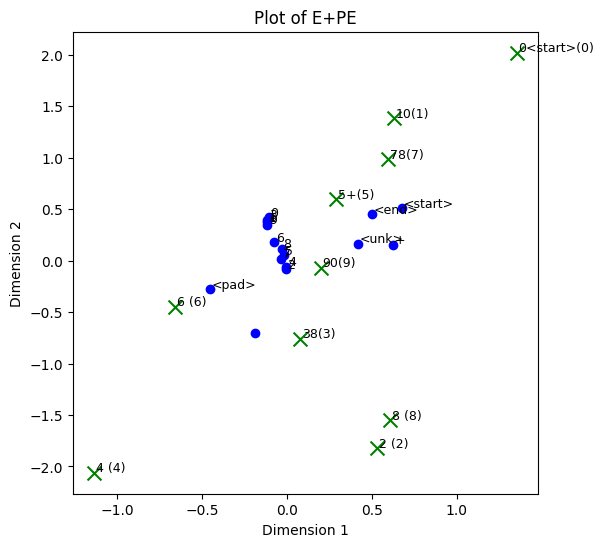

SelfAttention Layer
QV.shape: torch.Size([1, 10, 4])
KV.shape: torch.Size([1, 10, 4])
WV.shape: torch.Size([1, 10, 4])
attn_weight.shape: torch.Size([1, 10, 10])
AV.shape: torch.Size([1, 10, 4])
[[[-0.7546072   0.73746324  1.0243416  -0.56618124]]

 [[-0.20618653  0.24375075 -1.2498721  -0.06612881]]

 [[-0.05492108  0.1526072  -1.2969342  -0.02717205]]

 [[ 0.07395441  0.03346933 -1.760721    0.0635249 ]]

 [[ 1.7895776  -0.94184566 -1.1797386   0.2673538 ]]

 [[ 0.17229843  0.0848479  -0.50249934 -0.1092547 ]]

 [[ 1.3870658  -0.6982119  -1.1807936   0.20532422]]

 [[-0.17785847  0.22534665 -1.2773086  -0.05533595]]

 [[-0.10524794  0.19302721 -1.1743684  -0.05514849]]

 [[ 0.01315684  0.07905105 -1.6601877   0.03859791]]]
(10, 1, 4)
[[-0.7546072   0.73746324]
 [-0.20618653  0.24375075]
 [-0.05492108  0.1526072 ]
 [ 0.07395441  0.03346933]
 [ 1.7895776  -0.94184566]
 [ 0.17229843  0.0848479 ]
 [ 1.3870658  -0.6982119 ]
 [-0.17785847  0.22534665]
 [-0.10524794  0.19302721]
 [ 0.013156

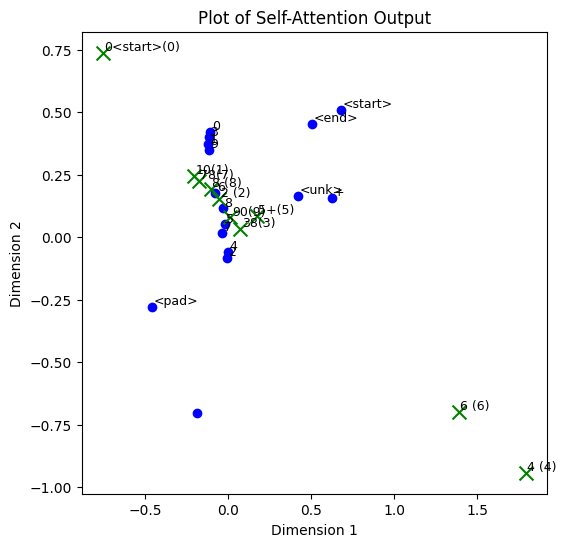

[[[-1.0925854   1.0166417   1.0878237  -0.6217019 ]]

 [[-0.05465457  0.83147025 -1.6888      0.9400957 ]]

 [[ 0.45758545 -1.5204749  -0.83499944  1.3779337 ]]

 [[ 0.15560319 -0.3767485  -1.4795557   1.4780861 ]]

 [[ 0.4447165  -1.9192089  -0.36609945  1.2581358 ]]

 [[-0.19793303  0.97604394 -1.6179627   0.94454193]]

 [[ 0.45932707 -1.3290572  -1.007033    1.3867507 ]]

 [[-0.01483798  0.6401545  -1.6943315   1.0560747 ]]

 [[ 0.45750076 -1.4693843  -0.88320255  1.3834393 ]]

 [[ 0.0870569   0.01323043 -1.6016904   1.362003  ]]]
(10, 1, 4)
[[-1.0925854   1.0166417 ]
 [-0.05465457  0.83147025]
 [ 0.45758545 -1.5204749 ]
 [ 0.15560319 -0.3767485 ]
 [ 0.4447165  -1.9192089 ]
 [-0.19793303  0.97604394]
 [ 0.45932707 -1.3290572 ]
 [-0.01483798  0.6401545 ]
 [ 0.45750076 -1.4693843 ]
 [ 0.0870569   0.01323043]]


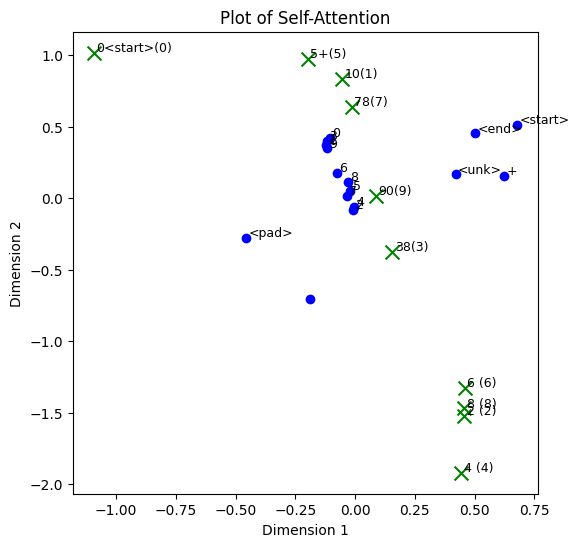

QV.shape: torch.Size([1, 10, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 10, 15])
AV.shape: torch.Size([1, 10, 4])
[[[-0.9610064   0.07108299 -0.46576643 -0.12839879]]

 [[-1.5678227   0.39773643  0.20581329  1.3478048 ]]

 [[-2.369447   -0.37541473 -1.0734159  -3.2725298 ]]

 [[-1.7655944   0.58394945  0.11739602  0.5691998 ]]

 [[-2.4924953  -0.40078157 -1.1186688  -3.4380653 ]]

 [[-1.5343263   0.3735469   0.19110668  1.3560169 ]]

 [[-2.2645848  -0.2924456  -0.97281057 -2.952685  ]]

 [[-1.59687     0.42793065  0.20594168  1.2943387 ]]

 [[-2.3452249  -0.36195058 -1.0560808  -3.2155776 ]]

 [[-1.7111999   0.5550537   0.19136573  0.98449224]]]
(10, 1, 4)
[[-0.9610064   0.07108299]
 [-1.5678227   0.39773643]
 [-2.369447   -0.37541473]
 [-1.7655944   0.58394945]
 [-2.4924953  -0.40078157]
 [-1.5343263   0.3735469 ]
 [-2.2645848  -0.2924456 ]
 [-1.59687     0.42793065]
 [-2.3452249  -0.36195058]
 [-1.7111999   0.5550537 ]]


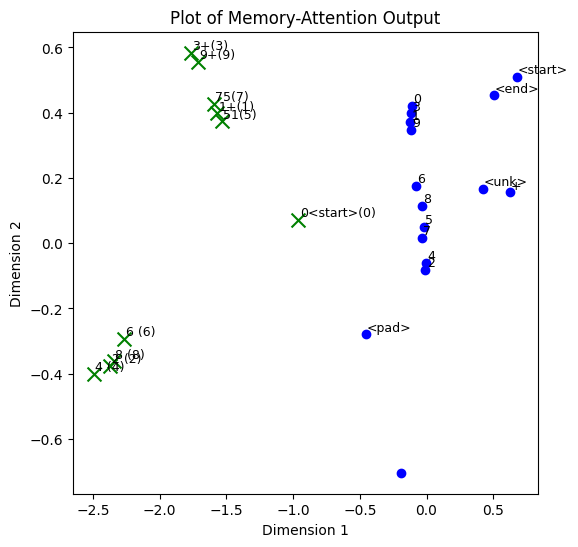

[[[-5.4319425   2.3104362   1.7838017  -0.8649065 ]]

 [[-3.9397247   1.213302   -3.0129132   3.7851226 ]]

 [[-4.2960877   1.625491   -2.3336186   2.954705  ]]

 [[-3.8091857   0.22656862 -2.6519566   4.4407673 ]]

 [[-0.85705346 -2.8603802   4.4451427  -1.2933218 ]]

 [[-4.11598     1.3182185  -2.8900273   3.6905622 ]]

 [[-1.7439231   1.4198443  -4.5117626   3.2329712 ]]

 [[-3.8825948   1.0176791  -2.9919958   3.9387567 ]]

 [[-1.5888493   1.8484449  -4.604885    2.7168987 ]]

 [[-3.836533    0.48798648 -2.7821581   4.2945275 ]]]
(10, 1, 4)
[[-5.4319425   2.3104362 ]
 [-3.9397247   1.213302  ]
 [-4.2960877   1.625491  ]
 [-3.8091857   0.22656862]
 [-0.85705346 -2.8603802 ]
 [-4.11598     1.3182185 ]
 [-1.7439231   1.4198443 ]
 [-3.8825948   1.0176791 ]
 [-1.5888493   1.8484449 ]
 [-3.836533    0.48798648]]


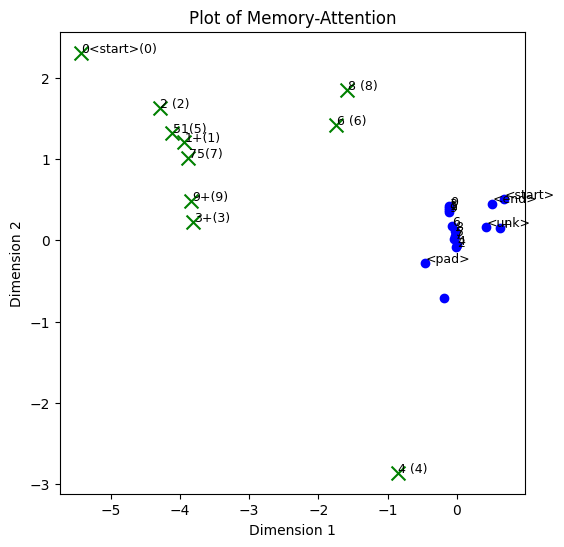

output.shape: torch.Size([1, 16])
output: tensor([[ -4.2597,   1.9562, -12.4056,   0.7716, -14.4414, -15.3603,  -3.9150,  -8.9816, -14.8653,
           1.1405,  -6.2223,  -6.1762,  -5.8005,  -3.2210,  -7.0819,  11.2044]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 15

------------------

iter: 10
ys: tensor([[12],
        [ 0],
        [15],
        [ 8],
        [15],
        [14],
        [15],
        [ 8],
        [15],
        [ 0],
        [15]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]],

        [[ 0.2872,  0.5951,  0.6541,  0.7773]],

        [[-0.6598, -0.4470,  0.0113,  1.0932]],

        [[ 0.5932,  0.9839, -0.9952,  1.7531]],

        [[ 0.6090, -1.5526,  0.0313,  1.0918]],

        [[ 0.1976, -0.0687, -1.0700,  1.7832]],

       

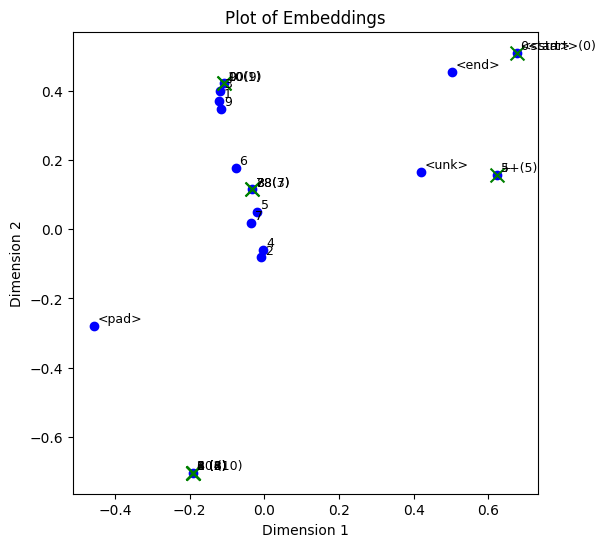

[[[ 1.3527172   2.0194998   1.8224976   1.8423921 ]]

 [[ 0.6269504   1.3827169  -1.1499087   1.7872171 ]]

 [[ 0.5289055  -1.823288   -0.0286332   1.0948254 ]]

 [[ 0.07733025 -0.7600116  -1.0351462   1.7550772 ]]

 [[-1.1371944  -2.0607848  -0.00864253  1.0942255 ]]

 [[ 0.28716075  0.5950839   0.654073    0.7772598 ]]

 [[-0.6598074  -0.44697082  0.01133214  1.093226  ]]

 [[ 0.59319687  0.98388314 -0.99519885  1.7530782 ]]

 [[ 0.60896635 -1.5526412   0.03128283  1.091827  ]]

 [[ 0.1975979  -0.06871575 -1.07003     1.7832198 ]]

 [[-0.924413   -2.2462125   0.05120155  1.0900296 ]]]
(11, 1, 4)
[[ 1.3527172   2.0194998 ]
 [ 0.6269504   1.3827169 ]
 [ 0.5289055  -1.823288  ]
 [ 0.07733025 -0.7600116 ]
 [-1.1371944  -2.0607848 ]
 [ 0.28716075  0.5950839 ]
 [-0.6598074  -0.44697082]
 [ 0.59319687  0.98388314]
 [ 0.60896635 -1.5526412 ]
 [ 0.1975979  -0.06871575]
 [-0.924413   -2.2462125 ]]


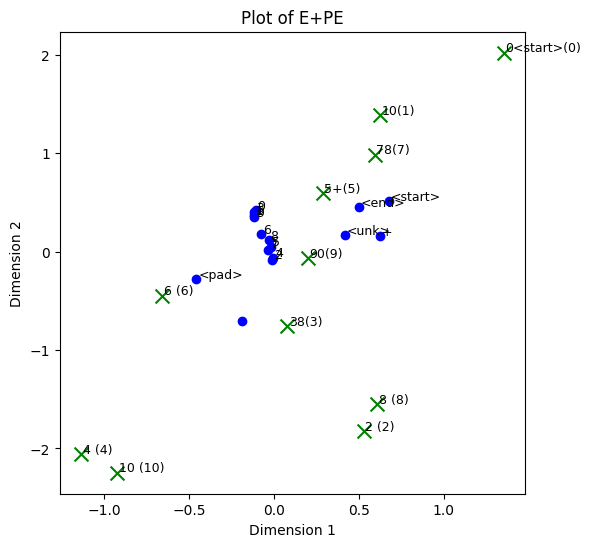

SelfAttention Layer
QV.shape: torch.Size([1, 11, 4])
KV.shape: torch.Size([1, 11, 4])
WV.shape: torch.Size([1, 11, 4])
attn_weight.shape: torch.Size([1, 11, 11])
AV.shape: torch.Size([1, 11, 4])
[[[-0.89119625  0.83385074  1.2059137  -0.62117064]]

 [[-0.243662    0.27463245 -1.1358156  -0.09282611]]

 [[-0.08536311  0.17672402 -1.2162366  -0.04686908]]

 [[ 0.06944145  0.03710972 -1.7482908   0.06057691]]

 [[ 1.7890567  -0.941499   -1.1792581   0.26717845]]

 [[ 0.01129448  0.19827838 -0.2514035  -0.1846102 ]]

 [[ 1.3798634  -0.6933477  -1.1730725   0.20268649]]

 [[-0.2125754   0.25377077 -1.1738425  -0.07971756]]

 [[-0.1473682   0.22637261 -1.0622579  -0.08259441]]

 [[ 0.00466231  0.0859293  -1.6362846   0.03293705]]

 [[ 1.6295384  -0.84939575 -1.2231138   0.24781483]]]
(11, 1, 4)
[[-0.89119625  0.83385074]
 [-0.243662    0.27463245]
 [-0.08536311  0.17672402]
 [ 0.06944145  0.03710972]
 [ 1.7890567  -0.941499  ]
 [ 0.01129448  0.19827838]
 [ 1.3798634  -0.6933477 ]
 [-0.212575

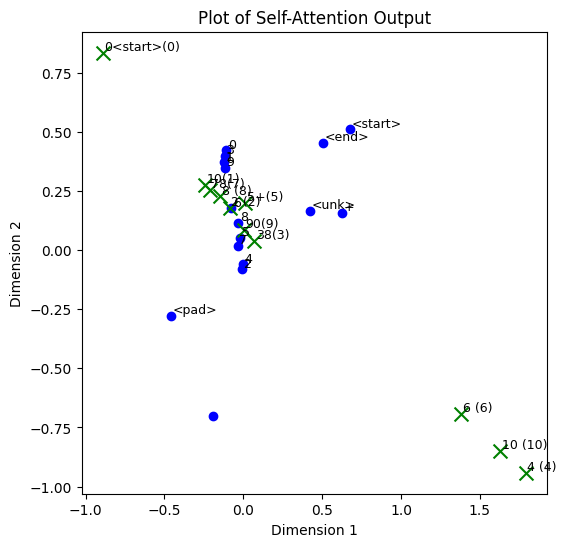

[[[-1.0904874   0.97359514  1.1224917  -0.6230632 ]]

 [[-0.0806886   0.86718917 -1.6777531   0.9345491 ]]

 [[ 0.44477123 -1.552115   -0.79961085  1.3871073 ]]

 [[ 0.15344504 -0.376552   -1.4785733   1.4799696 ]]

 [[ 0.4445673  -1.9193097  -0.365897    1.2582265 ]]

 [[-0.9875879   1.6554481  -0.62759227  0.4495565 ]]

 [[ 0.45648858 -1.3300687  -1.0052812   1.3898596 ]]

 [[-0.03955126  0.67158544 -1.686266    1.0554789 ]]

 [[ 0.43765008 -1.5184288  -0.8298947   1.3992453 ]]

 [[ 0.08238645  0.01627234 -1.6004289   1.3646919 ]]

 [[ 0.46214566 -1.9407095  -0.34098774  1.2260469 ]]]
(11, 1, 4)
[[-1.0904874   0.97359514]
 [-0.0806886   0.86718917]
 [ 0.44477123 -1.552115  ]
 [ 0.15344504 -0.376552  ]
 [ 0.4445673  -1.9193097 ]
 [-0.9875879   1.6554481 ]
 [ 0.45648858 -1.3300687 ]
 [-0.03955126  0.67158544]
 [ 0.43765008 -1.5184288 ]
 [ 0.08238645  0.01627234]
 [ 0.46214566 -1.9407095 ]]


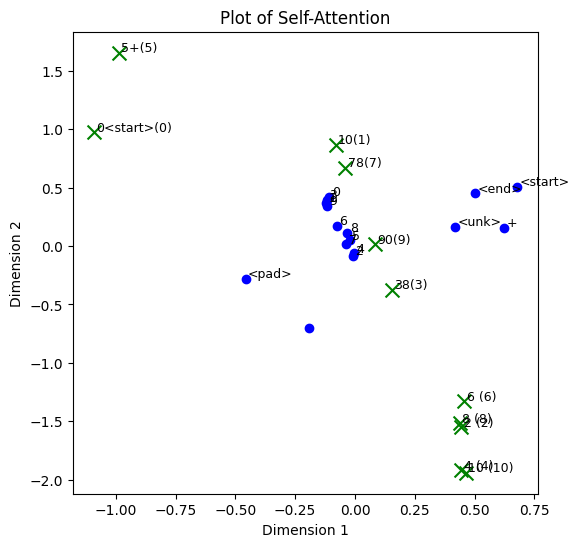

QV.shape: torch.Size([1, 11, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 11, 15])
AV.shape: torch.Size([1, 11, 4])
[[[-0.9373396   0.04532838 -0.4978179  -0.23901151]]

 [[-1.5605599   0.39184082  0.20347765  1.3525819 ]]

 [[-2.3792984  -0.3837372  -1.0829815  -3.3032556 ]]

 [[-1.7648934   0.5831562   0.11641029  0.5670859 ]]

 [[-2.4924695  -0.4007908  -1.1186705  -3.4380672 ]]

 [[-1.3320717   0.28631383  0.03085658  1.1737373 ]]

 [[-2.2646263  -0.29437637 -0.9747507  -2.958217  ]]

 [[-1.5891544   0.42148316  0.20350072  1.3000875 ]]

 [[-2.362525   -0.37861937 -1.0750537  -3.275659  ]]

 [[-1.7097272   0.55387247  0.19059177  0.9847972 ]]

 [[-2.5027537  -0.3994128  -1.1194763  -3.442612  ]]]
(11, 1, 4)
[[-0.9373396   0.04532838]
 [-1.5605599   0.39184082]
 [-2.3792984  -0.3837372 ]
 [-1.7648934   0.5831562 ]
 [-2.4924695  -0.4007908 ]
 [-1.3320717   0.28631383]
 [-2.2646263  -0.29437637]
 [-1.5891544   0.42148316]
 [-2

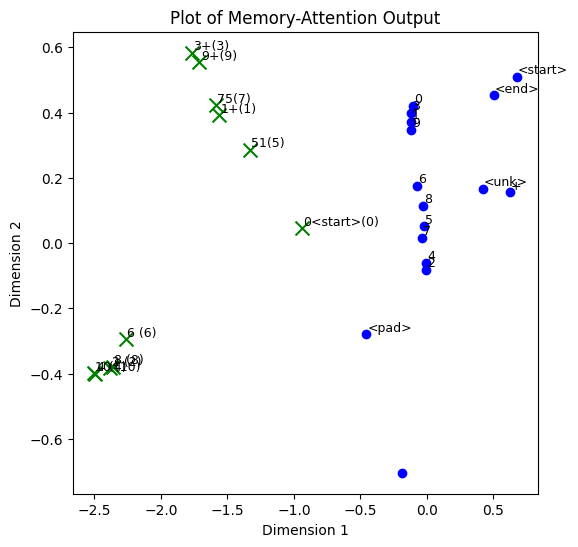

[[[-5.3155355   2.2837386   1.9081213  -1.0480188 ]]

 [[-3.9719646   1.2424508  -2.9943478   3.760411  ]]

 [[-3.171818   -2.5429401   4.2917085   0.35612744]]

 [[-3.8107479   0.22642389 -2.6504674   4.4407506 ]]

 [[-0.858415   -2.8605683   4.4453144  -1.2921836 ]]

 [[-5.374254    2.1103551  -1.5801879   2.5507832 ]]

 [[-1.767432    1.4169601  -4.4999146   3.2436855 ]]

 [[-3.9097087   1.0400908  -2.9772522   3.9211729 ]]

 [[-5.140442    0.10146879 -0.99258775  4.0530396 ]]

 [[-3.8403885   0.488904   -2.7792642   4.2938075 ]]

 [[-0.69292694 -2.81763     4.4252863  -1.453955  ]]]
(11, 1, 4)
[[-5.3155355   2.2837386 ]
 [-3.9719646   1.2424508 ]
 [-3.171818   -2.5429401 ]
 [-3.8107479   0.22642389]
 [-0.858415   -2.8605683 ]
 [-5.374254    2.1103551 ]
 [-1.767432    1.4169601 ]
 [-3.9097087   1.0400908 ]
 [-5.140442    0.10146879]
 [-3.8403885   0.488904  ]
 [-0.69292694 -2.81763   ]]


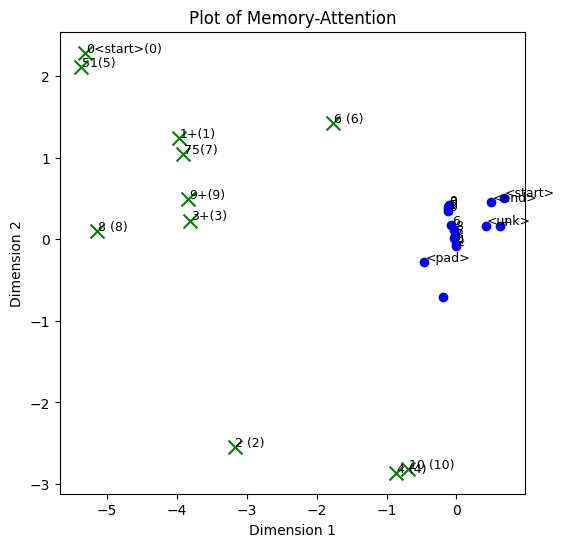

output.shape: torch.Size([1, 16])
output: tensor([[-1.0083, -4.1102,  0.5564, -3.1373,  2.4255,  2.7220, -3.1896, -0.0533,  2.6106, -6.7121,
          2.8158,  3.0651,  3.0853,  4.3097, 16.7488,  3.5989]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 14

------------------

iter: 11
ys: tensor([[12],
        [ 0],
        [15],
        [ 8],
        [15],
        [14],
        [15],
        [ 8],
        [15],
        [ 0],
        [15],
        [14]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]],

        [[ 0.2872,  0.5951,  0.6541,  0.7773]],

        [[-0.6598, -0.4470,  0.0113,  1.0932]],

        [[ 0.5932,  0.9839, -0.9952,  1.7531]],

        [[ 0.6090, -1.5526,  0.0313,  1.0918]],

        [[ 0.1976, -0.0687, -1.0700,  1.7832]],

        [

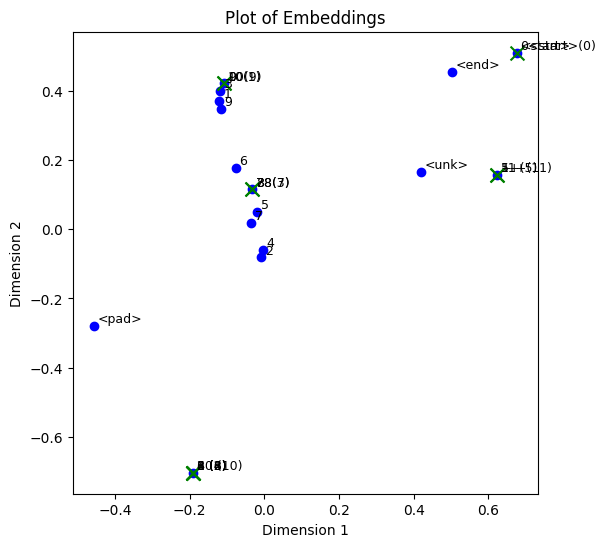

[[[ 1.3527172   2.0194998   1.8224976   1.8423921 ]]

 [[ 0.6269504   1.3827169  -1.1499087   1.7872171 ]]

 [[ 0.5289055  -1.823288   -0.0286332   1.0948254 ]]

 [[ 0.07733025 -0.7600116  -1.0351462   1.7550772 ]]

 [[-1.1371944  -2.0607848  -0.00864253  1.0942255 ]]

 [[ 0.28716075  0.5950839   0.654073    0.7772598 ]]

 [[-0.6598074  -0.44697082  0.01133214  1.093226  ]]

 [[ 0.59319687  0.98388314 -0.99519885  1.7530782 ]]

 [[ 0.60896635 -1.5526412   0.03128283  1.091827  ]]

 [[ 0.1975979  -0.06871575 -1.07003     1.7832198 ]]

 [[-0.924413   -2.2462125   0.05120155  1.0900296 ]]

 [[ 0.24609482  0.3158474   0.71387213  0.7724657 ]]]
(12, 1, 4)
[[ 1.3527172   2.0194998 ]
 [ 0.6269504   1.3827169 ]
 [ 0.5289055  -1.823288  ]
 [ 0.07733025 -0.7600116 ]
 [-1.1371944  -2.0607848 ]
 [ 0.28716075  0.5950839 ]
 [-0.6598074  -0.44697082]
 [ 0.59319687  0.98388314]
 [ 0.60896635 -1.5526412 ]
 [ 0.1975979  -0.06871575]
 [-0.924413   -2.2462125 ]
 [ 0.24609482  0.3158474 ]]


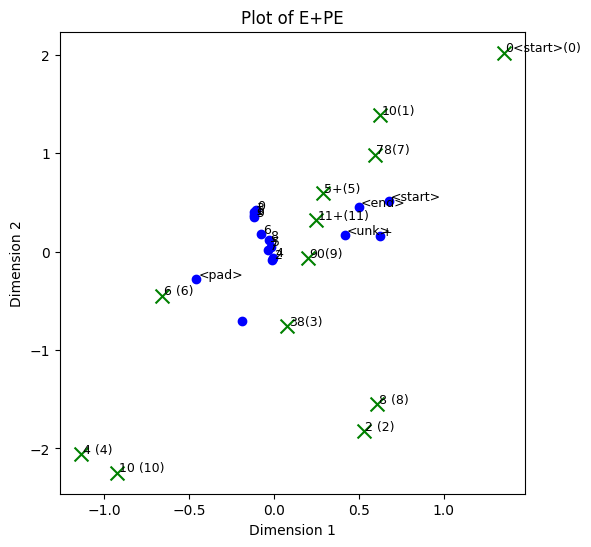

SelfAttention Layer
QV.shape: torch.Size([1, 12, 4])
KV.shape: torch.Size([1, 12, 4])
WV.shape: torch.Size([1, 12, 4])
attn_weight.shape: torch.Size([1, 12, 12])
AV.shape: torch.Size([1, 12, 4])
[[[-0.862765    0.8158668   1.1791258  -0.6090478 ]]

 [[-0.18298042  0.24564502 -1.0842454  -0.08279233]]

 [[-0.0366016   0.1547759  -1.1618245  -0.04000014]]

 [[ 0.09917522  0.02690975 -1.683028    0.06086704]]

 [[ 1.7703844  -0.92828774 -1.1641189   0.26367265]]

 [[ 0.06755625  0.16780844 -0.25640318 -0.16471334]]

 [[ 1.349223   -0.6697401  -1.1330514   0.19635847]]

 [[-0.1528008   0.22560084 -1.1189239  -0.07034308]]

 [[-0.09274345  0.20042047 -1.0153152  -0.07320483]]

 [[ 0.04295529  0.07137458 -1.5657928   0.03475122]]

 [[ 1.6087261  -0.8341938  -1.202265    0.2436642 ]]

 [[ 0.20107305  0.08008288 -0.36986893 -0.12085456]]]
(12, 1, 4)
[[-0.862765    0.8158668 ]
 [-0.18298042  0.24564502]
 [-0.0366016   0.1547759 ]
 [ 0.09917522  0.02690975]
 [ 1.7703844  -0.92828774]
 [ 0.067556

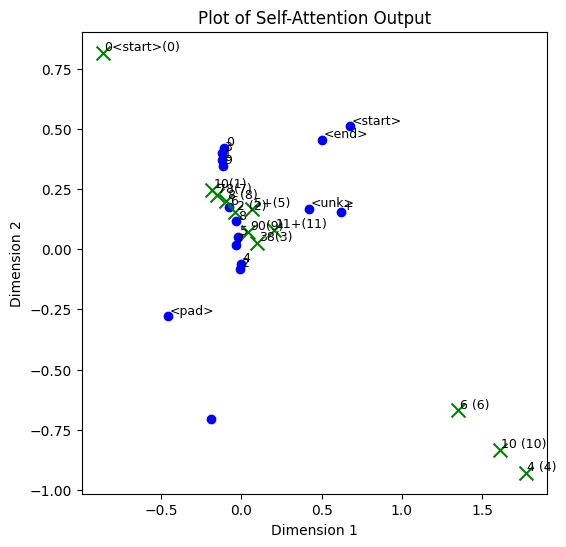

[[[-1.0903459   0.97683835  1.1201032  -0.6236191 ]]

 [[-0.06273453  0.8417224  -1.6854548   0.939188  ]]

 [[ 0.45955747 -1.5918523  -0.7649008   1.3647457 ]]

 [[ 0.16041736 -0.4035124  -1.4693999   1.4840573 ]]

 [[ 0.43878964 -1.9218806  -0.35994548  1.2625277 ]]

 [[-0.90445954  1.6059277  -0.8174785   0.57122844]]

 [[ 0.4418872  -1.3364013  -0.99513227  1.4056579 ]]

 [[-0.02017796  0.6403621  -1.691968    1.0610474 ]]

 [[ 0.45756796 -1.5625494  -0.7937709   1.3719355 ]]

 [[ 0.09187943 -0.01139454 -1.5956866   1.3704    ]]

 [[ 0.45569262 -1.9447535  -0.33268124  1.2301545 ]]

 [[-0.17190678 -0.8014808  -1.0040132   1.8221499 ]]]
(12, 1, 4)
[[-1.0903459   0.97683835]
 [-0.06273453  0.8417224 ]
 [ 0.45955747 -1.5918523 ]
 [ 0.16041736 -0.4035124 ]
 [ 0.43878964 -1.9218806 ]
 [-0.90445954  1.6059277 ]
 [ 0.4418872  -1.3364013 ]
 [-0.02017796  0.6403621 ]
 [ 0.45756796 -1.5625494 ]
 [ 0.09187943 -0.01139454]
 [ 0.45569262 -1.9447535 ]
 [-0.17190678 -0.8014808 ]]


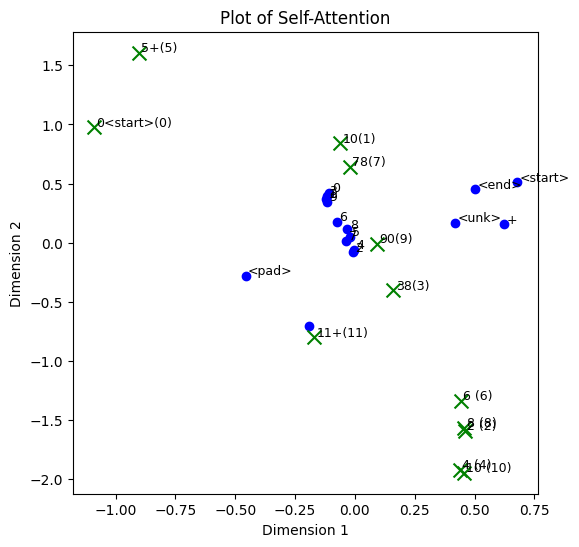

QV.shape: torch.Size([1, 12, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 12, 15])
AV.shape: torch.Size([1, 12, 4])
[[[-0.9392256   0.04739572 -0.49530977 -0.23032837]]

 [[-1.5656385   0.395988    0.20506892  1.3491004 ]]

 [[-2.3999827  -0.38746047 -1.090341   -3.3300831 ]]

 [[-1.7683179   0.57922953  0.10564459  0.5222236 ]]

 [[-2.491169   -0.4011582  -1.1186887  -3.437944  ]]

 [[-1.363474    0.2948966   0.06276143  1.2246214 ]]

 [[-2.2654274  -0.30474377 -0.9852415  -2.9883785 ]]

 [[-1.5960758   0.42757452  0.20522693  1.2932209 ]]

 [[-2.3875835  -0.3834477  -1.0843174  -3.3091943 ]]

 [[-1.7156686   0.5598635   0.18979664  0.967003  ]]

 [[-2.5015676  -0.39979446 -1.1195194  -3.4426043 ]]

 [[-1.7070938  -0.20416413 -0.79635805 -2.200351  ]]]
(12, 1, 4)
[[-0.9392256   0.04739572]
 [-1.5656385   0.395988  ]
 [-2.3999827  -0.38746047]
 [-1.7683179   0.57922953]
 [-2.491169   -0.4011582 ]
 [-1.363474    0.2948966 ]
 [-2

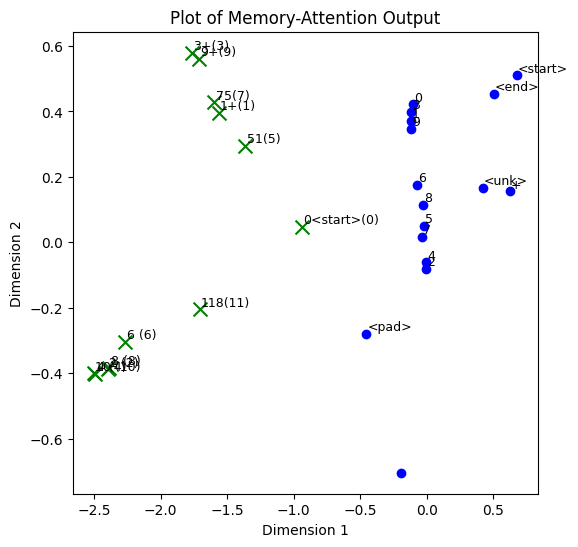

[[[-5.3241653   2.2859068   1.899232   -1.034971  ]]

 [[-3.9495401   1.2212915  -3.0070205   3.778361  ]]

 [[-0.8076356  -2.6951642   4.457226   -1.5301212 ]]

 [[-3.802944    0.21156436 -2.648063    4.448855  ]]

 [[-0.9110729  -2.8681965   4.4515257  -1.2473235 ]]

 [[-5.2048573   2.0028315  -1.8286377   2.7746131 ]]

 [[-1.8951964   1.401238   -4.4339533   3.3004158 ]]

 [[-3.8881538   1.0154375  -2.9863312   3.9402847 ]]

 [[-1.3563554  -2.5781236   4.530948   -1.2919924 ]]

 [[-3.8359416   0.47032925 -2.7728825   4.30495   ]]

 [[-0.75004107 -2.826754    4.434258   -1.4065084 ]]

 [[-3.8690288   0.6174765  -2.822559    4.214114  ]]]
(12, 1, 4)
[[-5.3241653   2.2859068 ]
 [-3.9495401   1.2212915 ]
 [-0.8076356  -2.6951642 ]
 [-3.802944    0.21156436]
 [-0.9110729  -2.8681965 ]
 [-5.2048573   2.0028315 ]
 [-1.8951964   1.401238  ]
 [-3.8881538   1.0154375 ]
 [-1.3563554  -2.5781236 ]
 [-3.8359416   0.47032925]
 [-0.75004107 -2.826754  ]
 [-3.8690288   0.6174765 ]]


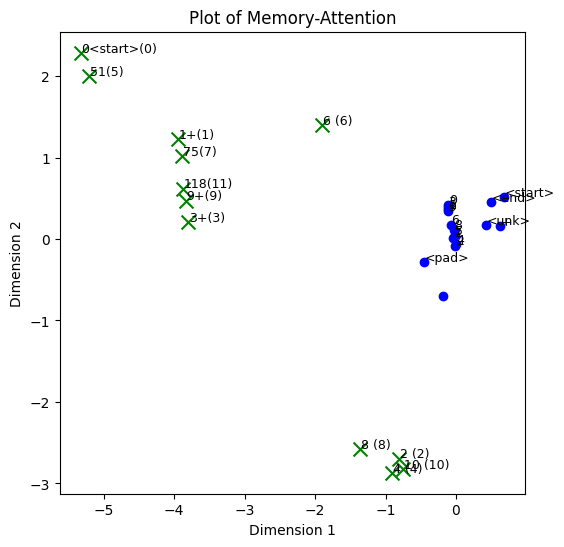

output.shape: torch.Size([1, 16])
output: tensor([[ -4.0573,   1.8860, -12.4132,   0.8035, -14.3164, -15.1326,  -4.0464,  -9.0526, -14.6174,
           1.0460,  -6.2149,  -6.1817,  -5.8023,  -3.0442,  -7.3287,  10.9568]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 15

------------------

iter: 12
ys: tensor([[12],
        [ 0],
        [15],
        [ 8],
        [15],
        [14],
        [15],
        [ 8],
        [15],
        [ 0],
        [15],
        [14],
        [15]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]],

        [[ 0.2872,  0.5951,  0.6541,  0.7773]],

        [[-0.6598, -0.4470,  0.0113,  1.0932]],

        [[ 0.5932,  0.9839, -0.9952,  1.7531]],

        [[ 0.6090, -1.5526,  0.0313,  1.0918]],

        [[ 0.1976, -0.0687, 

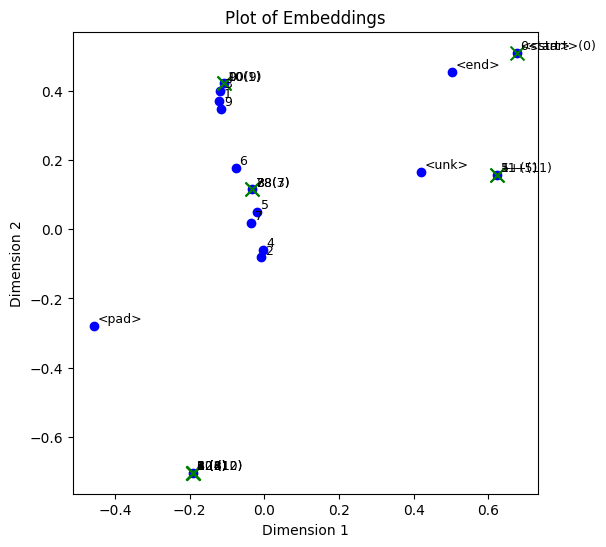

[[[ 1.3527172   2.0194998   1.8224976   1.8423921 ]]

 [[ 0.6269504   1.3827169  -1.1499087   1.7872171 ]]

 [[ 0.5289055  -1.823288   -0.0286332   1.0948254 ]]

 [[ 0.07733025 -0.7600116  -1.0351462   1.7550772 ]]

 [[-1.1371944  -2.0607848  -0.00864253  1.0942255 ]]

 [[ 0.28716075  0.5950839   0.654073    0.7772598 ]]

 [[-0.6598074  -0.44697082  0.01133214  1.093226  ]]

 [[ 0.59319687  0.98388314 -0.99519885  1.7530782 ]]

 [[ 0.60896635 -1.5526412   0.03128283  1.091827  ]]

 [[ 0.1975979  -0.06871575 -1.07003     1.7832198 ]]

 [[-0.924413   -2.2462125   0.05120155  1.0900296 ]]

 [[ 0.24609482  0.3158474   0.71387213  0.7724657 ]]

 [[-0.9169648  -0.56328714  0.07108034  1.087834  ]]]
(13, 1, 4)
[[ 1.3527172   2.0194998 ]
 [ 0.6269504   1.3827169 ]
 [ 0.5289055  -1.823288  ]
 [ 0.07733025 -0.7600116 ]
 [-1.1371944  -2.0607848 ]
 [ 0.28716075  0.5950839 ]
 [-0.6598074  -0.44697082]
 [ 0.59319687  0.98388314]
 [ 0.60896635 -1.5526412 ]
 [ 0.1975979  -0.06871575]
 [-0.924413   -2.

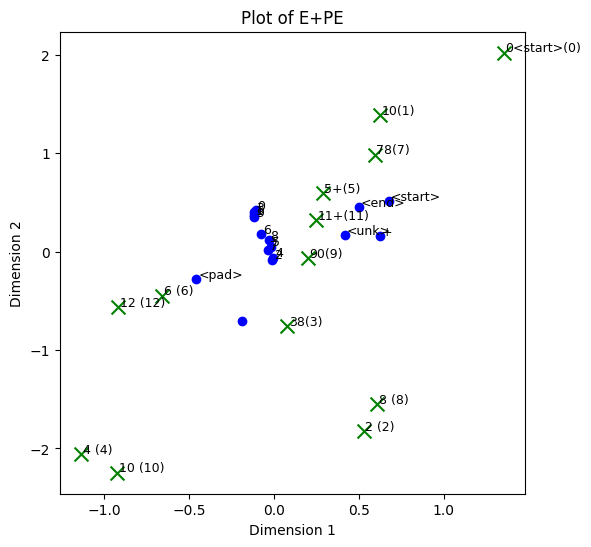

SelfAttention Layer
QV.shape: torch.Size([1, 13, 4])
KV.shape: torch.Size([1, 13, 4])
WV.shape: torch.Size([1, 13, 4])
attn_weight.shape: torch.Size([1, 13, 13])
AV.shape: torch.Size([1, 13, 4])
[[[-0.8147609   0.7836435   1.152288   -0.59726703]]

 [[-0.19346398  0.25847995 -0.98252785 -0.10365917]]

 [[-0.04778906  0.16566777 -1.0959076  -0.05437602]]

 [[ 0.09538627  0.03056501 -1.6628675   0.0565696 ]]

 [[ 1.769384   -0.92762697 -1.1631562   0.26332223]]

 [[ 0.03110122  0.19416147 -0.1629214  -0.1909105 ]]

 [[ 1.3409128  -0.6641581  -1.1232632   0.19306375]]

 [[-0.16359723  0.23804596 -1.0259724  -0.0896555 ]]

 [[-0.1050668   0.21279308 -0.9350399  -0.09066011]]

 [[ 0.03711013  0.07714573 -1.5322299   0.02761213]]

 [[ 1.6070347  -0.833066   -1.2004728   0.24304052]]

 [[ 0.15968701  0.10938378 -0.27979895 -0.14694163]]

 [[ 1.6805149  -0.8672385  -1.10147     0.24310546]]]
(13, 1, 4)
[[-0.8147609   0.7836435 ]
 [-0.19346398  0.25847995]
 [-0.04778906  0.16566777]
 [ 0.095386

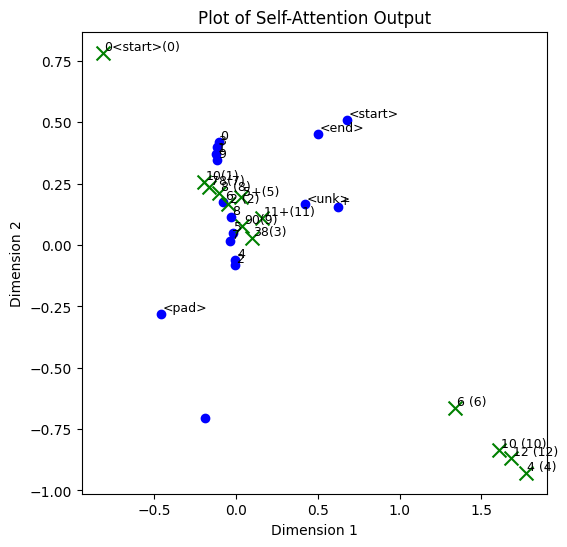

[[[-1.0859563   0.9718623   1.1263869  -0.6320412 ]]

 [[-0.07728094  0.8625486  -1.6792508   0.93529856]]

 [[ 0.45402357 -1.6230075  -0.7307227   1.3643836 ]]

 [[ 0.1582336  -0.40529674 -1.4674668   1.4867204 ]]

 [[ 0.43849775 -1.9220873  -0.35953128  1.2626948 ]]

 [[-1.1081711   1.6452405  -0.3081784   0.29907253]]

 [[ 0.43843493 -1.3381163  -0.99250185  1.4093438 ]]

 [[-0.03393549  0.65691763 -1.687415    1.0614725 ]]

 [[ 0.45063025 -1.6064532  -0.7467551   1.3713893 ]]

 [[ 0.08770203 -0.01092523 -1.5938066   1.3739905 ]]

 [[ 0.45521098 -1.945156   -0.3319059   1.2303882 ]]

 [[-0.6615175  -0.7855496  -0.42285195  1.9030354 ]]

 [[ 0.46672183 -1.5485828  -0.8106956   1.364257  ]]]
(13, 1, 4)
[[-1.0859563   0.9718623 ]
 [-0.07728094  0.8625486 ]
 [ 0.45402357 -1.6230075 ]
 [ 0.1582336  -0.40529674]
 [ 0.43849775 -1.9220873 ]
 [-1.1081711   1.6452405 ]
 [ 0.43843493 -1.3381163 ]
 [-0.03393549  0.65691763]
 [ 0.45063025 -1.6064532 ]
 [ 0.08770203 -0.01092523]
 [ 0.45521098 -1.

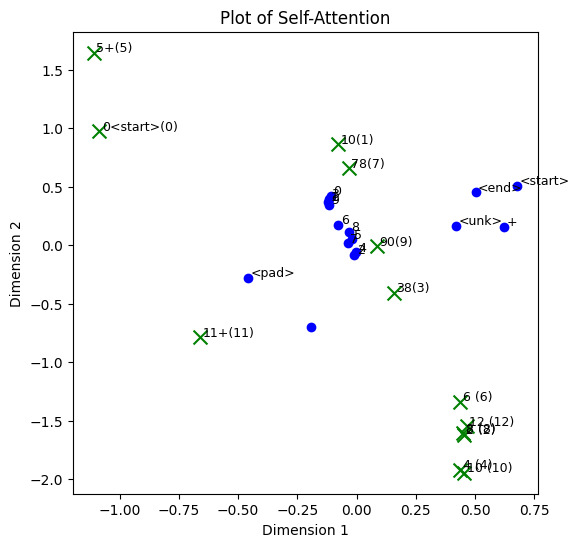

QV.shape: torch.Size([1, 13, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 13, 15])
AV.shape: torch.Size([1, 13, 4])
[[[-0.9373239   0.04506554 -0.49820903 -0.24121661]]

 [[-1.5614958   0.39259404  0.20378485  1.3519917 ]]

 [[-2.4100733  -0.39178252 -1.0961223  -3.349808  ]]

 [[-1.7676787   0.5778011   0.1034542   0.5157949 ]]

 [[-2.4911203  -0.40117604 -1.1186919  -3.437949  ]]

 [[-1.2736523   0.27220374 -0.0346373   1.0562274 ]]

 [[-2.2657168  -0.30724573 -0.9877822  -2.9957304 ]]

 [[-1.5918823   0.4241107   0.20383564  1.2961191 ]]

 [[-2.402814   -0.3904541  -1.0935546  -3.3404095 ]]

 [[-1.7146451   0.5591642   0.18883525  0.965439  ]]

 [[-2.5015     -0.39982194 -1.1195251  -3.4426162 ]]

 [[-1.4301921  -0.4987262  -1.0212654  -2.850291  ]]

 [[-2.3844895  -0.37953597 -1.0801371  -3.2960472 ]]]
(13, 1, 4)
[[-0.9373239   0.04506554]
 [-1.5614958   0.39259404]
 [-2.4100733  -0.39178252]
 [-1.7676787   0.5778011 ]
 [-2

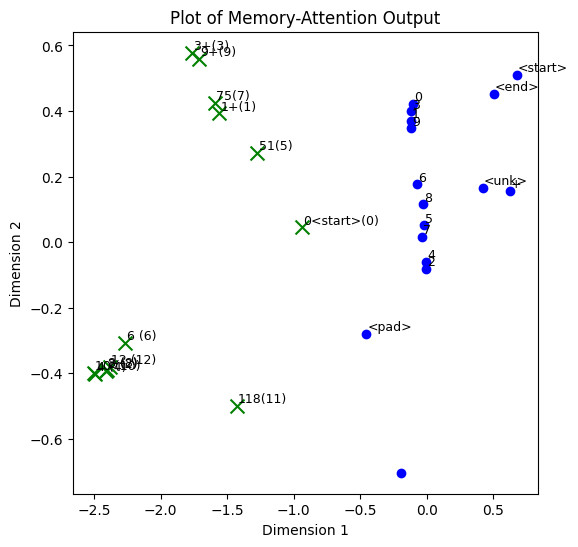

[[[-5.299705    2.2827182   1.9198575  -1.0708759 ]]

 [[-3.9677074   1.2386391  -2.9968371   3.7636688 ]]

 [[-0.919303   -2.8051326   4.4625154  -1.3221085 ]]

 [[-3.8042276   0.21035765 -2.6461494   4.449399  ]]

 [[-0.91366124 -2.868515    4.451829   -1.2451769 ]]

 [[-5.6257753   2.2013242  -1.1441535   2.23094   ]]

 [[-1.9278697   1.3968356  -4.4165874   3.3148744 ]]

 [[-3.903147    1.0268646  -2.9778292   3.9313095 ]]

 [[-1.1545987  -2.8061879   4.4910307  -1.1594664 ]]

 [[-3.839707    0.4694155  -2.7690475   4.3053083 ]]

 [[-0.7542266  -2.827334    4.434905   -1.4031148 ]]

 [[-5.8309135   0.50977755 -0.33341673  3.5144968 ]]

 [[-0.5599652  -2.0918832   4.327496   -2.2813637 ]]]
(13, 1, 4)
[[-5.299705    2.2827182 ]
 [-3.9677074   1.2386391 ]
 [-0.919303   -2.8051326 ]
 [-3.8042276   0.21035765]
 [-0.91366124 -2.868515  ]
 [-5.6257753   2.2013242 ]
 [-1.9278697   1.3968356 ]
 [-3.903147    1.0268646 ]
 [-1.1545987  -2.8061879 ]
 [-3.839707    0.4694155 ]
 [-0.7542266  -2.

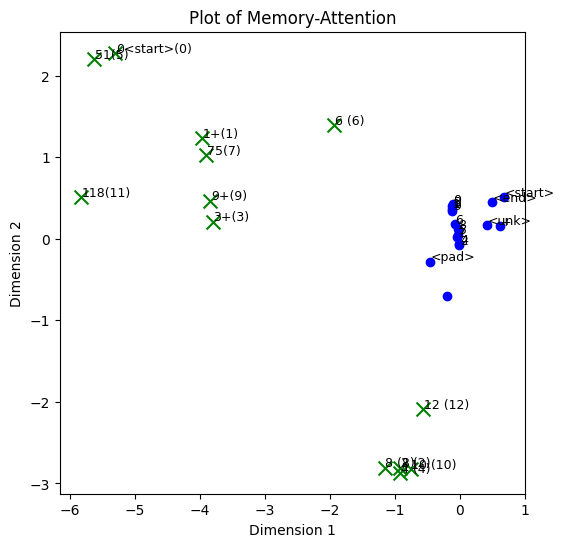

output.shape: torch.Size([1, 16])
output: tensor([[ 0.6299, -4.5865,  1.5176, -2.8952,  4.3552,  5.3205, -3.6135,  0.2974,  5.2946, -7.3559,
          3.1843,  3.3555,  3.3822,  5.3871, 15.7510,  1.1676]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 14

------------------

iter: 13
ys: tensor([[12],
        [ 0],
        [15],
        [ 8],
        [15],
        [14],
        [15],
        [ 8],
        [15],
        [ 0],
        [15],
        [14],
        [15],
        [14]], device='cuda:0')
tgt_embed: tensor([[[ 1.3527,  2.0195,  1.8225,  1.8424]],

        [[ 0.6270,  1.3827, -1.1499,  1.7872]],

        [[ 0.5289, -1.8233, -0.0286,  1.0948]],

        [[ 0.0773, -0.7600, -1.0351,  1.7551]],

        [[-1.1372, -2.0608, -0.0086,  1.0942]],

        [[ 0.2872,  0.5951,  0.6541,  0.7773]],

        [[-0.6598, -0.4470,  0.0113,  1.0932]],

        [[ 0.5932,  0.9839, -0.9952,  1.7531]],

        [[ 0.6090, -1.5526,  0.0313,  1.0918]],

        [[ 0.1976, -0.0687, -1

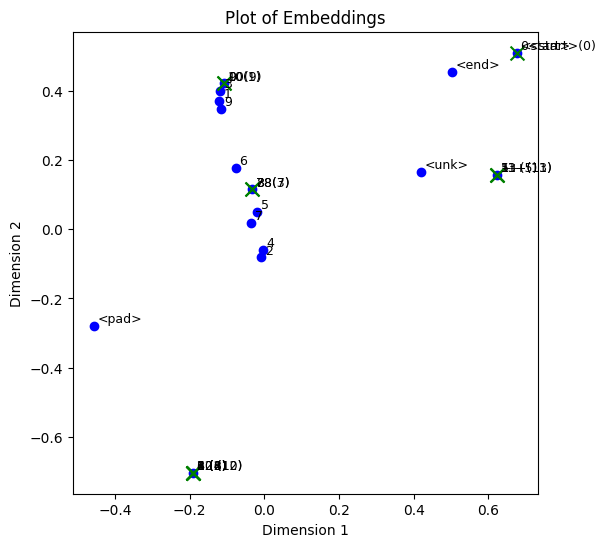

[[[ 1.3527172   2.0194998   1.8224976   1.8423921 ]]

 [[ 0.6269504   1.3827169  -1.1499087   1.7872171 ]]

 [[ 0.5289055  -1.823288   -0.0286332   1.0948254 ]]

 [[ 0.07733025 -0.7600116  -1.0351462   1.7550772 ]]

 [[-1.1371944  -2.0607848  -0.00864253  1.0942255 ]]

 [[ 0.28716075  0.5950839   0.654073    0.7772598 ]]

 [[-0.6598074  -0.44697082  0.01133214  1.093226  ]]

 [[ 0.59319687  0.98388314 -0.99519885  1.7530782 ]]

 [[ 0.60896635 -1.5526412   0.03128283  1.091827  ]]

 [[ 0.1975979  -0.06871575 -1.07003     1.7832198 ]]

 [[-0.924413   -2.2462125   0.05120155  1.0900296 ]]

 [[ 0.24609482  0.3158474   0.71387213  0.7724657 ]]

 [[-0.9169648  -0.56328714  0.07108034  1.087834  ]]

 [[ 1.6662521   1.2188685   0.733728    0.7700715 ]]]
(14, 1, 4)
[[ 1.3527172   2.0194998 ]
 [ 0.6269504   1.3827169 ]
 [ 0.5289055  -1.823288  ]
 [ 0.07733025 -0.7600116 ]
 [-1.1371944  -2.0607848 ]
 [ 0.28716075  0.5950839 ]
 [-0.6598074  -0.44697082]
 [ 0.59319687  0.98388314]
 [ 0.60896635 -1.

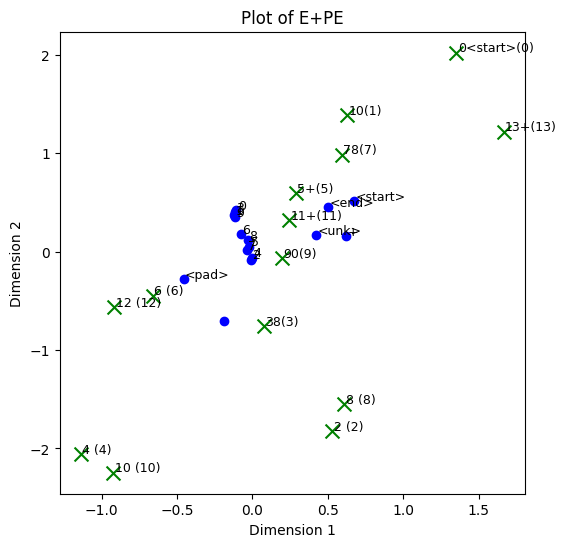

SelfAttention Layer
QV.shape: torch.Size([1, 14, 4])
KV.shape: torch.Size([1, 14, 4])
WV.shape: torch.Size([1, 14, 4])
attn_weight.shape: torch.Size([1, 14, 14])
AV.shape: torch.Size([1, 14, 4])
[[[-0.81237257  0.7820697   1.1487364  -0.59597033]]

 [[-0.03770211  0.16638124 -1.1038154  -0.03332828]]

 [[ 0.17299119  0.03606801 -1.2678306   0.04764138]]

 [[ 0.5981247  -0.24647489 -1.8931437   0.273021  ]]

 [[ 1.627737   -0.82962227 -1.8056428   0.48941043]]

 [[ 0.10575852  0.14657559 -0.27106208 -0.14771438]]

 [[ 1.4078645  -0.6978513  -1.5789614   0.37494722]]

 [[ 0.01385791  0.13341364 -1.1620187  -0.00958424]]

 [[ 0.07296247  0.1068054  -1.0864427  -0.00731863]]

 [[ 0.44512072 -0.15168527 -1.747798    0.20434597]]

 [[ 1.5578432  -0.789453   -1.8004309   0.4721745 ]]

 [[ 0.2413469   0.05750418 -0.40226066 -0.09786145]]

 [[ 1.6138188  -0.82064676 -1.5921662   0.41517577]]

 [[-0.9219409   0.85132813  1.2446793  -0.63821787]]]
(14, 1, 4)
[[-0.81237257  0.7820697 ]
 [-0.037702

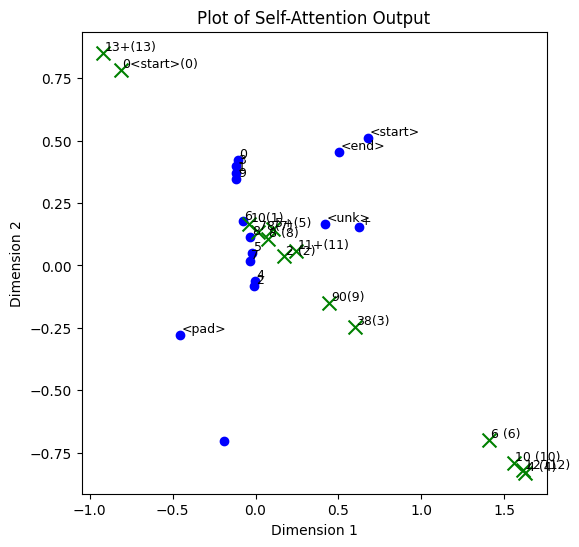

[[[-1.086122    0.9728175   1.125569   -0.63179064]]

 [[-0.00526536  0.75792116 -1.7070601   0.95287246]]

 [[ 0.522018   -1.5844747  -0.7909272   1.2963407 ]]

 [[ 0.31166402 -0.59113854 -1.4428064   1.4048352 ]]

 [[ 0.399332   -1.679323   -0.64823145  1.4058969 ]]

 [[-0.799358    1.5225629  -1.011134    0.69505084]]

 [[ 0.43200272 -1.1228338  -1.1585023   1.4027224 ]]

 [[ 0.05182311  0.53178805 -1.709509    1.071442  ]]

 [[ 0.5150198  -1.5657839  -0.8079041   1.3075949 ]]

 [[ 0.23173264 -0.20837997 -1.5847999   1.331851  ]]

 [[ 0.4398856  -1.7389227  -0.5972261   1.3472822 ]]

 [[ 0.05062138 -0.91739756 -1.1035705   1.7096138 ]]

 [[ 0.4160245  -1.2680999  -1.0420867   1.4315599 ]]

 [[-0.5397591   1.1385536   0.9767949  -1.4002358 ]]]
(14, 1, 4)
[[-1.086122    0.9728175 ]
 [-0.00526536  0.75792116]
 [ 0.522018   -1.5844747 ]
 [ 0.31166402 -0.59113854]
 [ 0.399332   -1.679323  ]
 [-0.799358    1.5225629 ]
 [ 0.43200272 -1.1228338 ]
 [ 0.05182311  0.53178805]
 [ 0.5150198  -1.

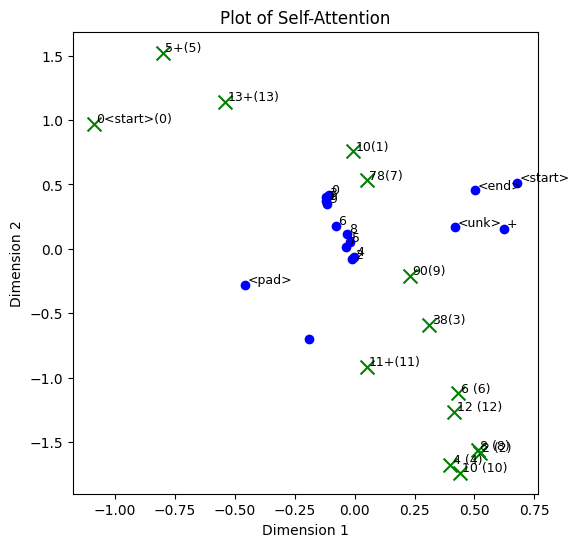

QV.shape: torch.Size([1, 14, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 14, 15])
AV.shape: torch.Size([1, 14, 4])
[[[-0.9378354   0.04563829 -0.49751237 -0.23876397]]

 [[-1.5828781   0.41045904  0.21009743  1.3357338 ]]

 [[-2.4156492  -0.37726283 -1.0841033  -3.3152034 ]]

 [[-1.8272445   0.5716394   0.06240088  0.27567282]]

 [[-2.4117227  -0.40191114 -1.1050395  -3.3778179 ]]

 [[-1.3960644   0.30515254  0.09349504  1.2694633 ]]

 [[-2.10298    -0.07974975 -0.7254527  -2.1914928 ]]

 [[-1.6220957   0.45064038  0.21193472  1.267467  ]]

 [[-2.4059045  -0.37490302 -1.0800145  -3.3008535 ]]

 [[-1.7728789   0.6102779   0.19781385  0.8597076 ]]

 [[-2.4440436  -0.40018082 -1.1096495  -3.398947  ]]

 [[-1.8665248  -0.13867526 -0.75143355 -2.1465442 ]]

 [[-2.2134056  -0.26516873 -0.93617404 -2.83102   ]]

 [[-1.1926098   0.24976183 -0.1991374   0.57323056]]]
(14, 1, 4)
[[-0.9378354   0.04563829]
 [-1.5828781   0.41045904]
 [-2

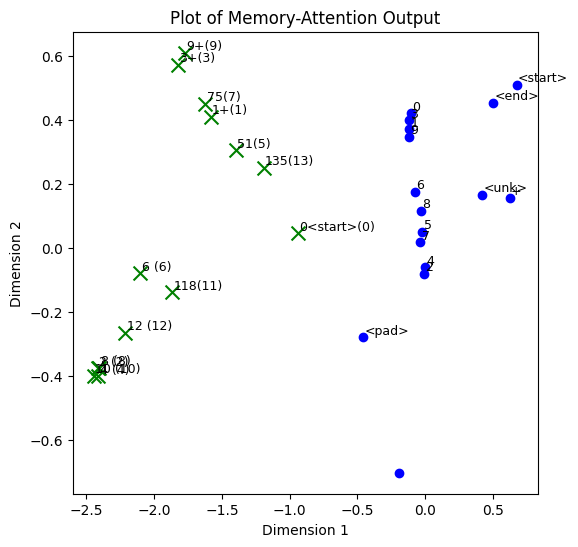

[[[-5.3027864   2.2833633   1.9169354  -1.0663149 ]]

 [[-3.8801224   1.1531696  -3.0439157   3.8346236 ]]

 [[ 2.2193363  -1.4842937   2.8266203  -3.750254  ]]

 [[-3.663764    0.12763526 -2.7171245   4.4978166 ]]

 [[-2.0505977  -2.9780226   4.419274   -0.17821635]]

 [[-5.008561    1.8701184  -2.075709    3.0038035 ]]

 [[-2.7444234   0.6456764  -3.7021763   4.1261783 ]]

 [[-3.8130767   0.93563586 -3.0185485   4.000614  ]]

 [[ 2.5674927  -1.1443444   2.3764935  -3.9782035 ]]

 [[-3.743026    0.36304858 -2.7930984   4.37026   ]]

 [[-1.0356799  -2.9193954   4.453251   -1.0914695 ]]

 [[-3.5183282   0.5624858  -3.0907168   4.252391  ]]

 [[-2.2718744   1.1519899  -4.1761537   3.6345325 ]]

 [[-4.973218    2.5317345   1.7166286  -1.4169575 ]]]
(14, 1, 4)
[[-5.3027864   2.2833633 ]
 [-3.8801224   1.1531696 ]
 [ 2.2193363  -1.4842937 ]
 [-3.663764    0.12763526]
 [-2.0505977  -2.9780226 ]
 [-5.008561    1.8701184 ]
 [-2.7444234   0.6456764 ]
 [-3.8130767   0.93563586]
 [ 2.5674927  -1.

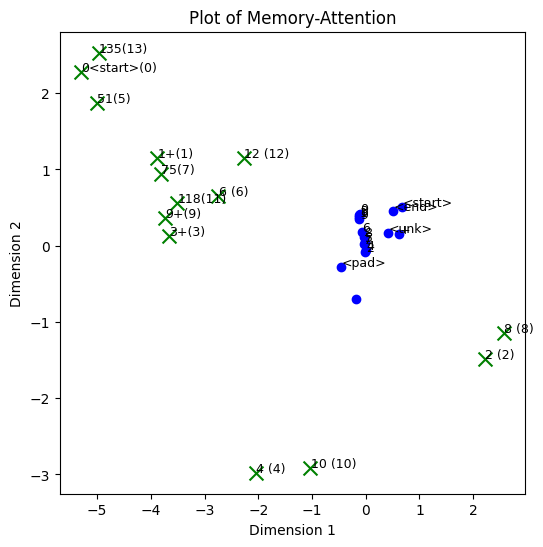

output.shape: torch.Size([1, 16])
output: tensor([[  2.8030,  -6.4619,  -8.9447,  -2.5182,  -3.5361,   0.2332, -11.6836,  -9.9150,   1.2252,
          -9.8385,   0.2851,   0.0437,   0.3487,  11.1571,   3.4062,   2.9094]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 13

------------------

Input: + + 1 5 + 8 5
Decoded sequence: 0 8 + 8 0 + +


In [40]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '+ + 1 5 + 8 5'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=embedding_weight[ys], title="Embeddings")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=tgt_embed, title="E+PE")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    # Self-Attentionのベクトルの可視化
    plot_embedding_tgt_2d(ys=ys, tgt_embed=self_attn_output, title="Self-Attention Output")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=tgt, title="Self-Attention")

    


    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    print(f"After Attention: {tgt}")
    # Memory-Attentionのベクトルの可視化
    plot_embedding_tgt_2d(ys=ys, tgt_embed=multi_attn_output, src=src, title="Memory-Attention Output")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=tgt, src=src, title="Memory-Attention")

    # LayerNorm
    output = tgt.transpose(0, 1)
    output = loaded_model.output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

# Transformerの検算

スクラッチで書くための検算

## Multihead Attention

Multihead Attentionの動作をスクラッチで書きたいので、ここで検算する

参考サイト
https://blog.amedama.jp/entry/pytorch-multi-head-attention-verify

In [30]:
import torch
from torch import nn
import torch.nn.functional as F


In [31]:
edim = 4 # 埋め込み次元
num_heads = 1 # ヘッド数
model = nn.MultiheadAttention(edim, num_heads, bias=True, batch_first=True)

In [ ]:
batch_size = 2
L=5
X = torch.randn(batch_size, L, edim) # 入力

Q = K = V = X # クエリ、キー、バリューは全て入力とする
print(Q.shape)
print(Q)

In [ ]:

attn_output, attn_output_weights = model(Q, K, V)

print(attn_output.shape)
print(attn_output)



In [ ]:
from pprint import pprint
pprint(list(model.named_parameters()))

In [35]:
model_weight = {name: param.data for name, param in model.named_parameters()}
Wi = model_weight['in_proj_weight']
Wo = model_weight['out_proj.weight']
Wbi = model_weight['in_proj_bias']
Wbo = model_weight['out_proj.bias']

In [36]:
Wi_q, Wi_k, Wi_v = Wi.chunk(3, dim=0)
Wbi_q, Wbi_k, Wbi_v = Wbi.chunk(3, dim=0)
QW = torch.matmul(Q, Wi_q.T) + Wbi_q
KW = torch.matmul(K, Wi_k.T) + Wbi_k
VW = torch.matmul(V, Wi_v.T) + Wbi_v

KW_t = KW.transpose(-2, -1)
QK_t = torch.bmm(QW, KW_t)
QK_scaled = QK_t / (edim ** 0.5)
attn_weights_ = F.softmax(QK_scaled, dim=-1)

In [ ]:
print(attn_weights_)
print(attn_output_weights)

In [38]:
AV = torch.matmul(attn_weights_, VW)
attn_output_ = torch.matmul(AV, Wo.T) + Wbo

In [ ]:
print(attn_output_)
print(attn_output)

## nn.Linear

In [ ]:
model = nn.Linear(4, 4)
model

In [ ]:
pprint(list(model.named_parameters()))

In [ ]:
model_weight = {name: param.data for name, param in model.named_parameters()}
W = model_weight['weight']
B = model_weight['bias']

X = torch.randn(4) 
print(X.shape)
print(X)
output = model(X)
print(output.shape)
print(output)


In [ ]:
output_ = X.matmul(W.T) + B
print(output_)
print(output)

## nn.LayerNorm

参考サイト
https://qiita.com/dl_from_scratch/items/133fe741b67ed14f1856

In [ ]:
model = nn.LayerNorm(4)
model

In [ ]:
pprint(list(model.named_parameters()))

In [ ]:
model_weight = {name: param.data for name, param in model.named_parameters()}
W = model_weight['weight']
B = model_weight['bias']

X = torch.randn(4) 
print(X.shape)
print(X)
output = model(X)
print(output.shape)
print(output)


In [ ]:
output_ = X.matmul(W.T) + B
print(output_)
print(output)